## European Football: About Project

**Ultimate 25k+ Matches Football Database**
The link to the [Kaggle dataset is here](https://www.kaggle.com/prajitdatta/ultimate-25k-matches-football-database-european).

This project aims to analyse the ultimate European 25k matches football database. 

## The goal of this project is to answer the following questions

### League Analysis:
* What are the number of matches of each league in the dataset?
* Which countries have the largest/smallest home and away goal difference?
* Which leagues have the highest and lowest average home goals?
* Which leagues have the highest and lowest average away goals?
* Is there such thing as home advantage?

### Team Analysis:
* How many distinct teams there are in each league?
* What are the teams with largest number of matches won?
* Which are the teams with highest winning rate?
* Which are the teams that scored highest number of home goals?
* Which are the teams that scored highest number of away goals?
* Which are the teams that won most of the games in each league by season?
* Do teams with highest number of won matches also have lowest home-away average goal difference?
* What features are mostly correlated with team winning rate?

### Player Analysis:
* What is the distribution of player overall rating in the dataset?
* What are the best and worst players by overall rating?
* In what teams did best and worst players play in?
* What is the distribution of player age in the dataset?
* What are the youngest and oldest players in the dataset?
* How did overall rating change overtime for oldest players?
* How did potential change overtime for oldest players?
* Do young players have some remarkable difference over older players by their potential?
* What are the most correlated features with player age?
* What are the most correlated features with player overall rating?
* What are the most positively correlated features in player_attributes?
* What are the most negatively correlated features in player_attributes?

### Prediction:
* Is it possible to predict game outcome (home, draw or away)?
* Is it possible to predict number of home team goals?
* Is it possible to predict number of away team goals?


In [385]:
import sqlite3 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import missingno as msno 
import researchpy as rp
import warnings
import itertools

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor  


In [386]:
warnings.simplefilter(action='ignore', category=FutureWarning) 

Connecting to the database

In [387]:
db = sqlite3.connect("database.sqlite") 

## Data Cleaning

First I wanted to see what kind of tables we have in our table

In [388]:
'''List of Tables'''
query = "SELECT name FROM sqlite_master WHERE type ='table';"
df = pd.read_sql(sql=query, con=db)
df

name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes

Therefore, I read the country table and check for it's NaN values

In [389]:
sql = '''SELECT *
         FROM country;'''
         
countries = pd.read_sql(sql=sql, con=db)
countries.head()

id     name
0      1  Belgium
1   1729  England
2   4769   France
3   7809  Germany
4  10257    Italy

In [390]:
""" Checking countries table dataset """
countries.isnull().sum()

id      0
name    0
dtype: int64

Reading the league table and checking for its null values

In [391]:
sql = '''SELECT *
         FROM league;'''
         
leagues = pd.read_sql(sql=sql, con=db)
leagues.head()

id  country_id                    name
0      1           1  Belgium Jupiler League
1   1729        1729  England Premier League
2   4769        4769          France Ligue 1
3   7809        7809   Germany 1. Bundesliga
4  10257       10257           Italy Serie A

In [392]:
leagues.isnull().sum()

id            0
country_id    0
name          0
dtype: int64

Reading player table and checking for it's null values

In [393]:
sql = '''SELECT *
         FROM player;'''
         
players = pd.read_sql(sql=sql, con=db)
players.head()

id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   
3   4          30572       Aaron Galindo              140161   
4   5          23780        Aaron Hughes               17725   

              birthday  height  weight  
0  1992-02-29 00:00:00  182.88     187  
1  1989-12-15 00:00:00  170.18     146  
2  1991-05-13 00:00:00  170.18     163  
3  1982-05-08 00:00:00  182.88     198  
4  1979-11-08 00:00:00  182.88     154

In [394]:
players.isnull().sum()

id                    0
player_api_id         0
player_name           0
player_fifa_api_id    0
birthday              0
height                0
weight                0
dtype: int64

Reading the player attributes and checking for its null values

In [395]:
sql = '''SELECT *
         FROM player_attributes;'''
         
player_attributes = pd.read_sql(sql=sql, con=db)
player_attributes.head()

id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0   
3   4              218353         505942  2015-03-20 00:00:00            61.0   
4   5              218353         505942  2007-02-22 00:00:00            61.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   
1       71.0          right              medium              medium      49.0   
2       66.0          right              medium              medium      49.0   
3       65.0          right              medium              medium      48.0   
4       65.0          right              medium              medium      48.0   

   ...  vision  penalties  marking  standing_tackle  sliding_tackle  \
0  ...    54.0       48.0     65.0             69.0            69.0   
1  ...    54.0       48.0     65.0             69.0            69.0   
2  ...    54.0       48.0     65.0             66.0            69.0   
3  ...    53.0       47.0     62.0             63.0            66.0   
4  ...    53.0       47.0     62.0             63.0            66.0   

   gk_diving  gk_handling  gk_kicking  gk_positioning  gk_reflexes  
0        6.0         11.0        10.0             8.0          8.0  
1        6.0         11.0        10.0             8.0          8.0  
2        6.0         11.0        10.0             8.0          8.0  
3        5.0         10.0         9.0             7.0          7.0  
4        5.0         10.0         9.0             7.0          7.0  

[5 rows x 42 columns]

In [396]:
"""Checking which NaN values we have in our player_attributes table"""
missing_player_attr = dict(player_attributes.isnull().sum())
missing_player_attr

{'id': 0,
 'player_fifa_api_id': 0,
 'player_api_id': 0,
 'date': 0,
 'overall_rating': 836,
 'potential': 836,
 'preferred_foot': 836,
 'attacking_work_rate': 3230,
 'defensive_work_rate': 836,
 'crossing': 836,
 'finishing': 836,
 'heading_accuracy': 836,
 'short_passing': 836,
 'volleys': 2713,
 'dribbling': 836,
 'curve': 2713,
 'free_kick_accuracy': 836,
 'long_passing': 836,
 'ball_control': 836,
 'acceleration': 836,
 'sprint_speed': 836,
 'agility': 2713,
 'reactions': 836,
 'balance': 2713,
 'shot_power': 836,
 'jumping': 2713,
 'stamina': 836,
 'strength': 836,
 'long_shots': 836,
 'aggression': 836,
 'interceptions': 836,
 'positioning': 836,
 'vision': 2713,
 'penalties': 836,
 'marking': 836,
 'standing_tackle': 836,
 'sliding_tackle': 2713,
 'gk_diving': 836,
 'gk_handling': 836,
 'gk_kicking': 836,
 'gk_positioning': 836,
 'gk_reflexes': 836}

We can see that player attributes have more missing values but we can skip that for now and impute these values in the end when modelling will start

In [397]:
""" Taking all non missing columns for future calculations"""
non_missing_cols = [col for col in missing_player_attr if missing_player_attr[col] == 0]

In [398]:
""" Takinga all missing columns in our player_attributes dataset """
missing_player_attr = [col for col in missing_player_attr if missing_player_attr[col] != 0]

In [399]:
""" Filling out categorical values with mode """
cat_missing_player_attr = player_attributes[missing_player_attr].select_dtypes(include=['object']).columns.tolist()
player_attr_cat = player_attributes[cat_missing_player_attr]
player_attr_cleaned = player_attributes.fillna(player_attr_cat.mode().iloc[0]) 
player_attr_cleaned.isnull().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot            0
attacking_work_rate       0
defensive_work_rate       0
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

We can see that there are quite a few missing values in players dataset

<AxesSubplot: >

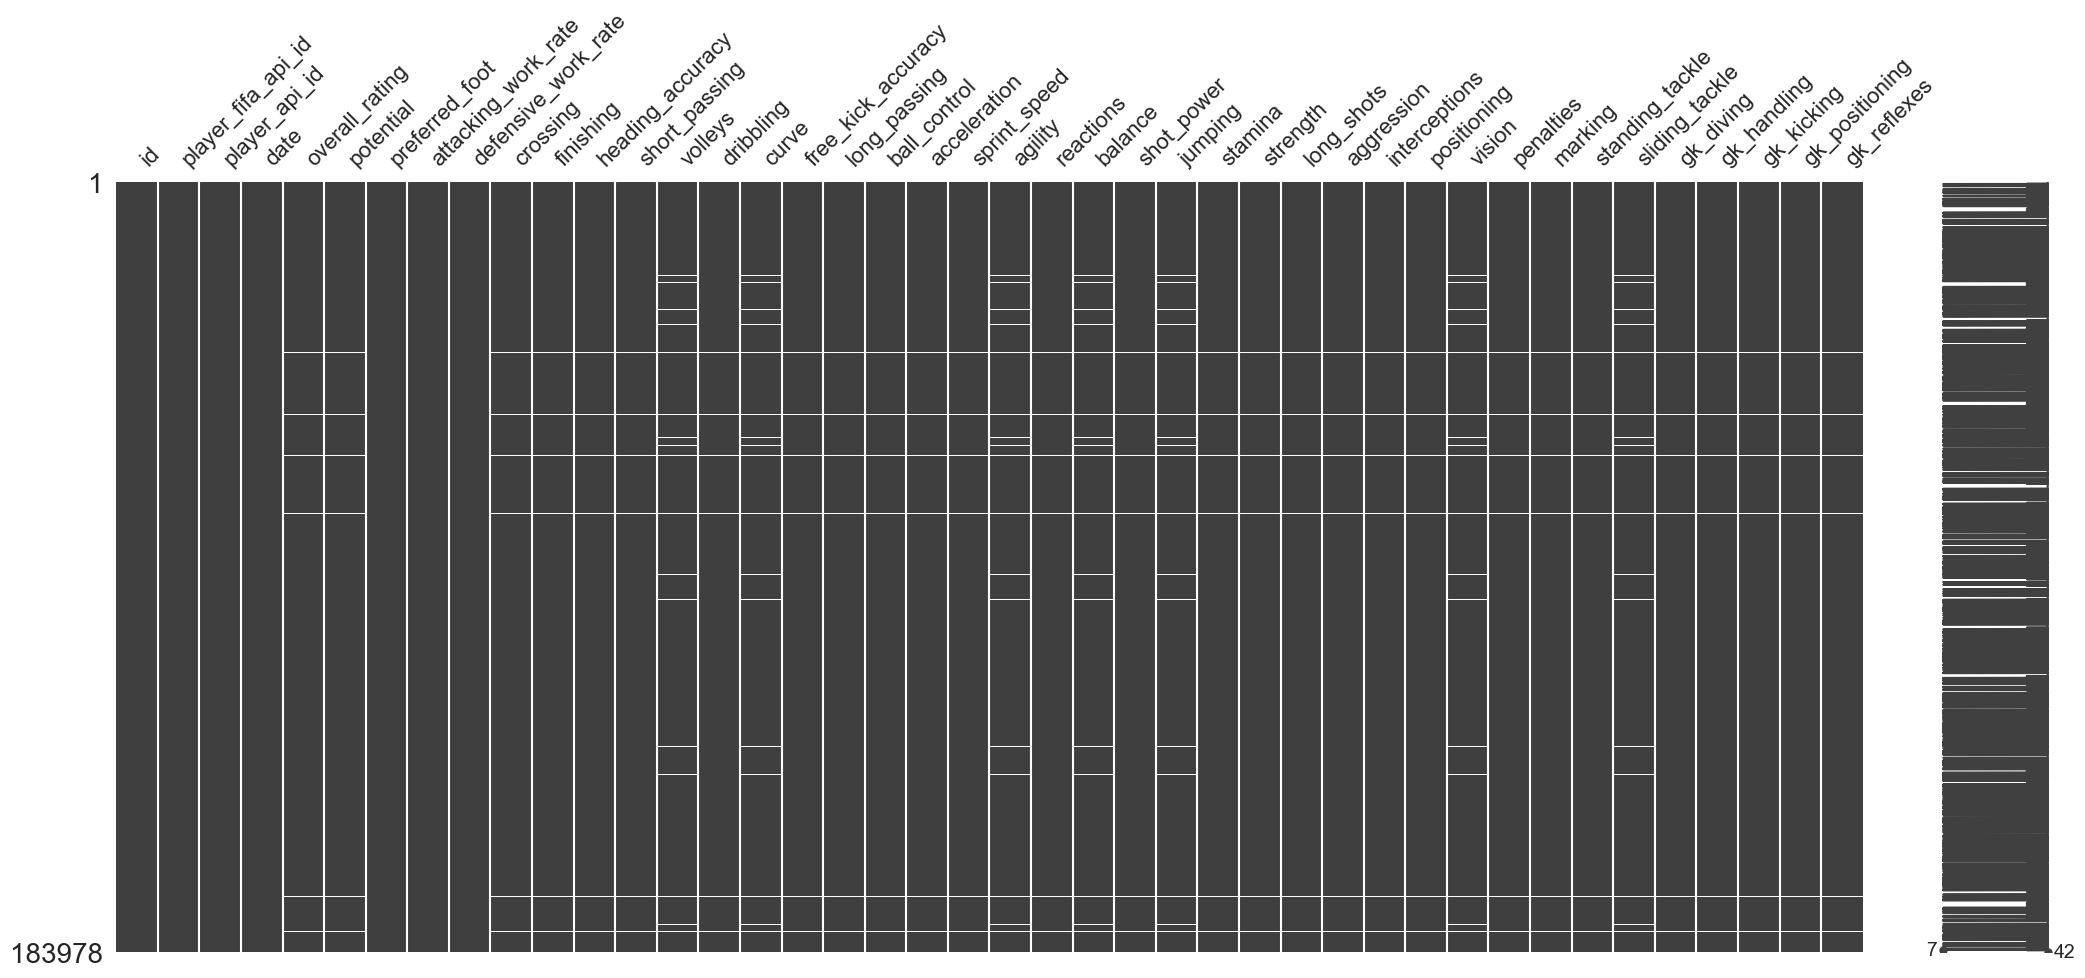

In [400]:
""" Plotting all missing values"""
msno.matrix(player_attr_cleaned)

We can see way more missing values in the matches table. Let's find out which of them are important and which can be removed.

In [401]:
sql = '''
    SELECT  
    (
        CASE WHEN home_team_goal > away_team_goal THEN 'home'
        WHEN home_team_goal < away_team_goal THEN 'away'
        ELSE 'draw' END) as game_outcome,
    (
        CASE WHEN home_team_goal > away_team_goal THEN m.home_team_api_id
        WHEN home_team_goal < away_team_goal THEN m.away_team_api_id
        ELSE 'draw' END) as winner_team_api_id,
    (
        CASE WHEN home_team_goal == away_team_goal THEN 'draw'
        ELSE t.team_long_name END
    ) as winner_team_name,
    c.name as country_name,
    m.*
    FROM match m
    LEFT OUTER JOIN 
    country c ON c.id=m.country_id
    LEFT OUTER JOIN 
    team t ON t.team_api_id=winner_team_api_id 
    '''

matches = pd.read_sql(sql=sql, con=db)
matches.head()

game_outcome winner_team_api_id   winner_team_name country_name  id  \
0         draw               draw               draw      Belgium   1   
1         draw               draw               draw      Belgium   2   
2         away               8635     RSC Anderlecht      Belgium   3   
3         home               9991           KAA Gent      Belgium   4   
4         away               9985  Standard de Liège      Belgium   5   

   country_id  league_id     season  stage                 date  ...   SJA  \
0           1          1  2008/2009      1  2008-08-17 00:00:00  ...  4.00   
1           1          1  2008/2009      1  2008-08-16 00:00:00  ...  3.80   
2           1          1  2008/2009      1  2008-08-16 00:00:00  ...  2.50   
3           1          1  2008/2009      1  2008-08-17 00:00:00  ...  7.50   
4           1          1  2008/2009      1  2008-08-16 00:00:00  ...  1.73   

    VCH   VCD   VCA   GBH   GBD   GBA   BSH   BSD   BSA  
0  1.65  3.40  4.50  1.78  3.25  4.00  1.73  3.40  4.20  
1  2.00  3.25  3.25  1.85  3.25  3.75  1.91  3.25  3.60  
2  2.35  3.25  2.65  2.50  3.20  2.50  2.30  3.20  2.75  
3  1.45  3.75  6.50  1.50  3.75  5.50  1.44  3.75  6.50  
4  4.50  3.40  1.65  4.50  3.50  1.65  4.75  3.30  1.67  

[5 rows x 119 columns]

We can see that some information is missing in the columns corresponding to player information.

I will drop rows where "home_away_1", "home_away_2"...""home_away_n" columns are NaN as information about the player is very meaningful.

In [402]:
""" Checking what NaN values we have in matches dataset """
null_vals = dict(matches.isnull().sum())
null_columns = [col for col in null_vals if null_vals[col] != 0]
null_columns

['home_player_X1',
 'home_player_X2',
 'home_player_X3',
 'home_player_X4',
 'home_player_X5',
 'home_player_X6',
 'home_player_X7',
 'home_player_X8',
 'home_player_X9',
 'home_player_X10',
 'home_player_X11',
 'away_player_X1',
 'away_player_X2',
 'away_player_X3',
 'away_player_X4',
 'away_player_X5',
 'away_player_X6',
 'away_player_X7',
 'away_player_X8',
 'away_player_X9',
 'away_player_X10',
 'away_player_X11',
 'home_player_Y1',
 'home_player_Y2',
 'home_player_Y3',
 'home_player_Y4',
 'home_player_Y5',
 'home_player_Y6',
 'home_player_Y7',
 'home_player_Y8',
 'home_player_Y9',
 'home_player_Y10',
 'home_player_Y11',
 'away_player_Y1',
 'away_player_Y2',
 'away_player_Y3',
 'away_player_Y4',
 'away_player_Y5',
 'away_player_Y6',
 'away_player_Y7',
 'away_player_Y8',
 'away_player_Y9',
 'away_player_Y10',
 'away_player_Y11',
 'home_player_1',
 'home_player_2',
 'home_player_3',
 'home_player_4',
 'home_player_5',
 'home_player_6',
 'home_player_7',
 'home_player_8',
 'home_playe

We can also see other missing colums such as 'goal', 'shoton', 'foulcommit' and more. These columns are detailed match events (goal types, possession, corner, cross, fouls, cards etc. Therefore, I will remove these columns corresponding to exact information about match that can only be determined during the match itself, as my task for this project is to predict the outcome of the game.

In [403]:
""" Checking what missing values despite player we have in the matches dataset"""
[col for col in null_columns if null_vals[col] if "_player_" not in col]

['goal',
 'shoton',
 'shotoff',
 'foulcommit',
 'card',
 'cross',
 'corner',
 'possession',
 'B365H',
 'B365D',
 'B365A',
 'BWH',
 'BWD',
 'BWA',
 'IWH',
 'IWD',
 'IWA',
 'LBH',
 'LBD',
 'LBA',
 'PSH',
 'PSD',
 'PSA',
 'WHH',
 'WHD',
 'WHA',
 'SJH',
 'SJD',
 'SJA',
 'VCH',
 'VCD',
 'VCA',
 'GBH',
 'GBD',
 'GBA',
 'BSH',
 'BSD',
 'BSA']

In [404]:
""" Removing features which can not be used for prediction """
columns_to_remove = ['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession', 'New']
betting_odds = [col for col in null_columns if null_vals[col] if "_player_" not in col and col not in columns_to_remove] 

Some of the missing values are betting odds which will be important for our future predictions, therefore, with sklearn IterativeImputer I will impute the missing values of these betting odds

In [405]:
""" Imputing betting odds missing values """
betting_odds_vals = matches[betting_odds] 
imp = IterativeImputer(max_iter=10, random_state=0)
betting_odds_vals_imputed = imp.fit_transform(betting_odds_vals.values)

betting_odds_df = pd.DataFrame(betting_odds_vals_imputed, columns = betting_odds) 
betting_odds_df.head()

/Users/emabaranauskaite/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


B365H  B365D  B365A   BWH   BWD   BWA   IWH  IWD  IWA   LBH  ...   SJA  \
0   1.73   3.40   5.00  1.75  3.35  4.20  1.85  3.2  3.5  1.80  ...  4.00   
1   1.95   3.20   3.60  1.80  3.30  3.95  1.90  3.2  3.5  1.90  ...  3.80   
2   2.38   3.30   2.75  2.40  3.30  2.55  2.60  3.1  2.3  2.50  ...  2.50   
3   1.44   3.75   7.50  1.40  4.00  6.80  1.40  3.9  6.0  1.44  ...  7.50   
4   5.00   3.50   1.65  5.00  3.50  1.60  4.00  3.3  1.7  4.00  ...  1.73   

    VCH   VCD   VCA   GBH   GBD   GBA   BSH   BSD   BSA  
0  1.65  3.40  4.50  1.78  3.25  4.00  1.73  3.40  4.20  
1  2.00  3.25  3.25  1.85  3.25  3.75  1.91  3.25  3.60  
2  2.35  3.25  2.65  2.50  3.20  2.50  2.30  3.20  2.75  
3  1.45  3.75  6.50  1.50  3.75  5.50  1.44  3.75  6.50  
4  4.50  3.40  1.65  4.50  3.50  1.65  4.75  3.30  1.67  

[5 rows x 30 columns]

Now we can see that all missing values in the dataset are gone!

In [406]:
""" Checking whether all missing values were fixed """
matches_columns = [col for col in matches.columns if col not in columns_to_remove and col not in betting_odds_vals]
matches_cleaned = pd.concat([matches[matches_columns], betting_odds_df], axis=1)
matches_cleaned.isnull().sum()

game_outcome          0
winner_team_api_id    0
winner_team_name      0
country_name          0
id                    0
                     ..
GBD                   0
GBA                   0
BSH                   0
BSD                   0
BSA                   0
Length: 111, dtype: int64

Some of the columns in the dataset do not have a few of the players in the match. This data is not correct as in football match there has to be 11 home and 11 away players, therefore, I decided to drop such values.

In [407]:
""" Dropping rows that do not have any of the players in the match """
player_cols = [col for col in matches.columns if "_player_" in col and "_player_X" not in col and "_player_Y" not in col ]
matches_cleaned = matches_cleaned.dropna(subset=player_cols)

In [408]:
null_cols = [col for col in matches_cleaned.columns if matches_cleaned[col].isnull().sum() > 0]
matches_cleaned = matches_cleaned.dropna(subset=null_cols)

We can see that there are no missing values in the matches dataset.

<AxesSubplot: >

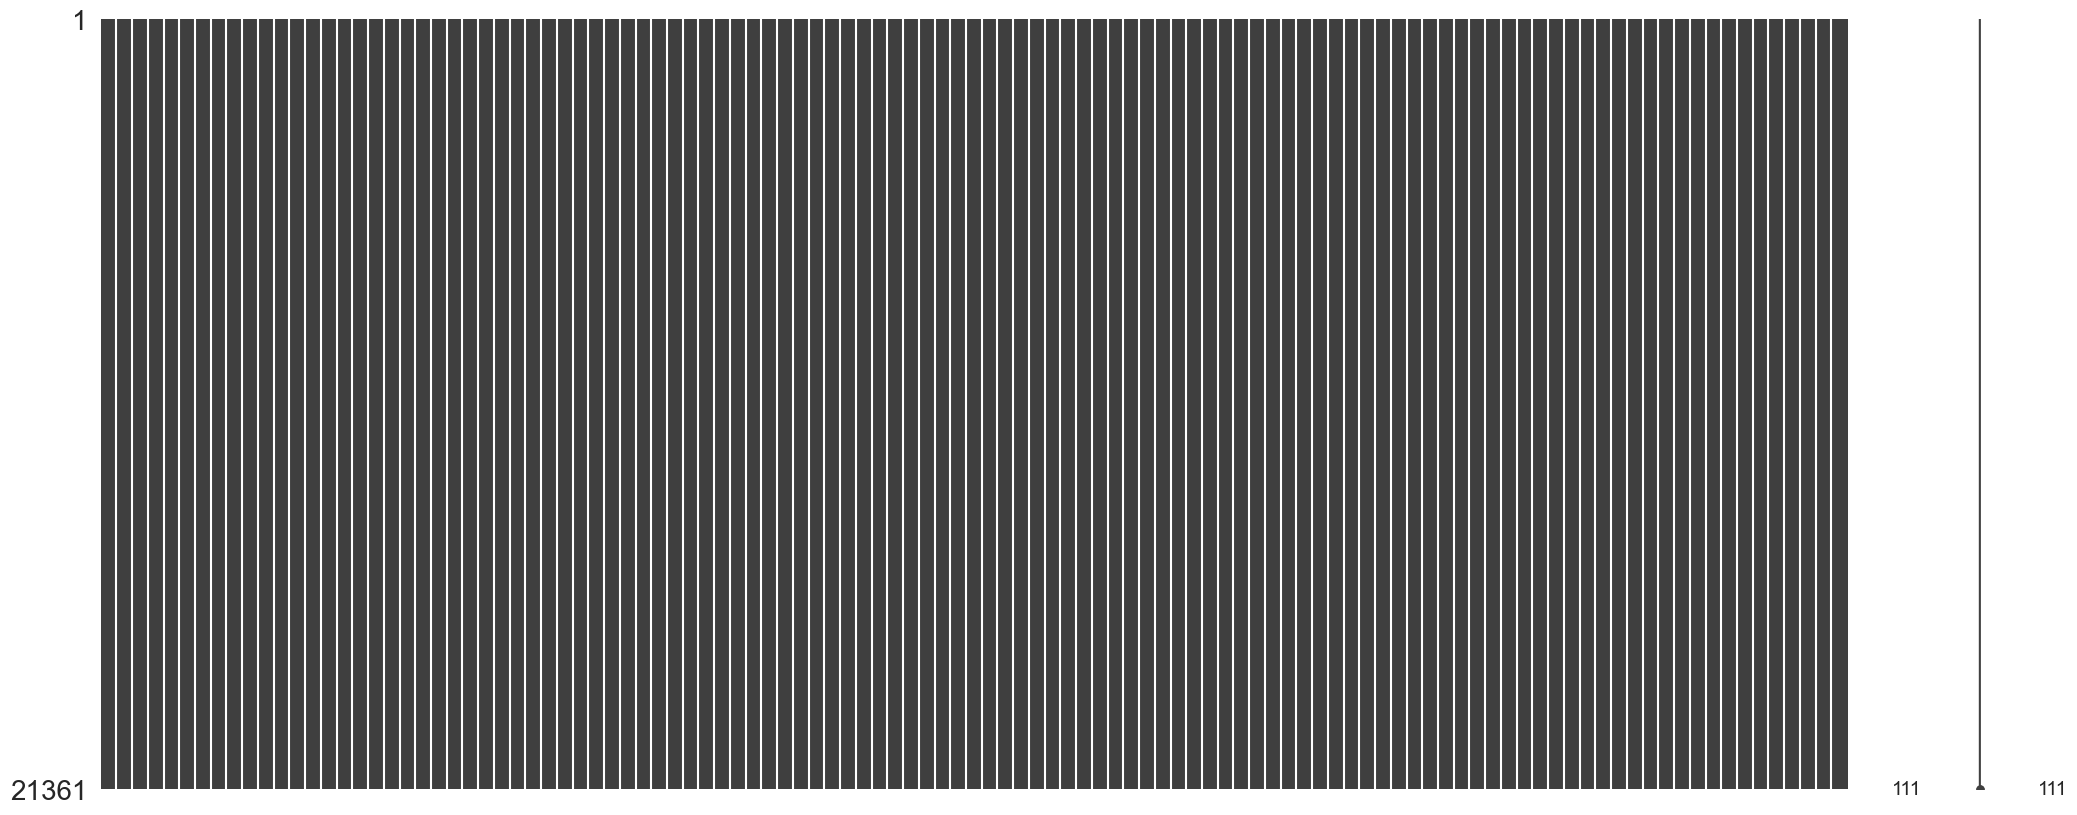

In [409]:
msno.matrix(matches_cleaned)

Now I wanted to read a table with team information and number of matches that team played in total. Therefore, I had to take valid matches ids from cleaned matches dataset and JOIN match and team datasets

In [410]:
""" Getting ids of all available matches after cleaning matches dataset """
valid_matches_ids = list(matches_cleaned['id'].unique())
valid_matches_ids = "(" + str(valid_matches_ids)[1:-1] + ")"

In [411]:
sql = f'''SELECT country.name as country, COUNT(match.home_team_api_id) as num_matches, team.*
    FROM team
    LEFT JOIN match
        ON (team.team_api_id = match.home_team_api_id or team.team_api_id = match.away_team_api_id)
    LEFT JOIN country
        ON (country.id=match.league_id) 
    WHERE match.id IN {valid_matches_ids}
    GROUP BY team.team_api_id 
'''

teams = pd.read_sql(sql=sql, con=db)
teams = teams.sort_values(by="num_matches", ascending=False)
teams.head()

country  num_matches    id  team_api_id  team_fifa_api_id  \
184  England          301  3459         9825               1.0   
138  England          300  3462         8650               9.0   
273  England          300  3457        10260              11.0   
253  England          300  3472        10194            1806.0   
78   England          300  3475         8455               5.0   

        team_long_name team_short_name  
184            Arsenal             ARS  
138          Liverpool             LIV  
273  Manchester United             MUN  
253         Stoke City             STK  
78             Chelsea             CHE

We can see that this teams dataset have only team_fifa_api_id missing values but as I will only use team_api_id, we can skip these for now

In [412]:
""" Looking for teams null values"""
teams.isnull().sum()

country             0
num_matches         0
id                  0
team_api_id         0
team_fifa_api_id    6
team_long_name      0
team_short_name     0
dtype: int64

Now I read team_attributes values and check for its missing values. We can see that buildUpPlayDribbling is missing but as we also have buildUpPlayDribblingClass I will not consider this value

In [413]:
sql = '''SELECT *
         FROM team_attributes;'''
         
team_attributes = pd.read_sql(sql=sql, con=db)
team_attributes.head()

id  team_fifa_api_id  team_api_id                 date  buildUpPlaySpeed  \
0   1               434         9930  2010-02-22 00:00:00                60   
1   2               434         9930  2014-09-19 00:00:00                52   
2   3               434         9930  2015-09-10 00:00:00                47   
3   4                77         8485  2010-02-22 00:00:00                70   
4   5                77         8485  2011-02-22 00:00:00                47   

  buildUpPlaySpeedClass  buildUpPlayDribbling buildUpPlayDribblingClass  \
0              Balanced                   NaN                    Little   
1              Balanced                  48.0                    Normal   
2              Balanced                  41.0                    Normal   
3                  Fast                   NaN                    Little   
4              Balanced                   NaN                    Little   

   buildUpPlayPassing buildUpPlayPassingClass  ... chanceCreationShooting  \
0                  50                   Mixed  ...                     55   
1                  56                   Mixed  ...                     64   
2                  54                   Mixed  ...                     64   
3                  70                    Long  ...                     70   
4                  52                   Mixed  ...                     52   

   chanceCreationShootingClass chanceCreationPositioningClass  \
0                       Normal                      Organised   
1                       Normal                      Organised   
2                       Normal                      Organised   
3                         Lots                      Organised   
4                       Normal                      Organised   

   defencePressure defencePressureClass  defenceAggression  \
0               50               Medium                 55   
1               47               Medium                 44   
2               47               Medium                 44   
3               60               Medium                 70   
4               47               Medium                 47   

  defenceAggressionClass defenceTeamWidth  defenceTeamWidthClass  \
0                  Press               45                 Normal   
1                  Press               54                 Normal   
2                  Press               54                 Normal   
3                 Double               70                   Wide   
4                  Press               52                 Normal   

  defenceDefenderLineClass  
0                    Cover  
1                    Cover  
2                    Cover  
3                    Cover  
4                    Cover  

[5 rows x 25 columns]

In [414]:
""" Looking for team attributes missing values """
team_attributes.isnull().sum()

id                                  0
team_fifa_api_id                    0
team_api_id                         0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

We now have our finalised cleaned dataset which we will be able now to use for the EDA

In [415]:
df_matches = matches_cleaned
df_player_attributes = player_attr_cleaned
df_teams = teams
df_players = players

## Exploratory Data Analysis 

### League Analysis

First I decided to see what kind of leagues we have in our dataset. We can see that England has the largest number of matches played, then in goes France and Italy. The smallest number of matches exist in Poland league.

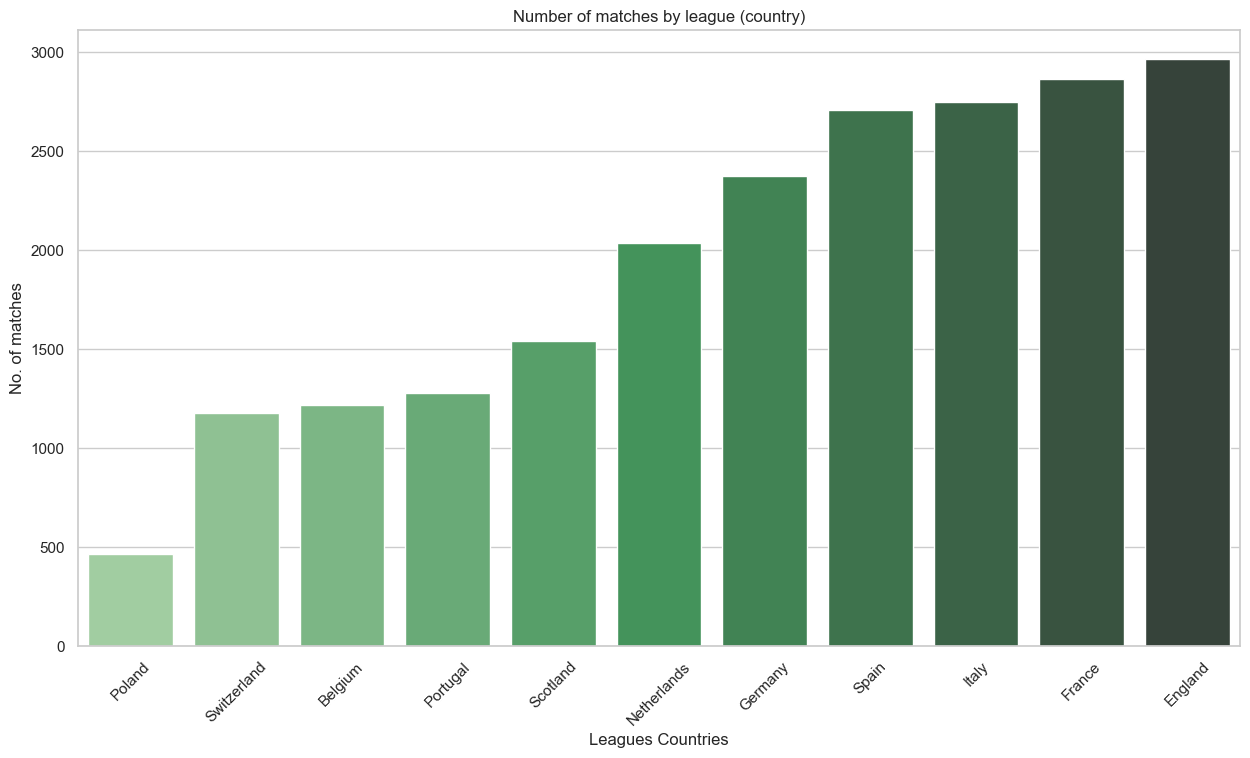

In [416]:
""" Plotting number of matches by each league (country) """
fig = plt.figure(figsize = (15, 8))
sns.set(style="whitegrid", color_codes=True)
 
data = df_matches.groupby("country_name").size()   
data = data.sort_values()

pal = sns.color_palette("Greens_d", len(data))
rank = data.argsort().argsort()   
rank = rank.sort_values(ascending=False)

sns.barplot(x=data.index, y=data, palette=np.array(pal[::-1])[rank])
  
plt.xlabel("Leagues Countries")
plt.ylabel("No. of matches")
plt.title("Number of matches by league (country)")
plt.xticks(rotation = 45) 
plt.show()

Now I wanted to see what are the average number of goals in each league over time.

In [417]:
""" Gathering each country's goals average over time """

seasons = df_matches['season'].unique()
countries = df_matches['country_name'].unique()

country_with_avg_goals = pd.DataFrame()
country_with_avg_goals['country'] = countries
 
away_goals_col = []
home_goals_col = []
all_goals_col = []
seasons_col = []
goals_diff_by_season_col = []
goals_diff_col = []
overall_home_goals = []
overall_away_goals = []

for country in countries:
    country_avg_away_goals = []
    country_avg_home_goals = [] 
    country_all_goals = []
    country_avg_goal_diff = []

    df_country = df_matches[df_matches['country_name'] == country]
    seasons = df_country['season'].unique()

    for season in seasons:   
        home_goals = df_country[df_country['season'] == season]['home_team_goal']
        avg_home_goals = sum(home_goals) / len(home_goals)
        country_avg_home_goals.append(avg_home_goals)

        away_goals = df_country[df_country['season'] == season]['away_team_goal']
        avg_away_goals = sum(away_goals) / len(away_goals) 
        country_avg_away_goals.append(avg_away_goals)

        avg_all_goals = (sum(home_goals) + sum(away_goals)) / (len(home_goals) + len(away_goals))
        country_all_goals.append(avg_all_goals)

        avg_goal_diff = avg_home_goals - avg_away_goals
        country_avg_goal_diff.append(avg_goal_diff)
 
    away_goals_col.append(country_avg_away_goals)
    home_goals_col.append(country_avg_home_goals)
    all_goals_col.append(country_all_goals)
    seasons_col.append(seasons)
    goals_diff_by_season_col.append(country_avg_goal_diff)
    goals_diff_col.append(sum(country_avg_goal_diff) / len(country_avg_goal_diff))

    overall_home_goals.append(sum(country_avg_home_goals) / len(country_avg_home_goals))
    overall_away_goals.append(sum(country_avg_away_goals) / len(country_avg_away_goals))

country_with_avg_goals['home_goals'] = home_goals_col
country_with_avg_goals['away_goals'] = away_goals_col 
country_with_avg_goals['all_goals'] = all_goals_col 
country_with_avg_goals['seasons'] = seasons_col 
country_with_avg_goals['avg_goal_diff_by_season'] = goals_diff_by_season_col 
country_with_avg_goals['total_avg_goal_diff'] = goals_diff_col 
country_with_avg_goals['total_avg_home_goals'] = overall_home_goals 
country_with_avg_goals['total_avg_away_goals'] = overall_away_goals 
country_with_avg_goals.head()

country                                         home_goals  \
0  Belgium  [1.2105263157894737, 1.6090909090909091, 1.562...   
1  England  [1.4137931034482758, 1.67828418230563, 1.60762...   
2   France  [1.2972136222910218, 1.3801652892561984, 1.328...   
3  Germany  [1.7314049586776858, 1.521594684385382, 1.6578...   
4    Italy  [1.4890965732087227, 1.5660919540229885, 1.437...   

                                          away_goals  \
0  [0.8421052631578947, 1.1636363636363636, 1.046...   
1  [1.0862068965517242, 1.0589812332439679, 1.177...   
2  [0.9566563467492261, 0.9917355371900827, 0.988...   
3  [1.1942148760330578, 1.318936877076412, 1.2823...   
4  [1.0965732087227413, 1.0632183908045978, 1.08,...   

                                           all_goals  \
0  [1.0263157894736843, 1.3863636363636365, 1.304...   
1  [1.25, 1.3686327077747988, 1.3923705722070845,...   
2  [1.1269349845201238, 1.1859504132231404, 1.158...   
3  [1.462809917355372, 1.420265780730897, 1.47009...   
4  [1.2928348909657321, 1.3146551724137931, 1.258...   

                                             seasons  \
0  [2008/2009, 2009/2010, 2010/2011, 2011/2012, 2...   
1  [2008/2009, 2009/2010, 2010/2011, 2011/2012, 2...   
2  [2008/2009, 2009/2010, 2010/2011, 2011/2012, 2...   
3  [2008/2009, 2009/2010, 2010/2011, 2011/2012, 2...   
4  [2008/2009, 2009/2010, 2010/2011, 2011/2012, 2...   

                             avg_goal_diff_by_season  total_avg_goal_diff  \
0  [0.368421052631579, 0.44545454545454555, 0.515...             0.405008   
1  [0.3275862068965516, 0.6193029490616622, 0.430...             0.386743   
2  [0.3405572755417957, 0.38842975206611574, 0.33...             0.372803   
3  [0.5371900826446281, 0.20265780730896998, 0.37...             0.360405   
4  [0.39252336448598135, 0.5028735632183907, 0.35...             0.376180   

   total_avg_home_goals  total_avg_away_goals  
0              1.521942              1.116934  
1              1.546625              1.159882  
2              1.405848              1.033046  
3              1.633050              1.272646  
4              1.490834              1.114654

I plot average number of goals over time. We can see how these values are fluctuating so that can just indicate better or worse seasons for each league.

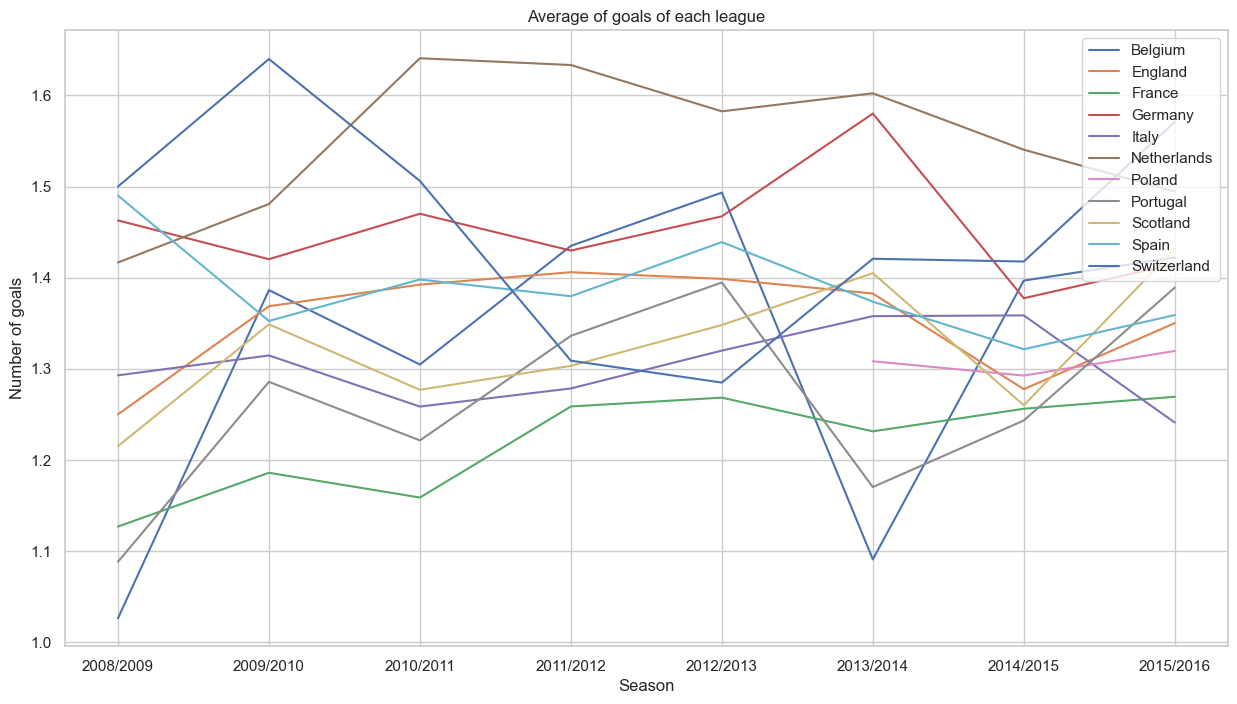

In [418]:
""" Plotting each league average of goals change overtime """
fig = plt.figure(figsize = (15, 8))
for country in countries:
    all_goals = list(country_with_avg_goals[country_with_avg_goals['country'] == country]['all_goals'])[0] 
    country_seasons = list(country_with_avg_goals[country_with_avg_goals['country'] == country]['seasons'])[0] 
        
    plt.plot(country_seasons, all_goals, label=country)
 
plt.legend(loc="upper right",  prop = {"size" : 11})

plt.title("Average of goals of each league")
plt.xlabel("Season")
plt.ylabel("Number of goals")

plt.show()

I wanted also to see whether there are such thing as home advantage. So I decided do compare average goals difference between home and away.

We can see that each league has these values changing overtime. One season the difference is higher and the other it's smaller. Nevertheless, we can see that France in almost all the seasons have the difference almost the same.

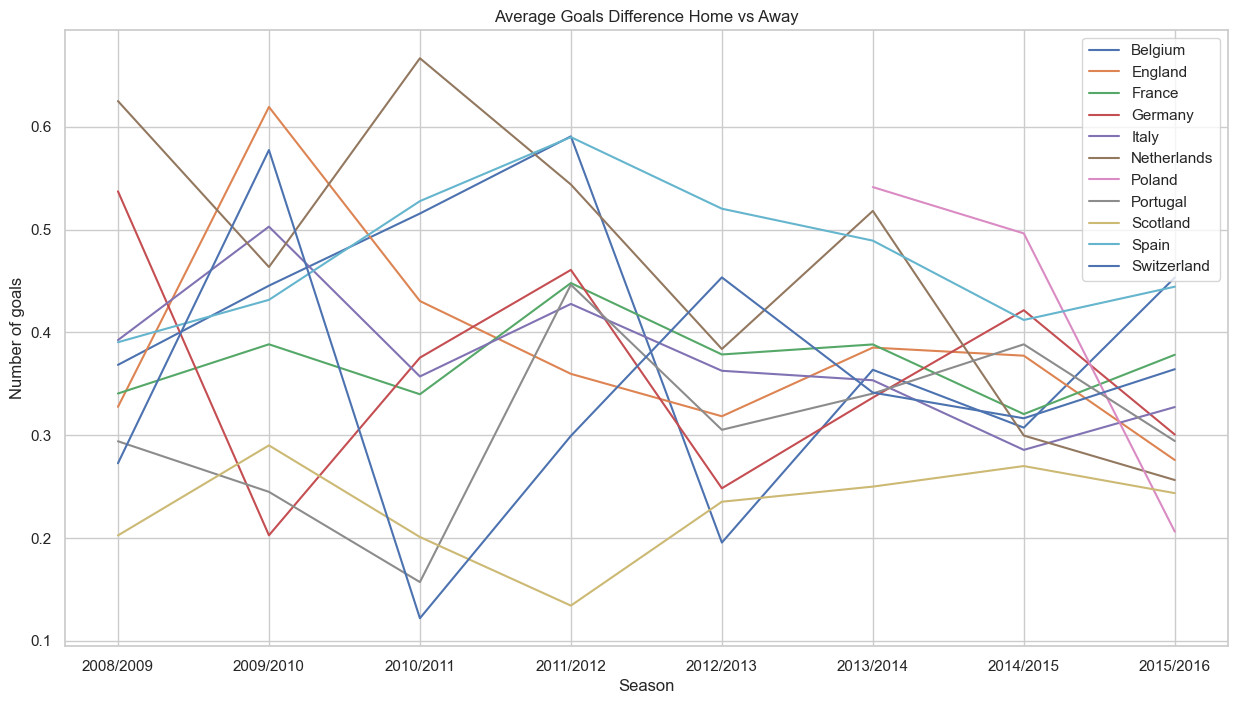

In [419]:
""" Plotting average goals difference between home and away goals """
fig = plt.figure(figsize = (15, 8))
for country in countries:
    all_goals = list(country_with_avg_goals[country_with_avg_goals['country'] == country]['avg_goal_diff_by_season'])[0] 
    country_seasons = list(country_with_avg_goals[country_with_avg_goals['country'] == country]['seasons'])[0] 
        
    plt.plot(country_seasons, all_goals, label=country)
 
plt.legend(loc="upper right",  prop = {"size" : 11})

plt.title("Average Goals Difference Home vs Away")
plt.xlabel("Season")
plt.ylabel("Number of goals")

plt.show()

We can see the largest average home and away goal difference in Spain, Netherlands and Poland leagues. And the lowest one is in Scotland and Portugal.

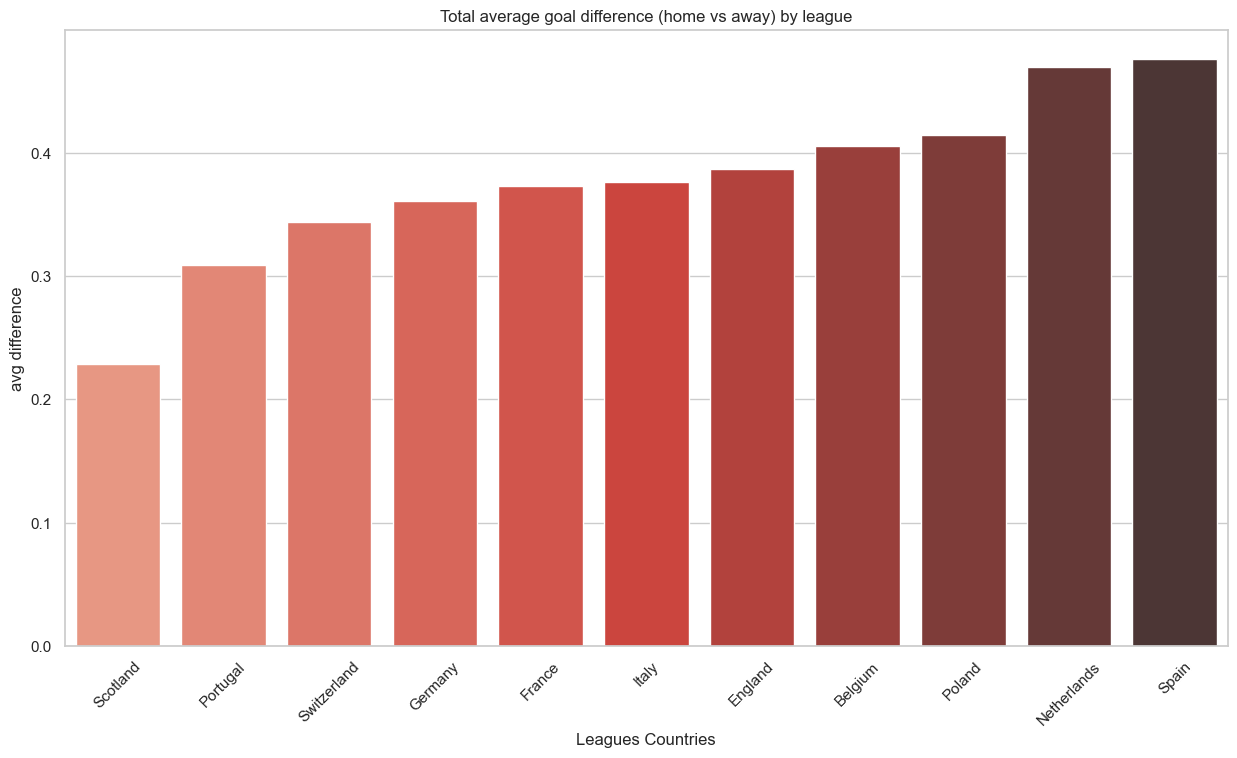

In [420]:
""" Plotting average goal difference between home and away goals by league """
fig = plt.figure(figsize = (15, 8))
sns.set(style="whitegrid", color_codes=True)
 
countries = list(country_with_avg_goals['country'])
total_avg_goal_diff = list(country_with_avg_goals['total_avg_goal_diff'])
data = {countries[i]: total_avg_goal_diff[i] for i in range(len(countries))}
data = dict(sorted(data.items(), key=lambda x:x[1]))

pal = sns.color_palette("Reds_d", len(data))
rank = rank.sort_values(ascending=False)

sns.barplot(x=list(data.keys()), y=list(data.values()), palette=np.array(pal[::-1])[rank])
  
plt.xlabel("Leagues Countries")
plt.ylabel("avg difference")
plt.title("Total average goal difference (home vs away) by league")
plt.xticks(rotation = 45) 
plt.show()

The highest average home goals were scored by the Netherlands, Germany and Switzerland and the lowest by France and Poland.

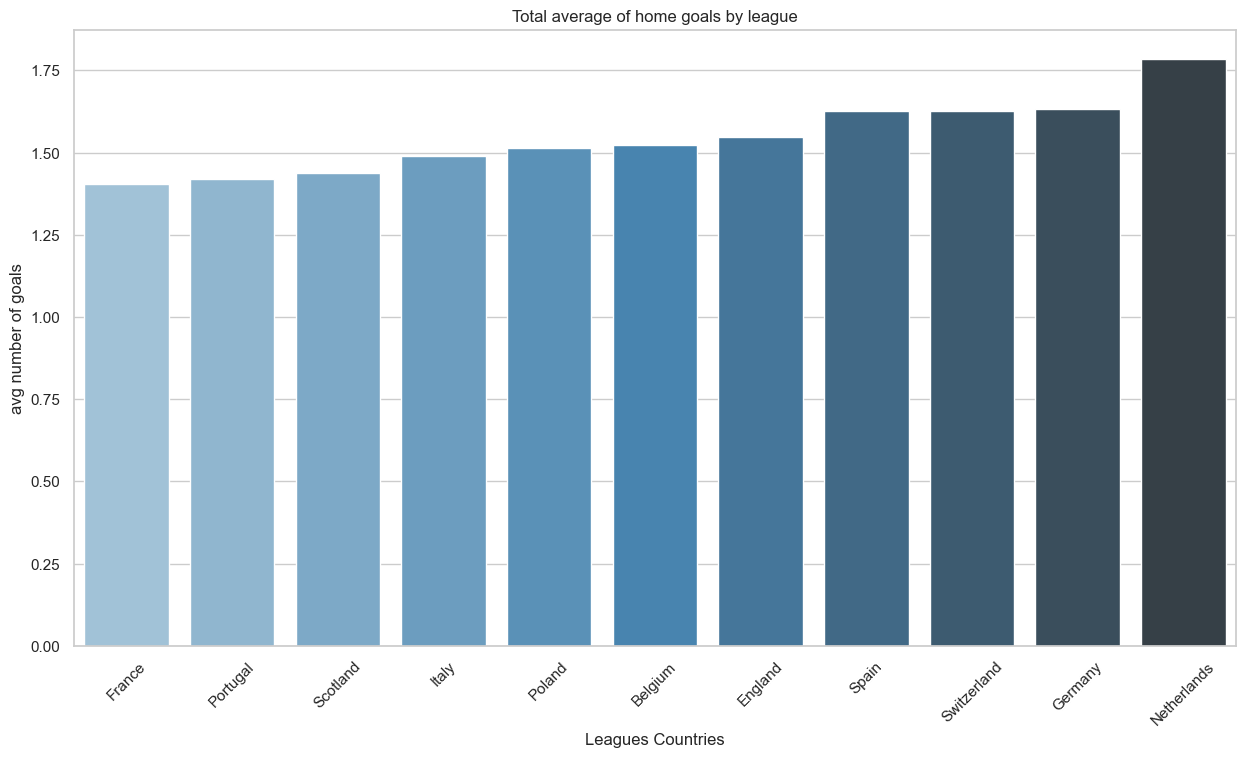

In [421]:
""" Plotting average of home goals by league"""
fig = plt.figure(figsize = (15, 8))
sns.set(style="whitegrid", color_codes=True)
 
countries = list(country_with_avg_goals['country'])
total_avg_goal_diff = list(country_with_avg_goals['total_avg_home_goals'])
data = {countries[i]: total_avg_goal_diff[i] for i in range(len(countries))}
data = dict(sorted(data.items(), key=lambda x:x[1]))

pal = sns.color_palette("Blues_d", len(data))
rank = rank.sort_values(ascending=False)

sns.barplot(x=list(data.keys()), y=list(data.values()), palette=np.array(pal[::-1])[rank])
  
plt.xlabel("Leagues Countries")
plt.ylabel("avg number of goals")
plt.title("Total average of home goals by league")
plt.xticks(rotation = 45) 
plt.show()

The highest average away goals were scored by the Netherlands, Germany and Switzerland and the lowest by France and Poland.

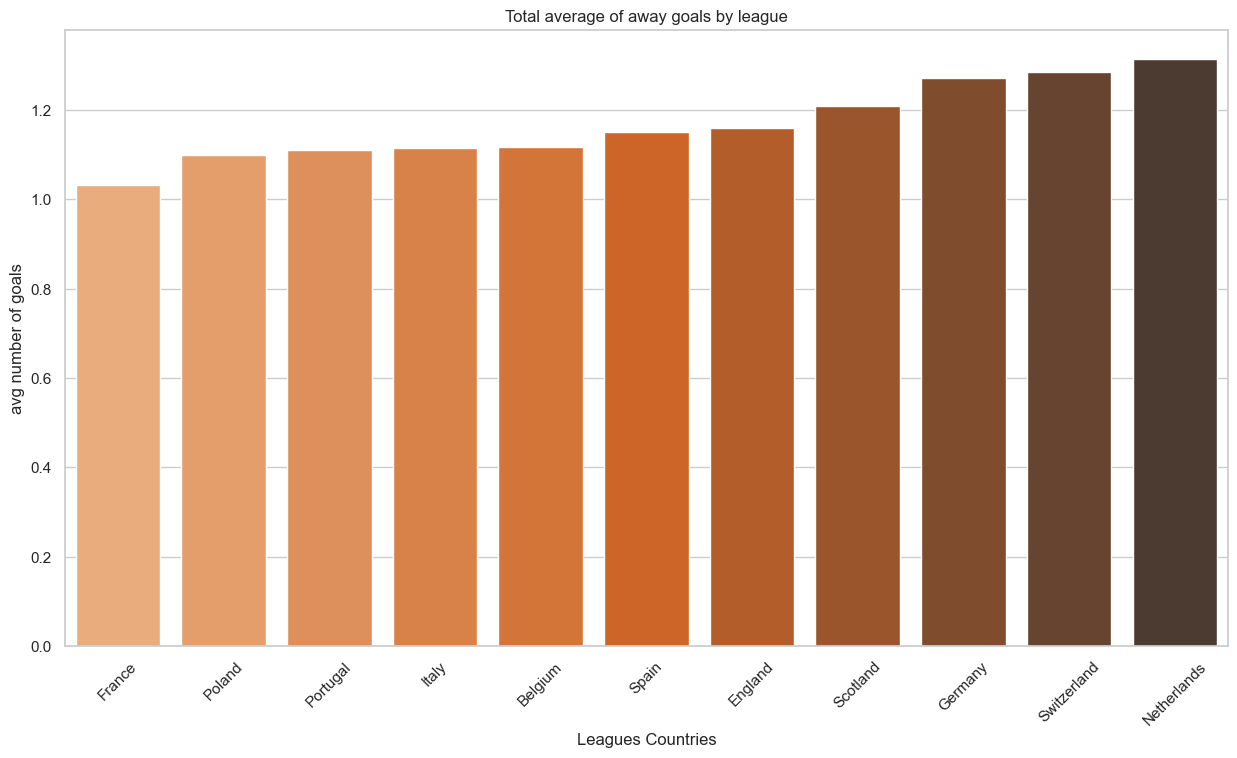

In [422]:
""" Plotting average of away goals by league"""
fig = plt.figure(figsize = (15, 8))
sns.set(style="whitegrid", color_codes=True)
 
countries = list(country_with_avg_goals['country'])
total_avg_goal_diff = list(country_with_avg_goals['total_avg_away_goals'])
data = {countries[i]: total_avg_goal_diff[i] for i in range(len(countries))}
data = dict(sorted(data.items(), key=lambda x:x[1]))

pal = sns.color_palette("Oranges_d", len(data))
rank = rank.sort_values(ascending=False)

sns.barplot(x=list(data.keys()), y=list(data.values()), palette=np.array(pal[::-1])[rank])
  
plt.xlabel("Leagues Countries")
plt.ylabel("avg number of goals")
plt.title("Total average of away goals by league")
plt.xticks(rotation = 45) 
plt.show()

We can see that for all of the leagues more goals were score when playing as the home team

<Figure size 1500x800 with 0 Axes>

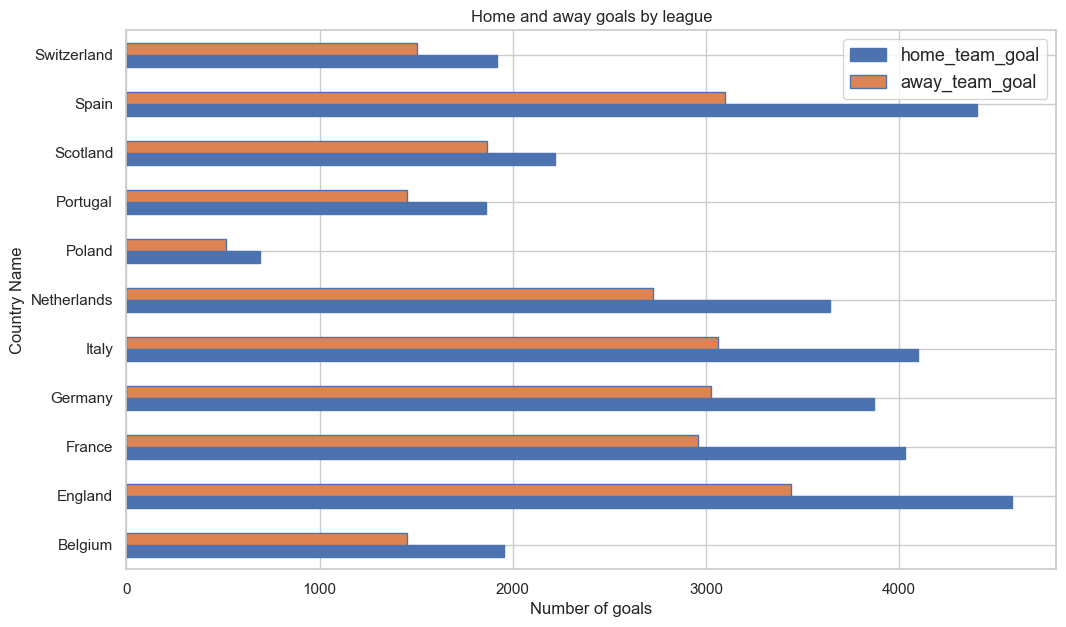

In [423]:
""" Difference number of goals between away and home goals for different countries """
fig = plt.figure(figsize = (15, 8))
df_matches.groupby("country_name").agg({"home_team_goal":"sum","away_team_goal":"sum"}).plot(kind="barh",
                                                                                 figsize = (12,7),
                                                                                 edgecolor = "b"
                                                                                )
plt.title("Home and away goals by league")
plt.legend(loc = "best" , prop = {"size" : 13})
plt.xlabel("Number of goals")
plt.ylabel("Country Name")
plt.show()

We can see the same in the histogram.

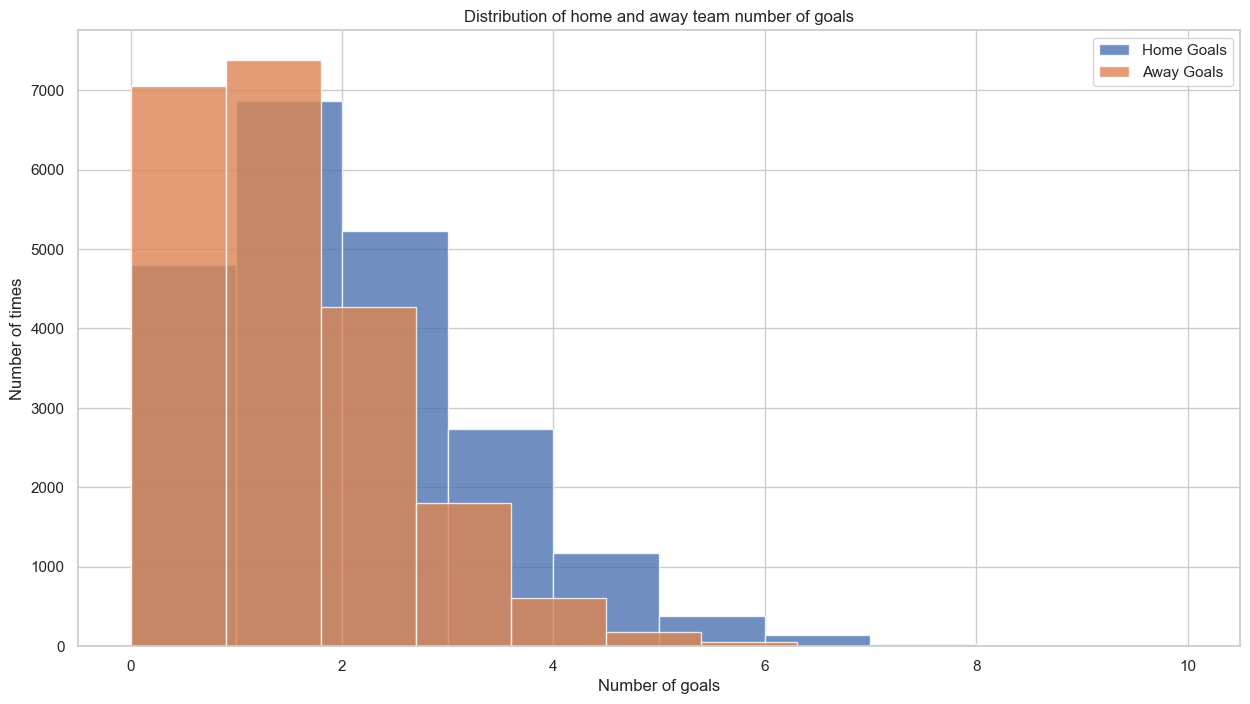

In [424]:
""" Plotting distribution of home and away team number of goals """
fig = plt.figure(figsize = (15, 8))
plt.hist(df_matches['home_team_goal'], alpha=0.8, label="Home Goals")
plt.hist(df_matches['away_team_goal'], alpha=0.8, label="Away Goals")
plt.title("Distribution of home and away team number of goals")
plt.xlabel("Number of goals")
plt.ylabel("Number of times")
plt.legend(loc="upper right",  prop = {"size" : 11})
plt.show()

### Team Analysis

Now we begin the team analysis. I wanted to see which league has the largest number of teams.

We can see that France, England and Spain are the top 3 leagues with highest number of teams. Switzerland has the lowest number of teams.

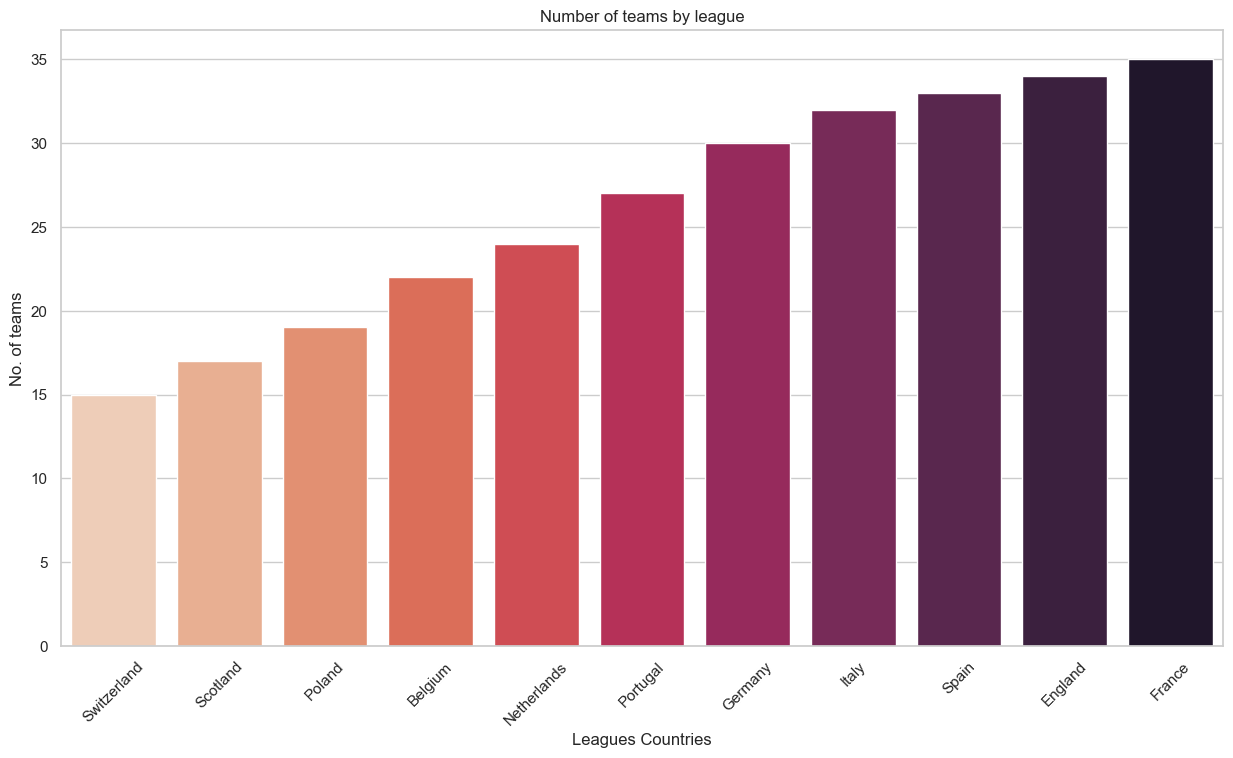

In [425]:
""" Plotting number of teams by each country """
fig = plt.figure(figsize = (15, 8))
sns.set(style="whitegrid", color_codes=True)
 
data = df_teams.groupby("country").size()   
data = data.sort_values()

pal = sns.color_palette("rocket", len(data))
rank = data.argsort().argsort()   
rank = rank.sort_values(ascending=True)

sns.barplot(x=data.index, y=data, palette=np.array(pal[::-1])[rank])
  
plt.xlabel("Leagues Countries")
plt.ylabel("No. of teams")
plt.title("Number of teams by league")
plt.xticks(rotation = 45) 
plt.show()

Teams with largest number of matches won were:
* Real Madrid
* FC Barcelona
* Celtic

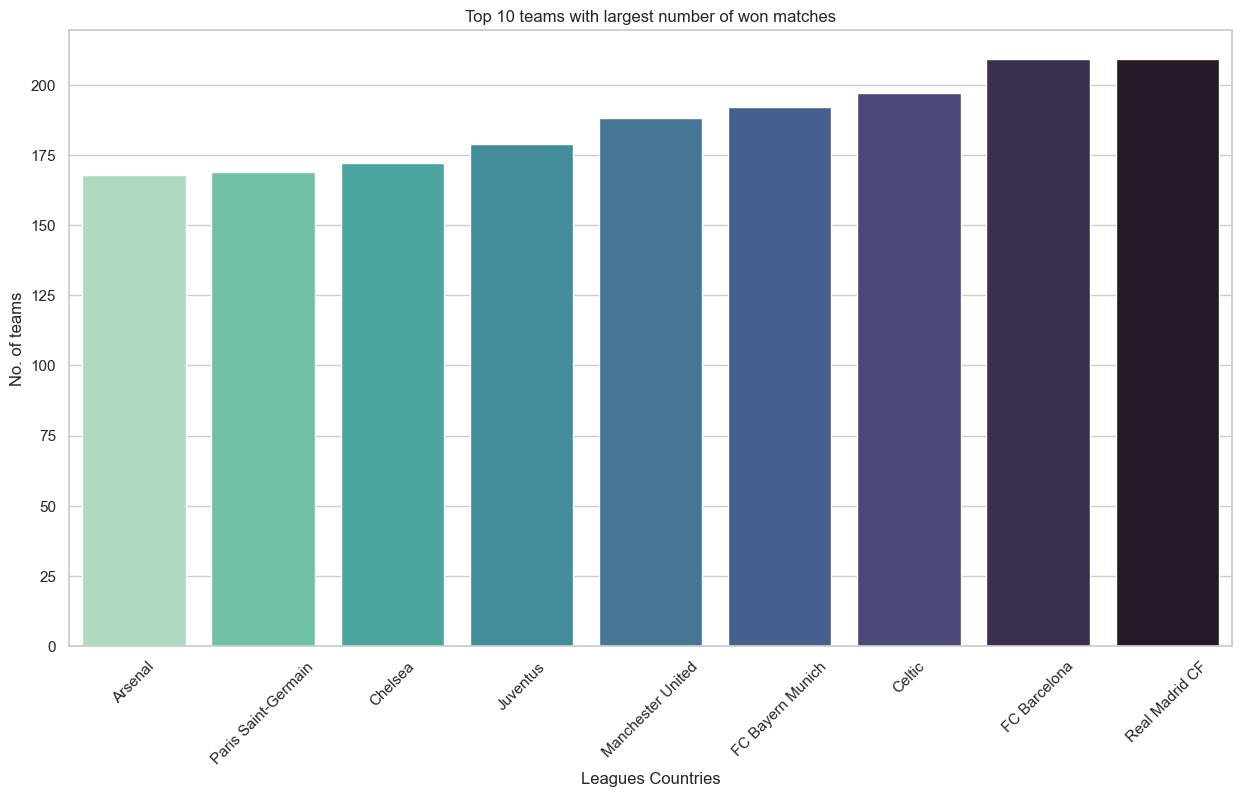

In [426]:
""" Plotting Top 10 teams with largest number of won matches """

fig = plt.figure(figsize = (15, 8))
sns.set(style="whitegrid", color_codes=True)
 
data = df_matches.groupby("winner_team_name").size()
data = data.sort_values(ascending=False)[1:10]
data = data.sort_values()
 
pal = sns.color_palette("mako", len(data))
rank = data.argsort().argsort()   
rank = rank.sort_values(ascending=True)

sns.barplot(x=data.index, y=data, palette=np.array(pal[::-1])[rank])
  
plt.xlabel("Leagues Countries")
plt.ylabel("No. of teams")
plt.title("Top 10 teams with largest number of won matches")
plt.xticks(rotation = 45) 
plt.show()

In [427]:
""" Merging teams with matches tables for future exploration to have team names """
merge_teams = df_teams.copy()
merge_teams.rename(columns={"team_long_name": "away_team_name"}, inplace=True)
df = pd.merge(df_matches, merge_teams[['team_api_id', 'away_team_name']], how="left", right_on='team_api_id', left_on="away_team_api_id")
merge_teams.rename(columns={"away_team_name": "home_team_name"}, inplace=True)
df_matches = pd.merge(df, merge_teams[['team_api_id', 'home_team_name']], how="left", right_on='team_api_id', left_on="home_team_api_id")

In [428]:
""" Calculating the winning rate of each team = total matches won / all matches"""
teams = list(set(df_matches["home_team_name"]) | set(df_matches["away_team_name"]))
winning_rate = {}
 
for team in teams:
    total_matches_won = len(df_matches[df_matches['winner_team_name'] == team])
    total_matches = len(df_matches[df_matches['home_team_name'] == team]) + len(df_matches[df_matches['away_team_name'] == team])
    winning_rate[team] = total_matches_won / total_matches

winning_rate = dict(sorted(winning_rate.items(), key=lambda item: item[1], reverse=True))

Teams with highest winning rate were:
* FC Barcelona
* SL Benfica
* Real Madrid CF 

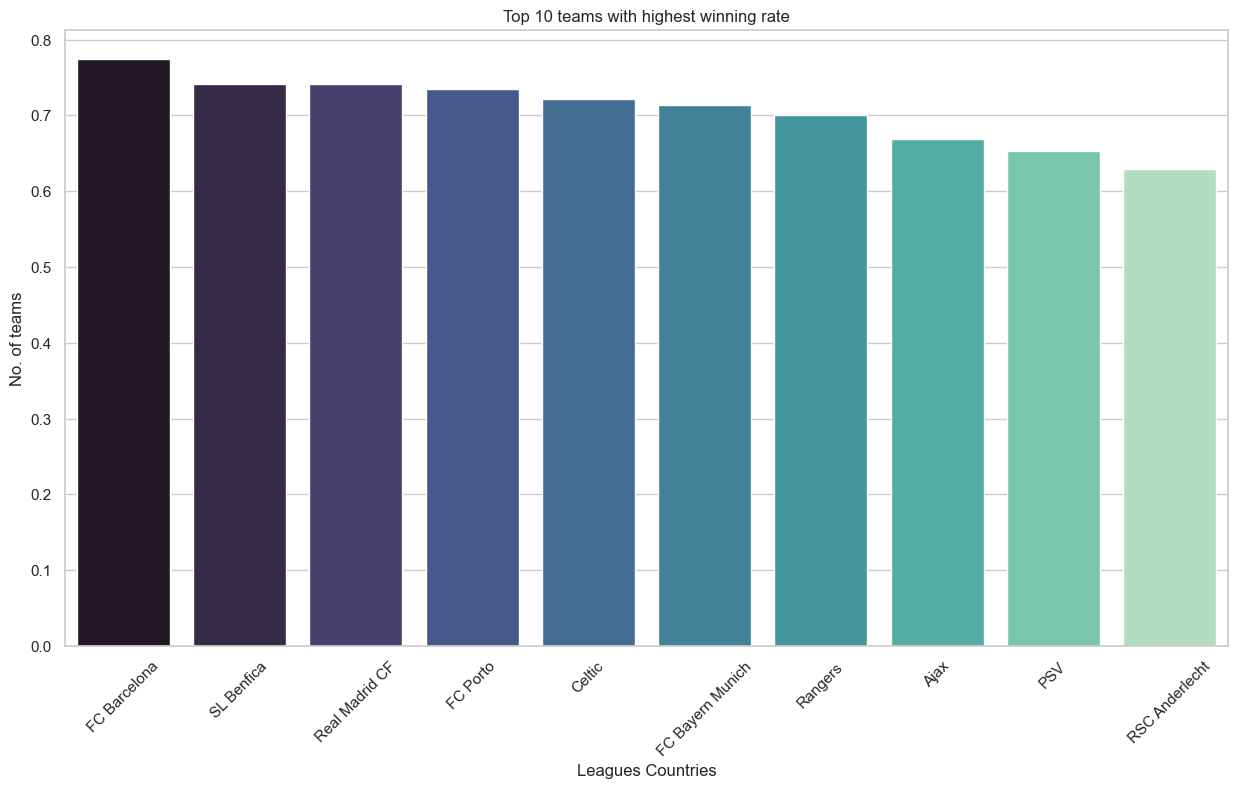

In [429]:
""" Plotting teams with highest winning rate in total """
fig = plt.figure(figsize = (15, 8))
sns.set(style="whitegrid", color_codes=True)
  
pal = sns.color_palette("mako", len(winning_rate)) 

sns.barplot(x=list(winning_rate.keys())[:10], y=list(winning_rate.values())[:10], palette='mako')
  
plt.xlabel("Leagues Countries")
plt.ylabel("No. of teams")
plt.title("Top 10 teams with highest winning rate")
plt.xticks(rotation = 45) 
plt.show()

Teams that scored most of the home goals were:
* Real Madrid CF
* FC Barcelona
* FC Bayern Munich

Teams that scored most of the away goals were:
* Real Madrid CF
* FC Barcelona
* Celtic

Text(0.5, 1.0, 'top teams by away goals')

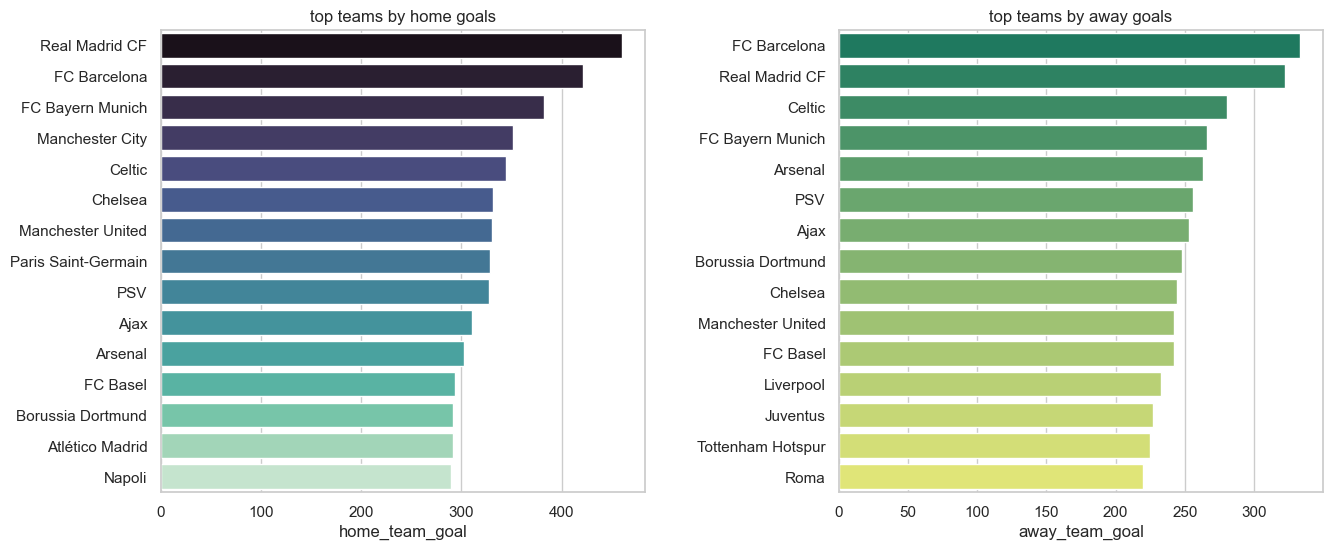

In [430]:
""" Plotting top teams by number of home goals and away goals """

h_t = df_matches.groupby("home_team_name")["home_team_goal"].sum().reset_index()
a_t = df_matches.groupby("away_team_name")["away_team_goal"].sum().reset_index()
h_t = h_t.sort_values(by="home_team_goal",ascending= False)
a_t = a_t.sort_values(by="away_team_goal",ascending= False)

plt.figure(figsize=(15,6))
plt.subplot(121)
ax = sns.barplot(y="home_team_name",x="home_team_goal",
                 data=h_t[:15], palette="mako",
                 linewidth = 1)
plt.ylabel('')
plt.title("top teams by home goals")
 
plt.subplot(122)

ax = sns.barplot(y="away_team_name",x="away_team_goal",
                 data=a_t[:15], palette="summer",
                linewidth = 1)
plt.ylabel("")
plt.subplots_adjust(wspace = .4)
plt.title("top teams by away goals")

Now, I wanted to see which team had one the largest number of matches by season.

In [431]:
""" Counting wins by season """
seasons = df_matches['season'].unique()
teams = df_teams['team_long_name'].unique()

df_wins_season = pd.DataFrame(columns=seasons)
df_wins_season['team'] = teams

for season in seasons:
    df_season = df_matches[df_matches['season'] == season]
    team_wins = []

    for team in teams:
        df_team = df_season[df_season['winner_team_name'] == team] 
        team_wins.append(len(df_team))

    df_wins_season[season] = team_wins
 
merge_teams = df_teams.copy()[["team_long_name", "country"]]
merge_teams.rename(columns={"team_long_name": "team"}, inplace=True)
df_wins_season = pd.merge(df_wins_season, merge_teams, how="left", on="team")

In [432]:
max_teams_matches_won = []
min_teams_matches_won = [] 

We can see that in Enland Premier League:
* The top first team between 2008 and 2013 was Manchester United.
* Then in 2013/2014 season Manchester city was the first one
* In 2014/2015 Chelsea
* In 2015/2016 Leicester City

Text(0.5, 1.02, 'Top 4 England teams over the years')

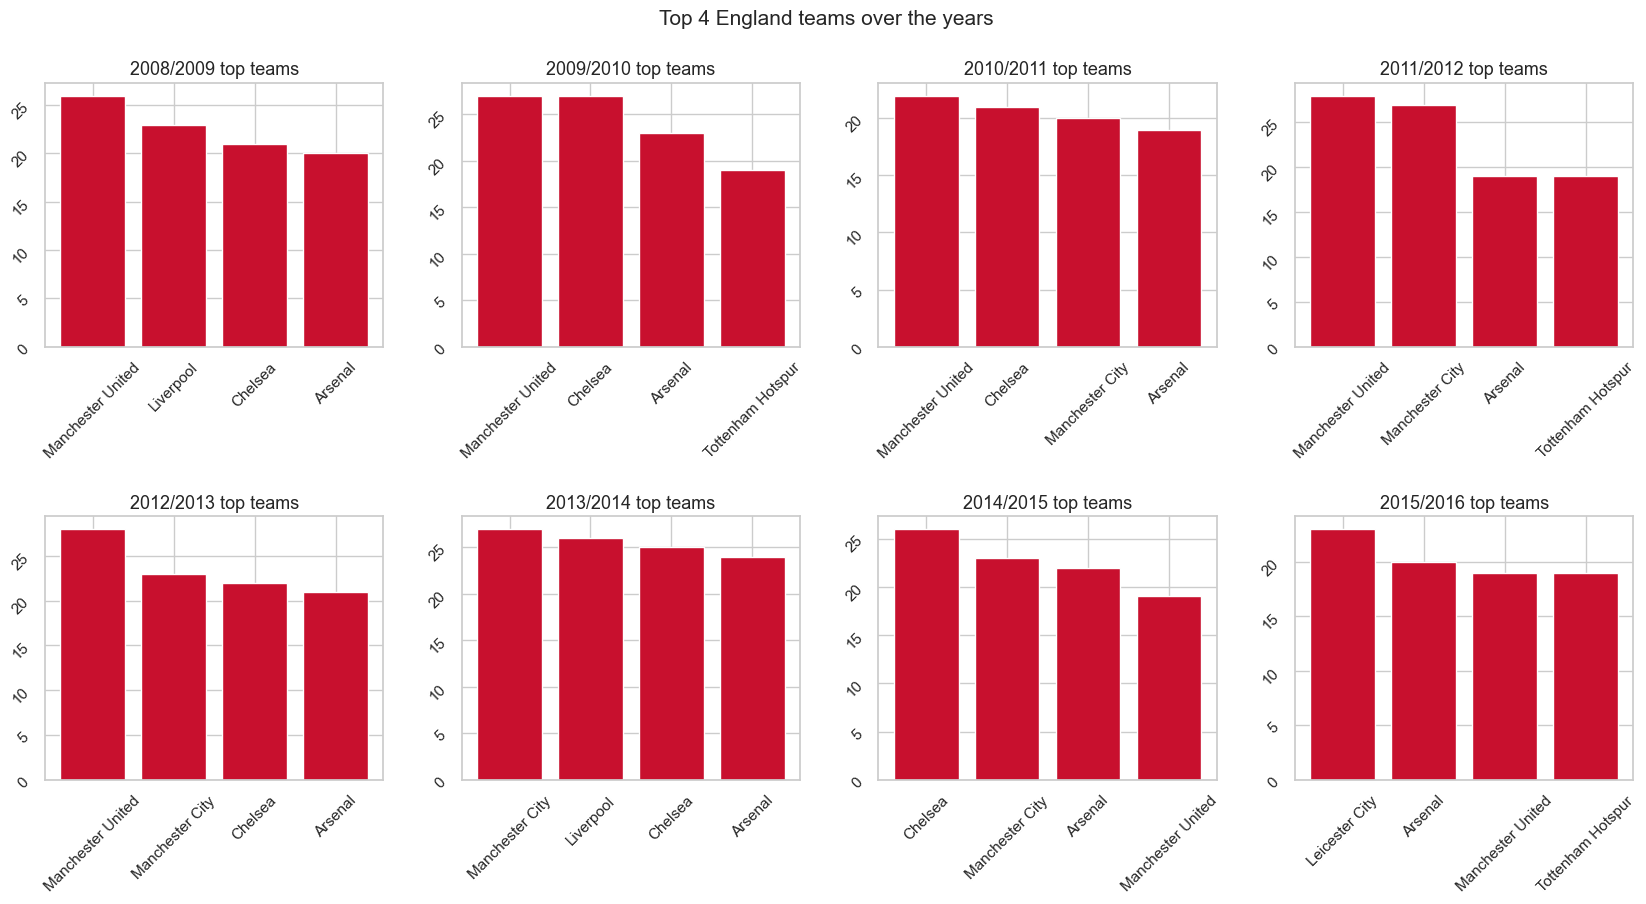

In [598]:
""" Plotting teams with max number of matches by season in England """

df_england_teams = df_wins_season[df_wins_season['country'] == 'England']
seasons = [col for col in df_england_teams.columns if "/" in col]

fig, axes = plt.subplots(2, 4, figsize=(17, 9))
i = 0
j = 0

for season in seasons:
  if i < 2:
    if j < 4: 
        max_vals = df_england_teams.nlargest(4, [season]) 
        min_vals = df_england_teams.nsmallest(4, [season]) 

        if season == "2015/2016":
          max_teams_matches_won.extend(list(max_vals['team']))
          min_teams_matches_won.extend(list(min_vals['team'])) 
    
        axes[i][j].bar(max_vals['team'], max_vals[season], color="#C8102E")
        axes[i][j].set_title(f"{season} top teams", fontsize=13)
        axes[i][j].tick_params(labelrotation=45) 
      
        j+=1
        if j == 4:
            i+=1
            j=0

fig.tight_layout(pad=2)
fig.suptitle("Top 4 England teams over the years", y=1.02, fontsize=15) 

Top 5 England teams by home goals were
* Manchester City
* Chelsea
* Manchester United
* Arsenal
* Liverpool

Top 5 England teams by away goals were
* Arsenal
* Chelsea
* Manchester United
* Liverpool
* Tottenham Hotspur

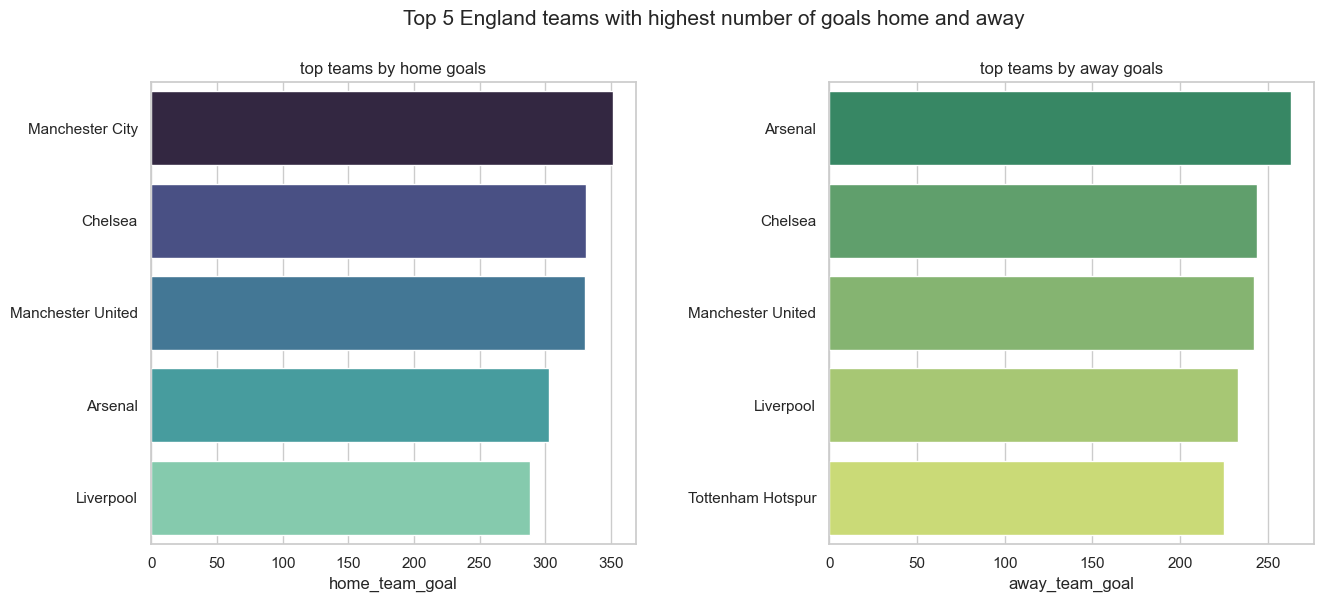

In [434]:
""" Plotting top 5 England teams with highest number of home and away goals """

df_england = df_matches[df_matches['country_name'] == 'England']

h_t = df_england.groupby("home_team_name")["home_team_goal"].sum().reset_index()
a_t = df_england.groupby("away_team_name")["away_team_goal"].sum().reset_index()
h_t = h_t.sort_values(by="home_team_goal",ascending= False)
a_t = a_t.sort_values(by="away_team_goal",ascending= False)

plt.figure(figsize=(15,6))
plt.subplot(121)
ax = sns.barplot(y="home_team_name",x="home_team_goal",
                 data=h_t[:5], palette="mako",
                 linewidth = 1)
plt.ylabel('')
plt.title("top teams by home goals")
 
plt.subplot(122)

ax = sns.barplot(y="away_team_name",x="away_team_goal",
                 data=a_t[:5], palette="summer",
                linewidth = 1)
plt.ylabel("")
plt.subplots_adjust(wspace = .4)
plt.title("top teams by away goals")

plt.suptitle("Top 5 England teams with highest number of goals home and away", y=1, fontsize=15)
plt.show()

We can see that in France Ligue 1:
* The top first team between 2012 and 2016 was Paris Saint-Germain 


Text(0.5, 1.02, 'Top 4 France teams over the years')

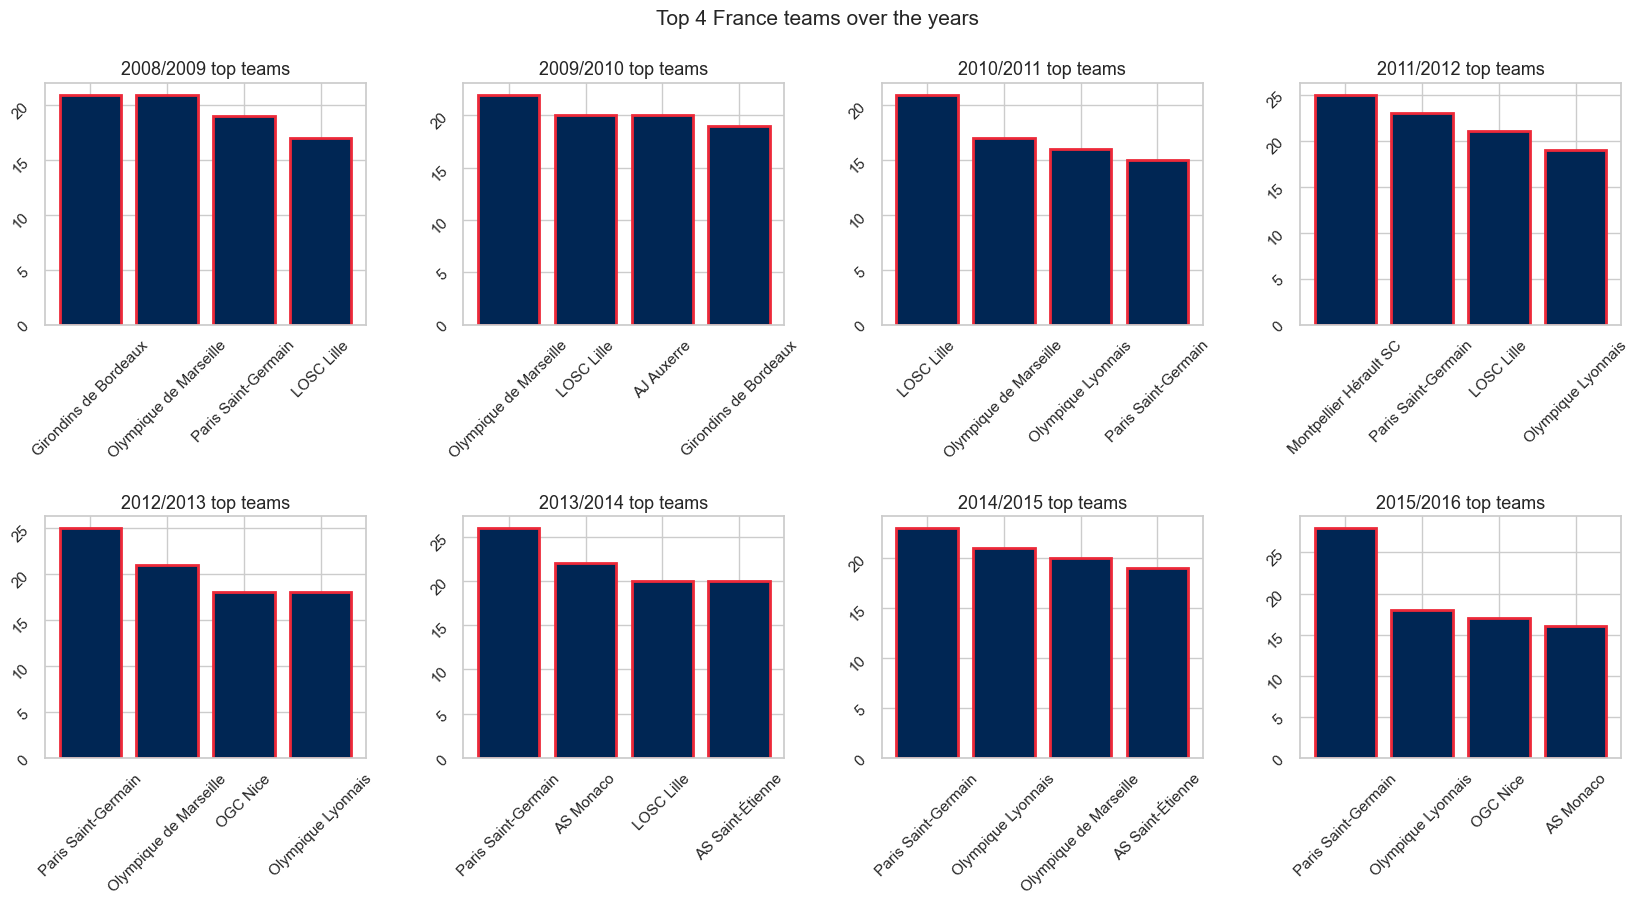

In [435]:
""" Plotting teams with max number of matches by season in France """

df_france_teams = df_wins_season[df_wins_season['country'] == 'France']
seasons = [col for col in df_france_teams.columns if "/" in col]

fig, axes = plt.subplots(2, 4, figsize=(17, 9))
i = 0
j = 0

for season in seasons:
  if i < 2:
    if j < 4: 
        max_vals = df_france_teams.nlargest(4, [season]) 
        min_vals = df_france_teams.nsmallest(4, [season]) 

        if season == "2015/2016":
          max_teams_matches_won.extend(list(max_vals['team']))
          min_teams_matches_won.extend(list(min_vals['team'])) 
    
        axes[i][j].bar(max_vals['team'], max_vals[season], color='#002654', edgecolor='#ED2939',linewidth=2)
        axes[i][j].set_title(f"{season} top teams", fontsize=13)
        axes[i][j].tick_params(labelrotation=45) 
      
        j+=1
        if j == 4:
            i+=1
            j=0

fig.tight_layout(pad=2)
fig.suptitle("Top 4 France teams over the years", y=1.02, fontsize=15)

Top 5 France teams by home goals were
* Paris Saint-Germain
* Olympique Lyonnais
* LOSC Lille
* Olympique de Marseille
* Girondins de Bordeaux

Top 5 France teams by away goals were
* Paris Saint-Germain
* Olympique de Marseille
* Olympique Lyonnais
* LOSC Lille
* Girondins de Bordeaux

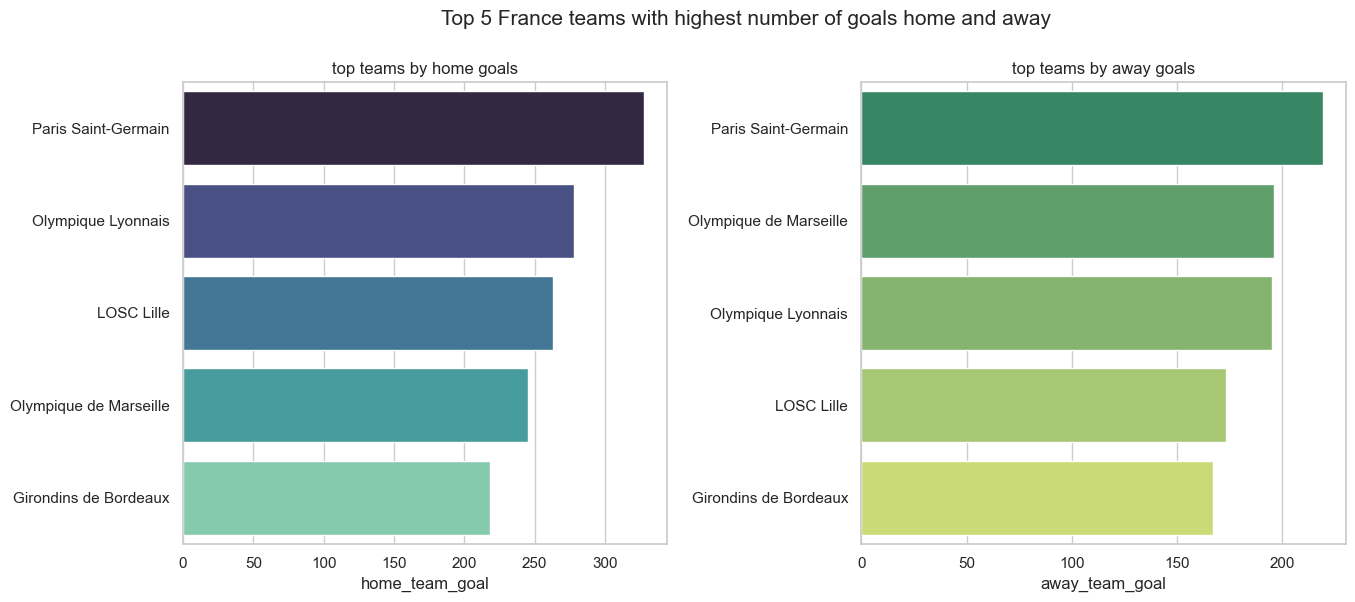

In [436]:
""" Plotting top 5 France teams with highest number of home and away goals """ 

df_france = df_matches[df_matches['country_name'] == 'France']

h_t = df_france.groupby("home_team_name")["home_team_goal"].sum().reset_index()
a_t = df_france.groupby("away_team_name")["away_team_goal"].sum().reset_index()
h_t = h_t.sort_values(by="home_team_goal",ascending= False)
a_t = a_t.sort_values(by="away_team_goal",ascending= False)

plt.figure(figsize=(15,6))
plt.subplot(121)
ax = sns.barplot(y="home_team_name",x="home_team_goal",
                 data=h_t[:5], palette="mako",
                 linewidth = 1)
plt.ylabel('')
plt.title("top teams by home goals")
 
plt.subplot(122)

ax = sns.barplot(y="away_team_name",x="away_team_goal",
                 data=a_t[:5], palette="summer",
                linewidth = 1)
plt.ylabel("")
plt.subplots_adjust(wspace = .4)
plt.title("top teams by away goals")

plt.suptitle("Top 5 France teams with highest number of goals home and away", y=1, fontsize=15)
plt.show()

We can see that in Italy Serie A:
* The top first team between 2012 and 2016 was Juventus


Text(0.5, 1.02, 'Top 4 Italy teams over the years')

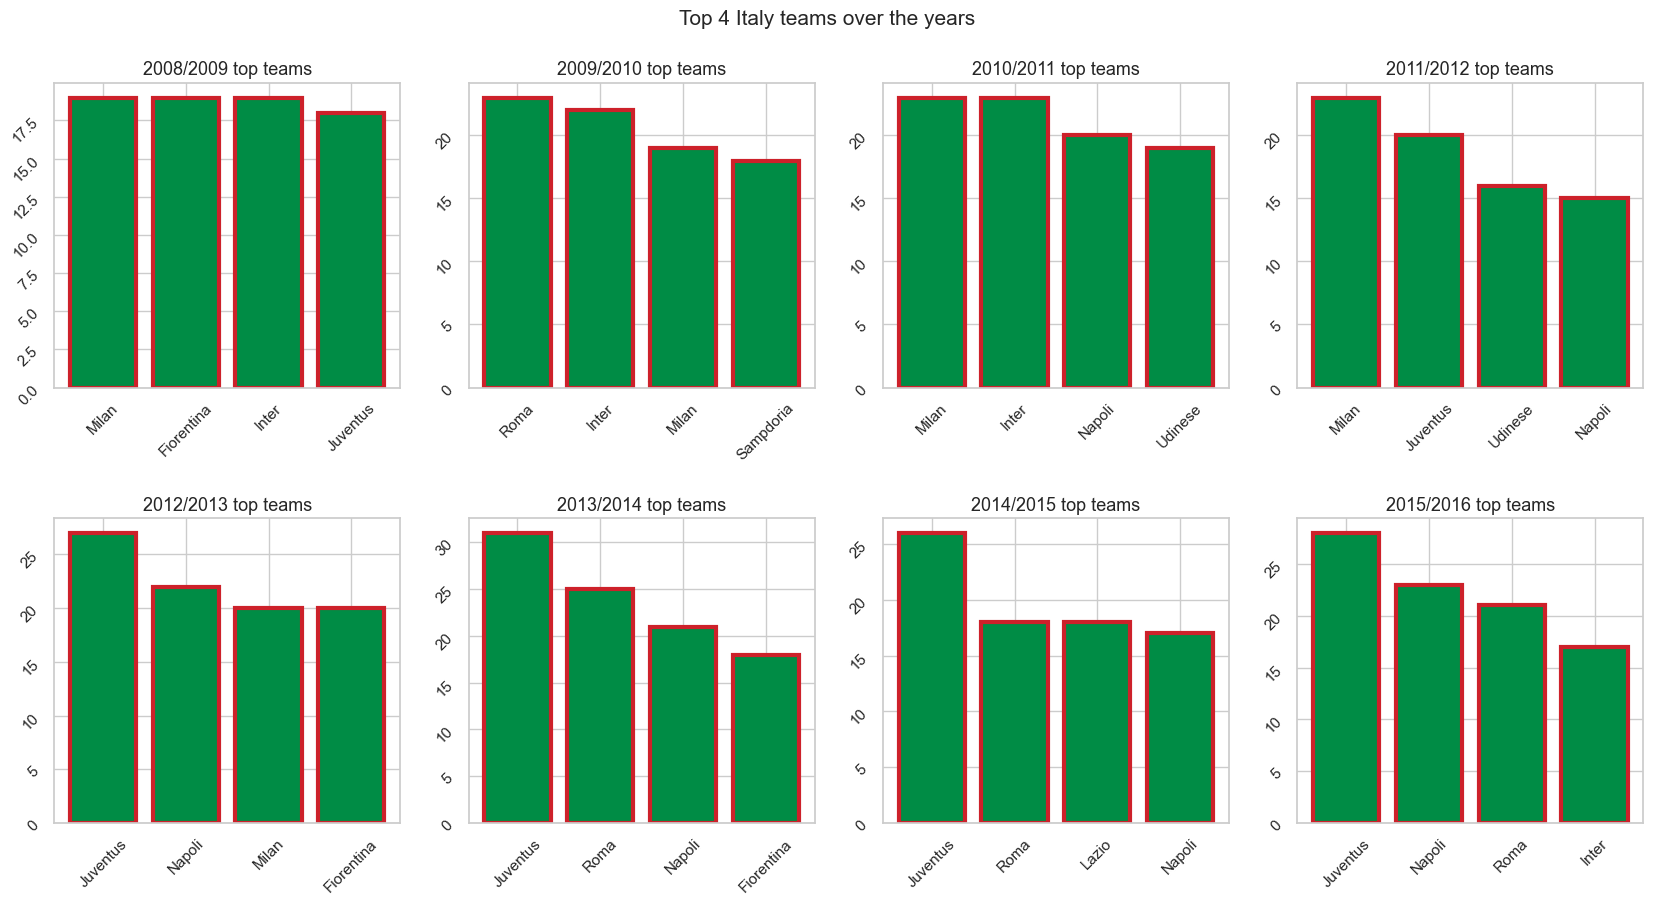

In [437]:
""" Plotting teams with max number of matches by season in Italy """

df_italy_teams = df_wins_season[df_wins_season['country'] == 'Italy']
seasons = [col for col in df_italy_teams.columns if "/" in col]

fig, axes = plt.subplots(2, 4, figsize=(17, 9))
i = 0
j = 0

for season in seasons:
  if i < 2:
    if j < 4: 
        max_vals = df_italy_teams.nlargest(4, [season]) 
        min_vals = df_italy_teams.nsmallest(4, [season]) 

        if season == "2015/2016":
          max_teams_matches_won.extend(list(max_vals['team']))
          min_teams_matches_won.extend(list(min_vals['team'])) 
    
        axes[i][j].bar(max_vals['team'], max_vals[season], color='#008C45', edgecolor='#CD212A',linewidth=3)
        axes[i][j].set_title(f"{season} top teams", fontsize=13)
        axes[i][j].tick_params(labelrotation=45) 
      
        j+=1
        if j == 4:
            i+=1
            j=0

fig.tight_layout(pad=2)
fig.suptitle("Top 4 Italy teams over the years", y=1.02, fontsize=15) 

Top 5 Italy teams by home goals were
* Napoli
* Juventus
* Roma
* Milan
* Inter

Top 5 France teams by away goals were
* Juventus
* Roma
* Milan
* Inter
* Napoli

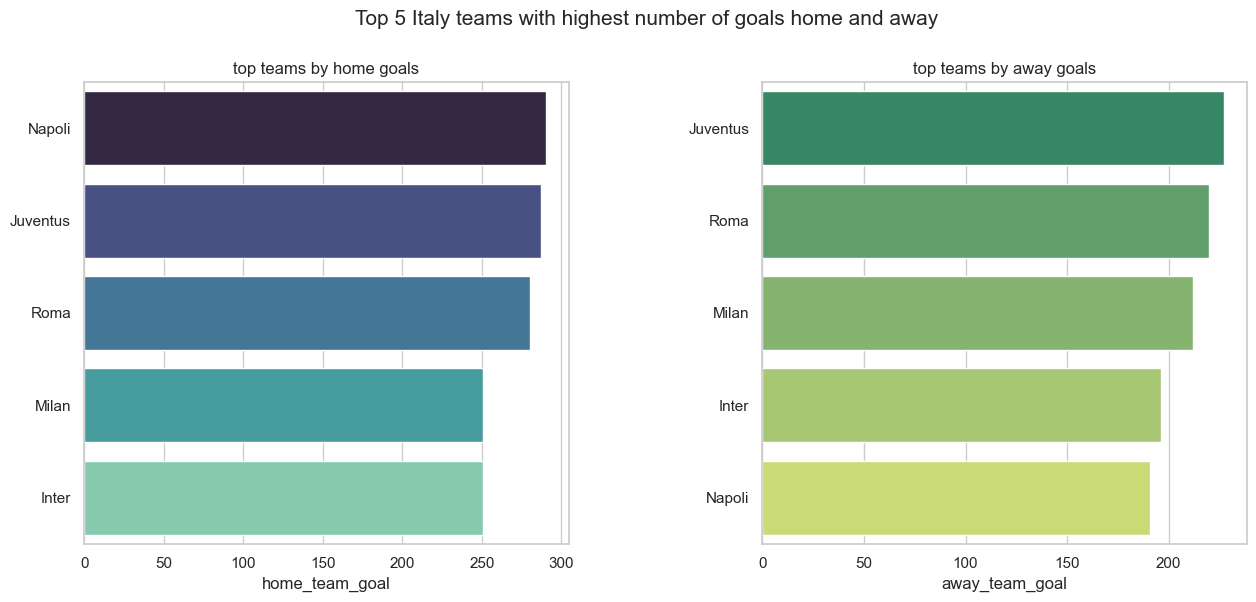

In [438]:
""" Plotting top 5 Italy teams with highest number of home and away goals """ 

df_italy = df_matches[df_matches['country_name'] == 'Italy']

h_t = df_italy.groupby("home_team_name")["home_team_goal"].sum().reset_index()
a_t = df_italy.groupby("away_team_name")["away_team_goal"].sum().reset_index()
h_t = h_t.sort_values(by="home_team_goal",ascending= False)
a_t = a_t.sort_values(by="away_team_goal",ascending= False)

plt.figure(figsize=(15,6))
plt.subplot(121)
ax = sns.barplot(y="home_team_name",x="home_team_goal",
                 data=h_t[:5], palette="mako",
                 linewidth = 1)
plt.ylabel('')
plt.title("top teams by home goals")
 
plt.subplot(122)

ax = sns.barplot(y="away_team_name",x="away_team_goal",
                 data=a_t[:5], palette="summer",
                linewidth = 1)
plt.ylabel("")
plt.subplots_adjust(wspace = .4)
plt.title("top teams by away goals")

plt.suptitle("Top 5 Italy teams with highest number of goals home and away", y=1, fontsize=15)
plt.show()

Text(0.5, 1.02, 'Top 4 Spain teams over the years')

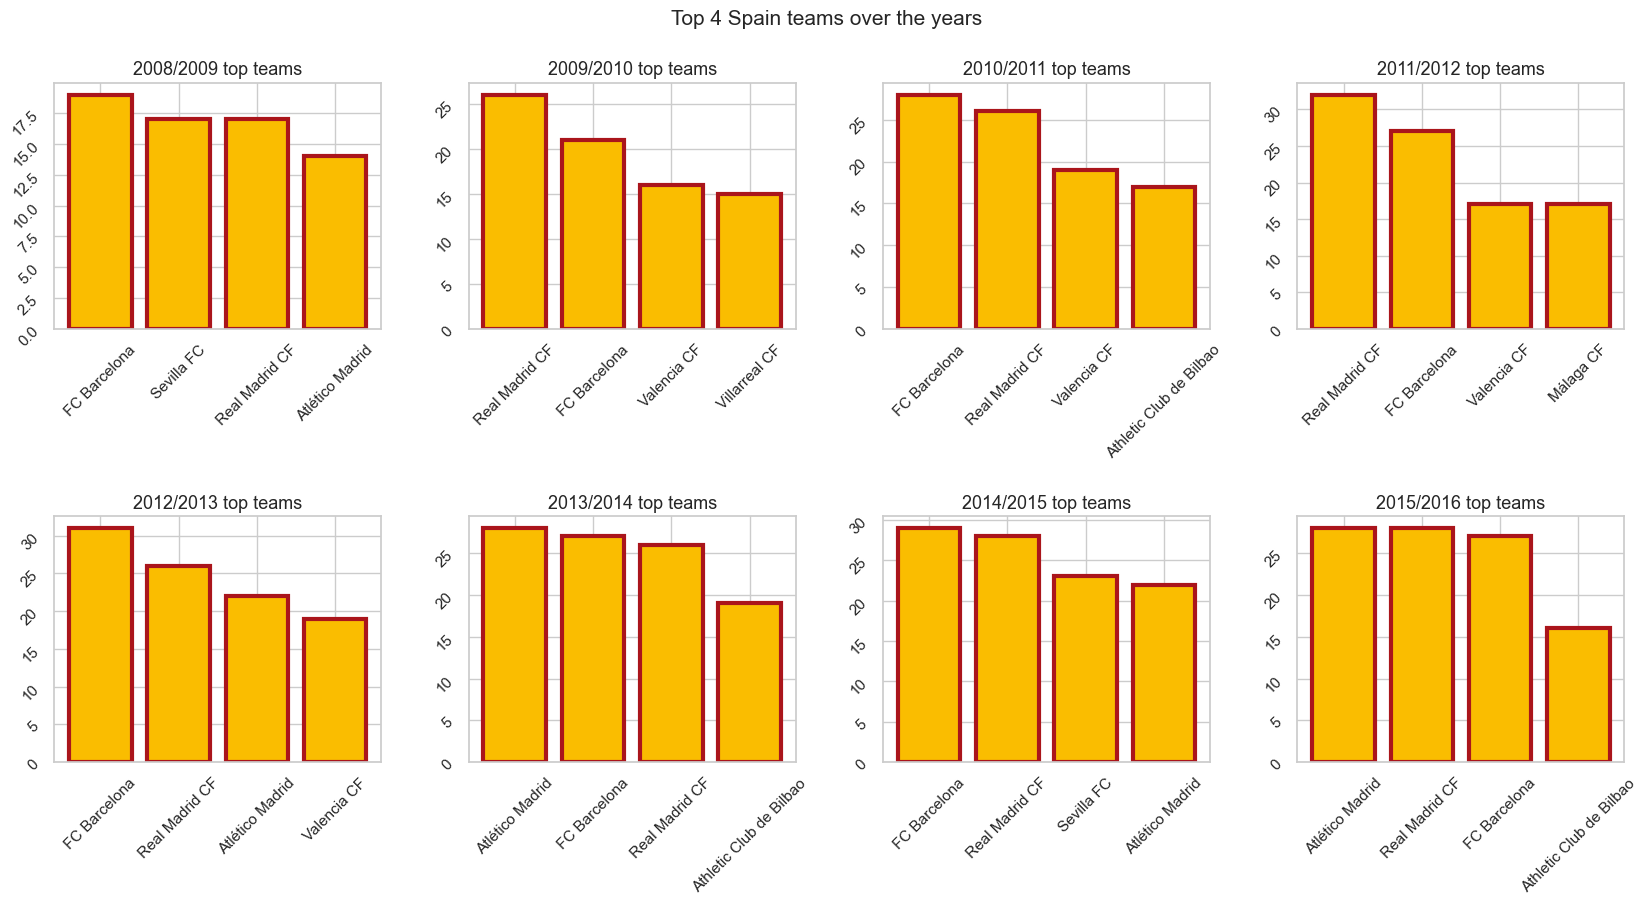

In [597]:
""" Plotting top 4 teams with highest number of matches by season in Spain """

df_spain_teams = df_wins_season[df_wins_season['country'] == 'Spain']
seasons = [col for col in df_spain_teams.columns if "/" in col]

fig, axes = plt.subplots(2, 4, figsize=(17, 9))
i = 0
j = 0

for season in seasons:
  if i < 2:
    if j < 4: 
        max_vals = df_spain_teams.nlargest(4, [season]) 
        min_vals = df_spain_teams.nsmallest(4, [season]) 

        if season == "2015/2016":
          max_teams_matches_won.extend(list(max_vals['team']))
          min_teams_matches_won.extend(list(min_vals['team'])) 
    
        axes[i][j].bar(max_vals['team'], max_vals[season], color='#FABD00', edgecolor='#AA151B',linewidth=3)
        axes[i][j].set_title(f"{season} top teams", fontsize=13)
        axes[i][j].tick_params(labelrotation=45) 
      
        j+=1
        if j == 4:
            i+=1
            j=0

fig.tight_layout(pad=2)
fig.suptitle("Top 4 Spain teams over the years", y=1.02, fontsize=15) 

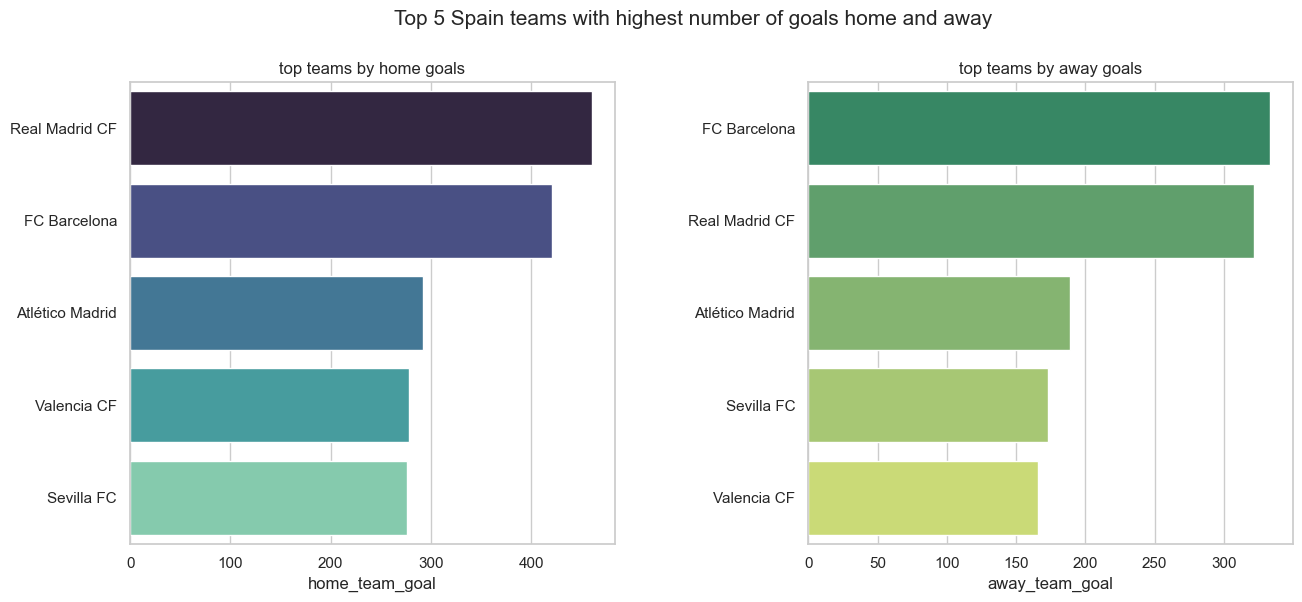

In [440]:
""" Plotting top 5 Spain teams with highest number of home and away goals """ 

df_spain = df_matches[df_matches['country_name'] == 'Spain']

h_t = df_spain.groupby("home_team_name")["home_team_goal"].sum().reset_index()
a_t = df_spain.groupby("away_team_name")["away_team_goal"].sum().reset_index()
h_t = h_t.sort_values(by="home_team_goal",ascending= False)
a_t = a_t.sort_values(by="away_team_goal",ascending= False)

plt.figure(figsize=(15,6))
plt.subplot(121)
ax = sns.barplot(y="home_team_name",x="home_team_goal",
                 data=h_t[:5], palette="mako",
                 linewidth = 1)
plt.ylabel('')
plt.title("top teams by home goals")
 
plt.subplot(122)

ax = sns.barplot(y="away_team_name",x="away_team_goal",
                 data=a_t[:5], palette="summer",
                linewidth = 1)
plt.ylabel("")
plt.subplots_adjust(wspace = .4)
plt.title("top teams by away goals")

plt.suptitle("Top 5 Spain teams with highest number of goals home and away", y=1, fontsize=15)
plt.show()

Text(0.5, 1.02, 'Top 4 Scotland teams over the years')

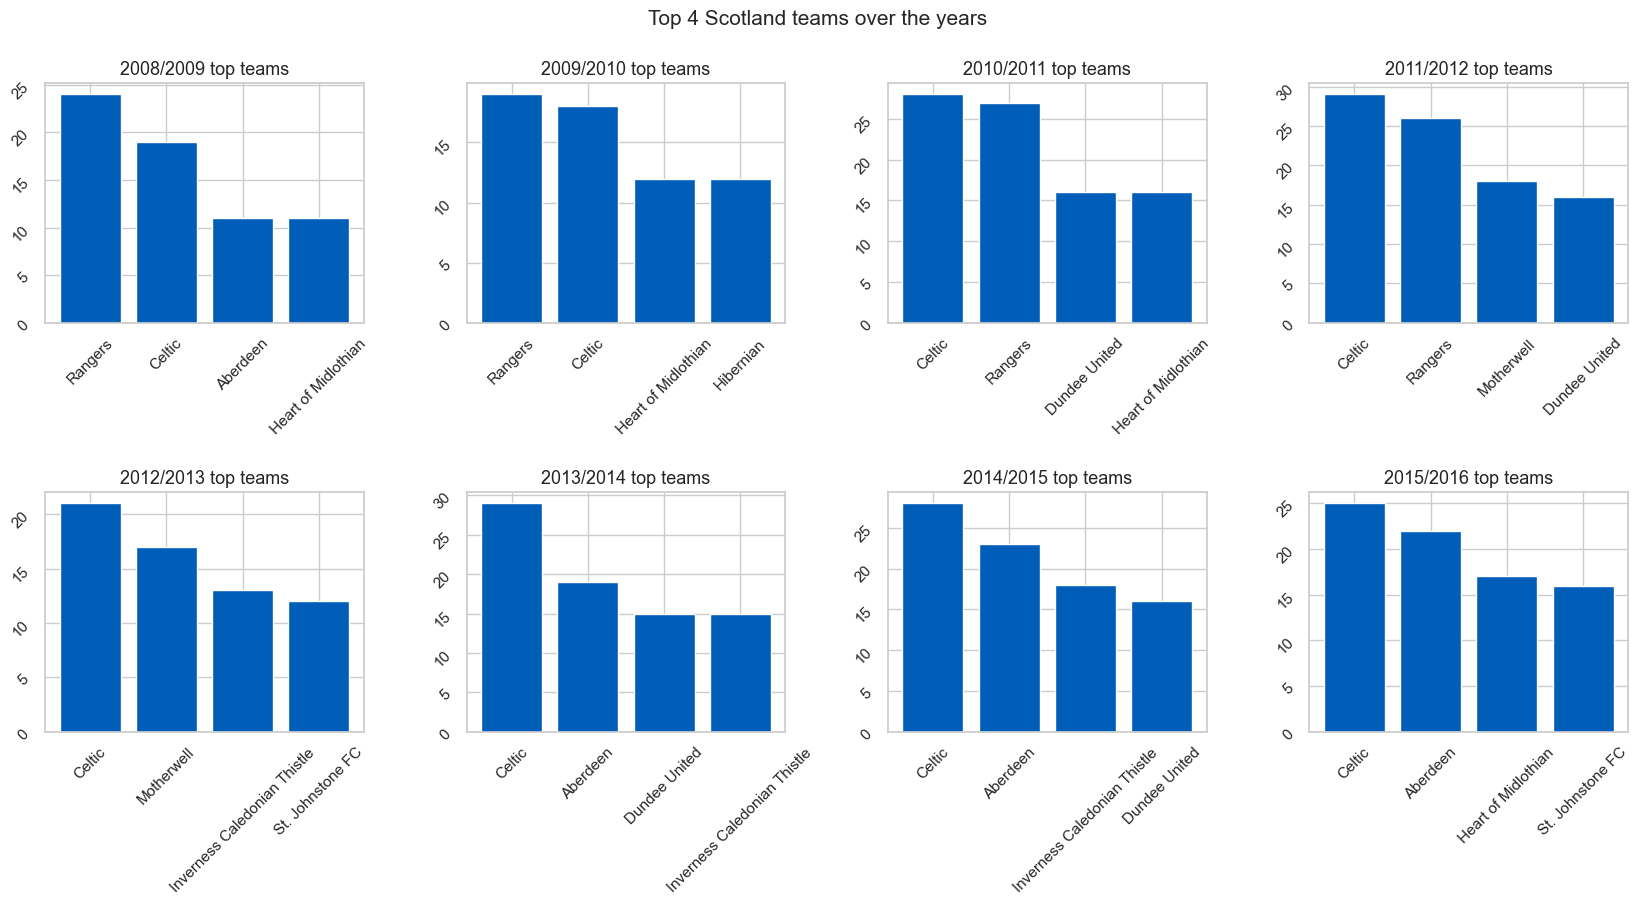

In [590]:
""" Plotting top 4 teams with highest number of matches by season in Scotland """

df_scotland_teams = df_wins_season[df_wins_season['country'] == 'Scotland']
seasons = [col for col in df_scotland_teams.columns if "/" in col]

fig, axes = plt.subplots(2, 4, figsize=(17, 9))
i = 0
j = 0

for season in seasons:
  if i < 2:
    if j < 4: 
        max_vals = df_scotland_teams.nlargest(4, [season]) 
        min_vals = df_scotland_teams.nsmallest(4, [season]) 

        if season == "2015/2016":
          max_teams_matches_won.extend(list(max_vals['team']))
          min_teams_matches_won.extend(list(min_vals['team'])) 
          
        axes[i][j].bar(max_vals['team'], max_vals[season], color='#005EB8')
        axes[i][j].set_title(f"{season} top teams", fontsize=13)
        axes[i][j].tick_params(labelrotation=45) 
      
        j+=1
        if j == 4:
            i+=1
            j=0

fig.tight_layout(pad=2)
fig.suptitle("Top 4 Scotland teams over the years", y=1.02, fontsize=15) 

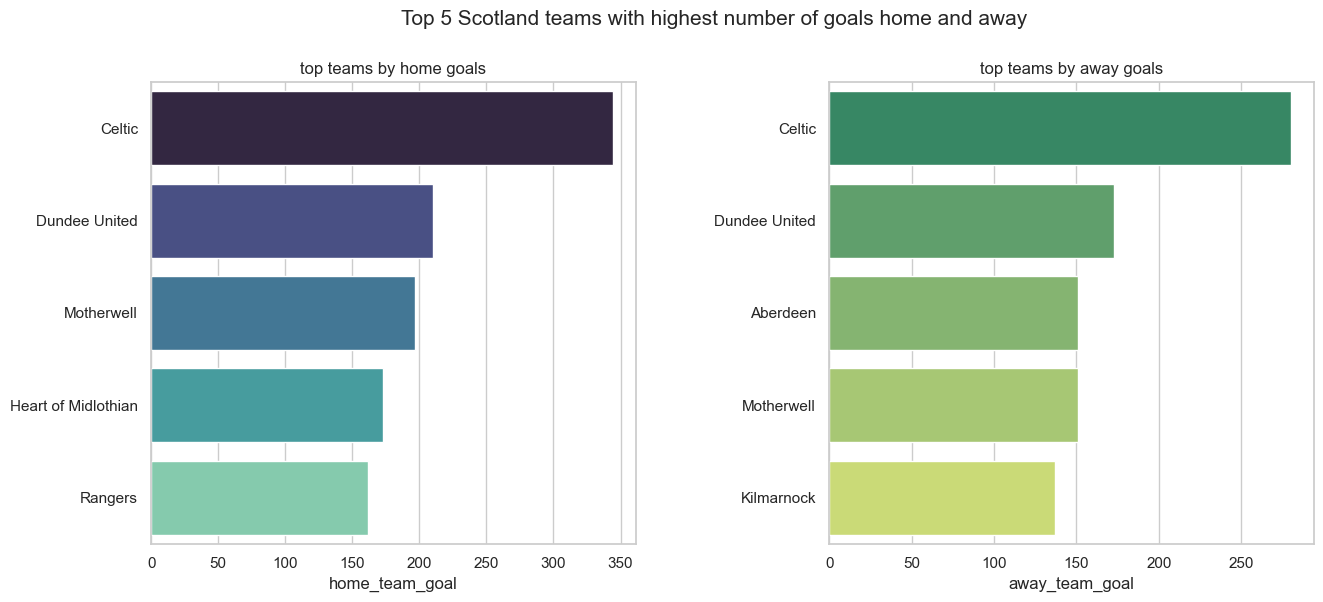

In [442]:
""" Plotting top 5 Scotland teams with highest number of home and away goals """

df_scotland = df_matches[df_matches['country_name'] == 'Scotland']

h_t = df_scotland.groupby("home_team_name")["home_team_goal"].sum().reset_index()
a_t = df_scotland.groupby("away_team_name")["away_team_goal"].sum().reset_index()
h_t = h_t.sort_values(by="home_team_goal",ascending= False)
a_t = a_t.sort_values(by="away_team_goal",ascending= False)

plt.figure(figsize=(15,6))
plt.subplot(121)
ax = sns.barplot(y="home_team_name",x="home_team_goal",
                 data=h_t[:5], palette="mako",
                 linewidth = 1)
plt.ylabel('')
plt.title("top teams by home goals")
 
plt.subplot(122)

ax = sns.barplot(y="away_team_name",x="away_team_goal",
                 data=a_t[:5], palette="summer",
                linewidth = 1)
plt.ylabel("")
plt.subplots_adjust(wspace = .4)
plt.title("top teams by away goals")

plt.suptitle("Top 5 Scotland teams with highest number of goals home and away", y=1, fontsize=15)
plt.show()

Text(0.5, 1.02, 'Top 4 Germany teams over the years')

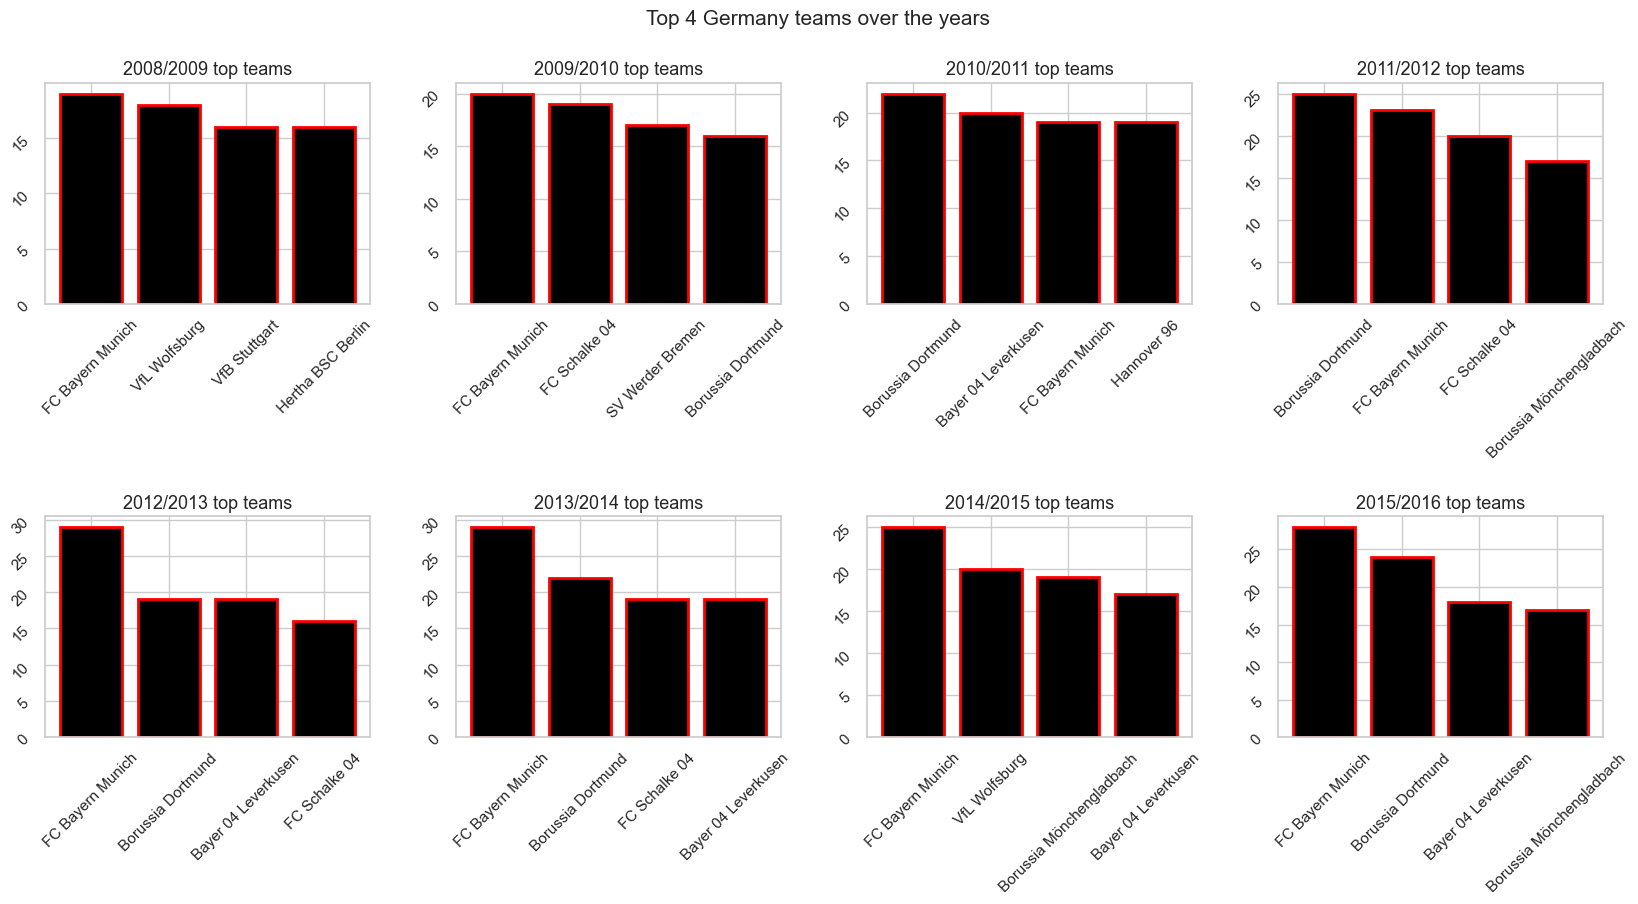

In [594]:
""" Plotting top 4 teams with highest number of matches by season in Germany """

df_germany_teams = df_wins_season[df_wins_season['country'] == 'Germany']
seasons = [col for col in df_germany_teams.columns if "/" in col]

fig, axes = plt.subplots(2, 4, figsize=(17, 9))
i = 0
j = 0

for season in seasons:
  if i < 2:
    if j < 4: 
        max_vals = df_germany_teams.nlargest(4, [season]) 
        min_vals = df_germany_teams.nsmallest(4, [season]) 

        if season == "2015/2016":
          max_teams_matches_won.extend(list(max_vals['team']))
          min_teams_matches_won.extend(list(min_vals['team'])) 
    
        axes[i][j].bar(max_vals['team'], max_vals[season], color='#000', edgecolor='#FF0000',linewidth=2)
        axes[i][j].set_title(f"{season} top teams", fontsize=13)
        axes[i][j].tick_params(labelrotation=45) 
      
        j+=1
        if j == 4:
            i+=1
            j=0

fig.tight_layout(pad=2)
fig.suptitle("Top 4 Germany teams over the years", y=1.02, fontsize=15) 

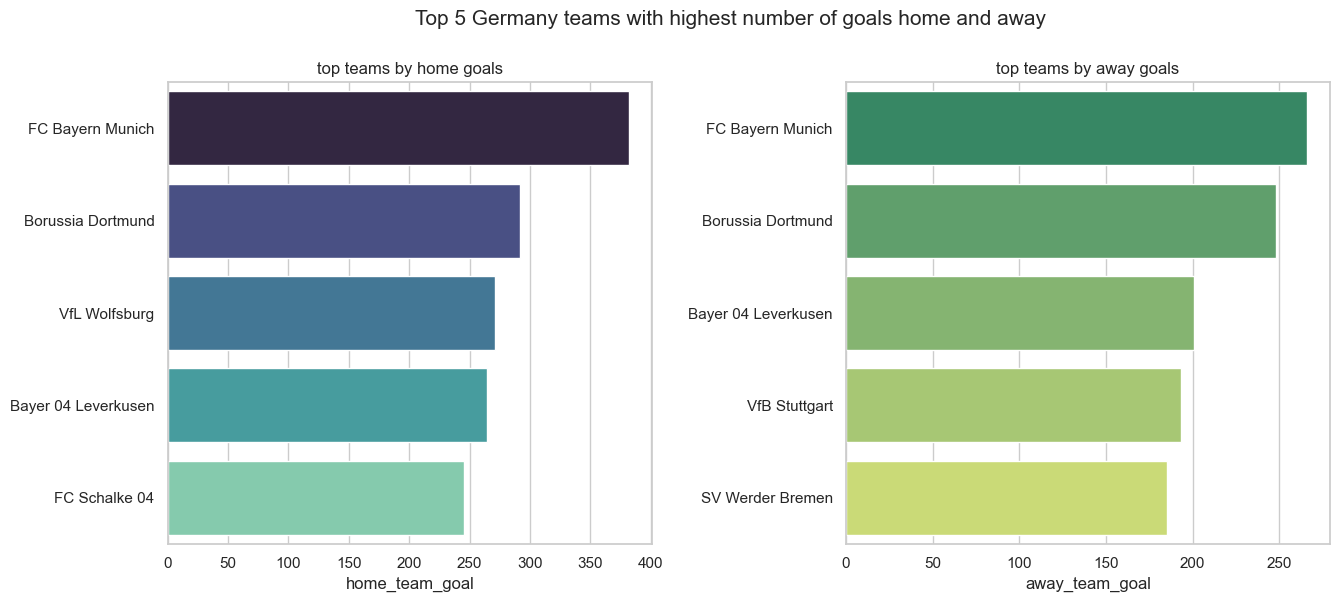

In [444]:
""" Plotting top 5 Germany teams with highest number of home and away goals """ 

df_germany = df_matches[df_matches['country_name'] == 'Germany']

h_t = df_germany.groupby("home_team_name")["home_team_goal"].sum().reset_index()
a_t = df_germany.groupby("away_team_name")["away_team_goal"].sum().reset_index()
h_t = h_t.sort_values(by="home_team_goal",ascending= False)
a_t = a_t.sort_values(by="away_team_goal",ascending= False)

plt.figure(figsize=(15,6))
plt.subplot(121)
ax = sns.barplot(y="home_team_name",x="home_team_goal",
                 data=h_t[:5], palette="mako",
                 linewidth = 1)
plt.ylabel('')
plt.title("top teams by home goals")
 
plt.subplot(122)

ax = sns.barplot(y="away_team_name",x="away_team_goal",
                 data=a_t[:5], palette="summer",
                linewidth = 1)
plt.ylabel("")
plt.subplots_adjust(wspace = .4)
plt.title("top teams by away goals")

plt.suptitle("Top 5 Germany teams with highest number of goals home and away", y=1, fontsize=15)
plt.show()

Text(0.5, 1.02, 'Top 4 Switzerland teams over the years')

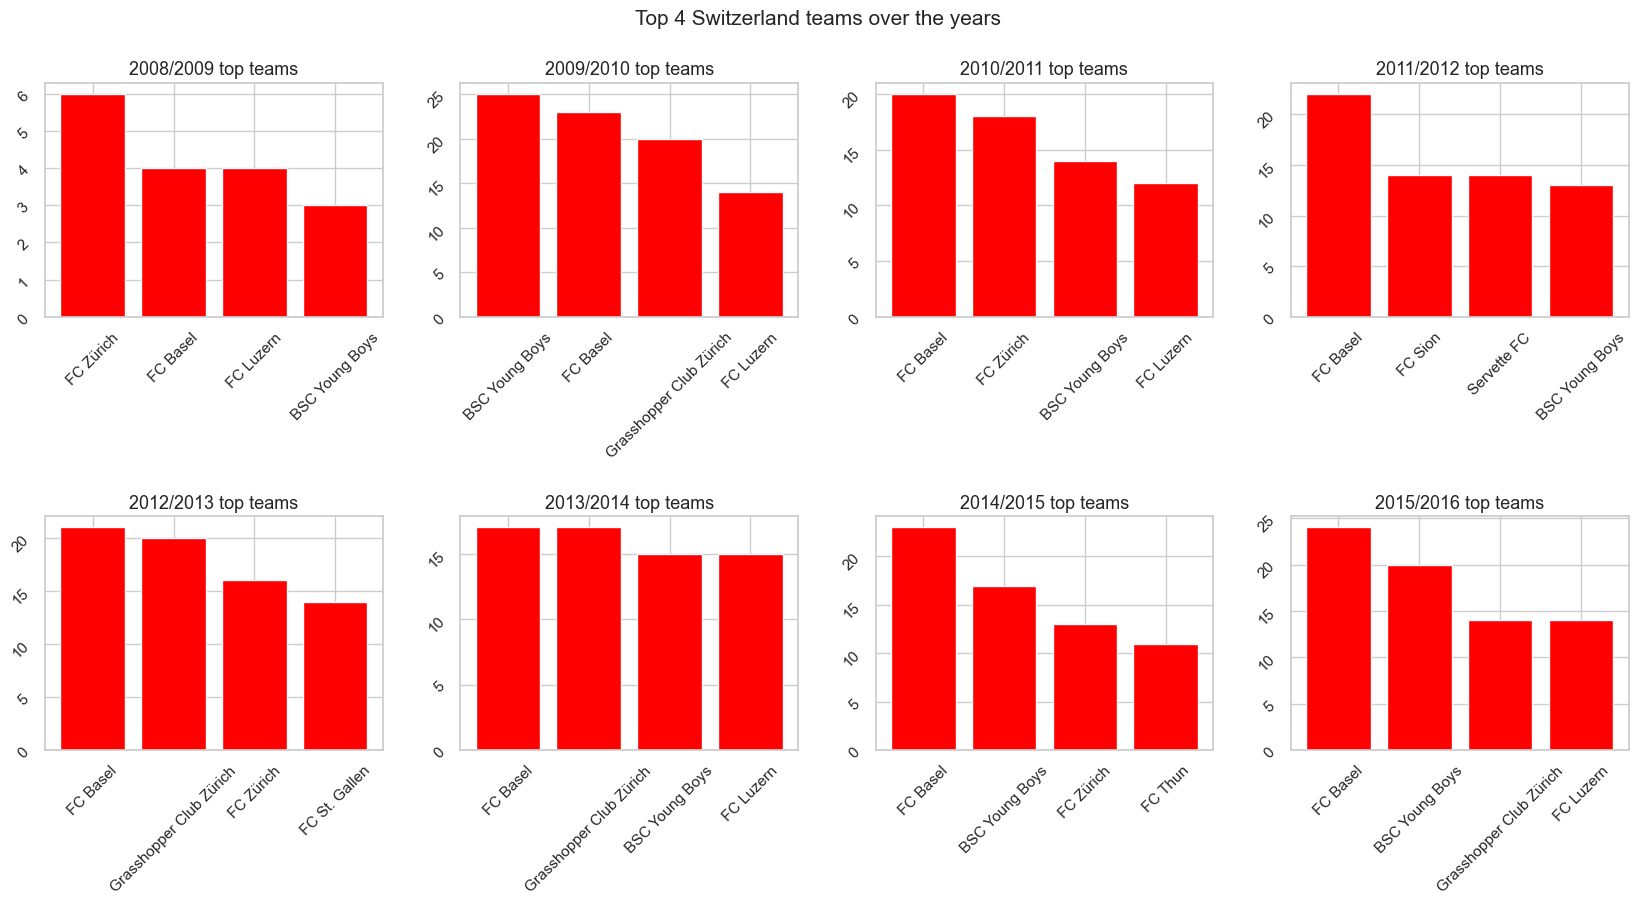

In [591]:
""" Plotting top 4 teams with highest number of matches by season in Switzerland """

df_switzerland_teams = df_wins_season[df_wins_season['country'] == 'Switzerland']
seasons = [col for col in df_switzerland_teams.columns if "/" in col]

fig, axes = plt.subplots(2, 4, figsize=(17, 9))
i = 0
j = 0

for season in seasons:
  if i < 2:
    if j < 4: 
        max_vals = df_switzerland_teams.nlargest(4, [season]) 
        min_vals = df_switzerland_teams.nsmallest(4, [season]) 

        if season == "2015/2016":
          max_teams_matches_won.extend(list(max_vals['team']))
          min_teams_matches_won.extend(list(min_vals['team'])) 
    
        axes[i][j].bar(max_vals['team'], max_vals[season], color='#FF0000')
        axes[i][j].set_title(f"{season} top teams", fontsize=13)
        axes[i][j].tick_params(labelrotation=45) 
      
        j+=1
        if j == 4:
            i+=1
            j=0

fig.tight_layout(pad=2)
fig.suptitle("Top 4 Switzerland teams over the years", y=1.02, fontsize=15) 

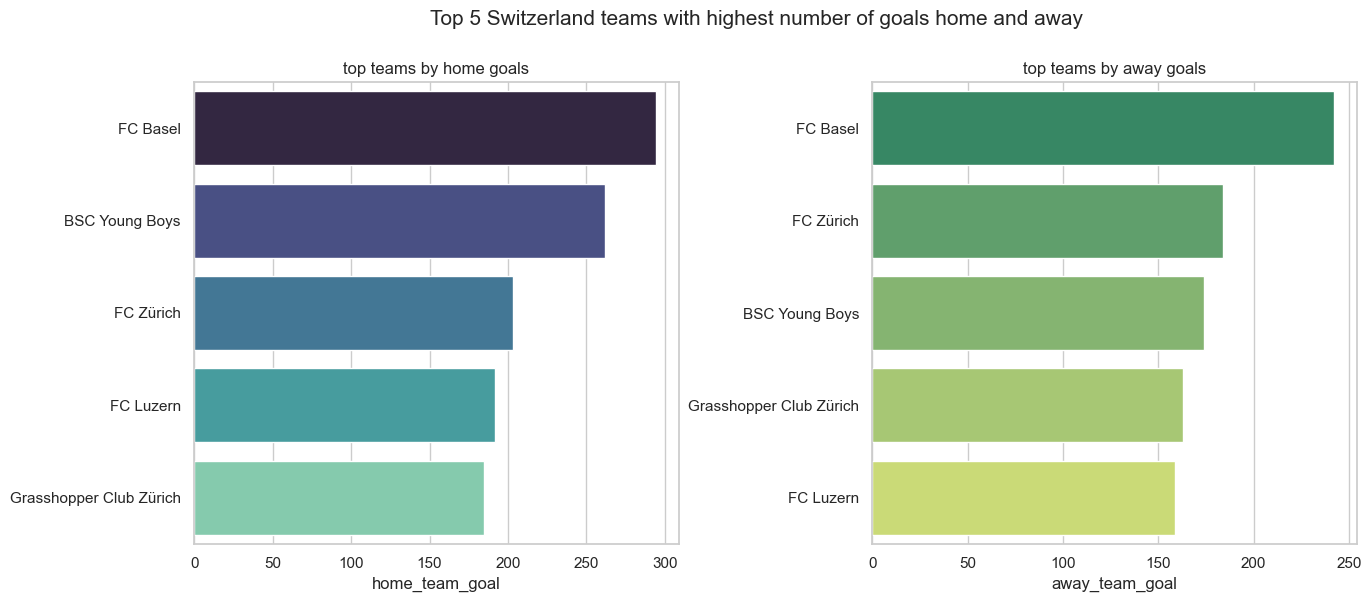

In [446]:
""" Plotting top 5 Switzerland teams with highest number of home and away goals """ 

df_switzerland = df_matches[df_matches['country_name'] == 'Switzerland']

h_t = df_switzerland.groupby("home_team_name")["home_team_goal"].sum().reset_index()
a_t = df_switzerland.groupby("away_team_name")["away_team_goal"].sum().reset_index()
h_t = h_t.sort_values(by="home_team_goal",ascending= False)
a_t = a_t.sort_values(by="away_team_goal",ascending= False)

plt.figure(figsize=(15,6))
plt.subplot(121)
ax = sns.barplot(y="home_team_name",x="home_team_goal",
                 data=h_t[:5], palette="mako",
                 linewidth = 1)
plt.ylabel('')
plt.title("top teams by home goals")
 
plt.subplot(122)

ax = sns.barplot(y="away_team_name",x="away_team_goal",
                 data=a_t[:5], palette="summer",
                linewidth = 1)
plt.ylabel("")
plt.subplots_adjust(wspace = .4)
plt.title("top teams by away goals")

plt.suptitle("Top 5 Switzerland teams with highest number of goals home and away", y=1, fontsize=15)
plt.show()

Text(0.5, 1.02, 'Top 4 Netherlands teams over the years')

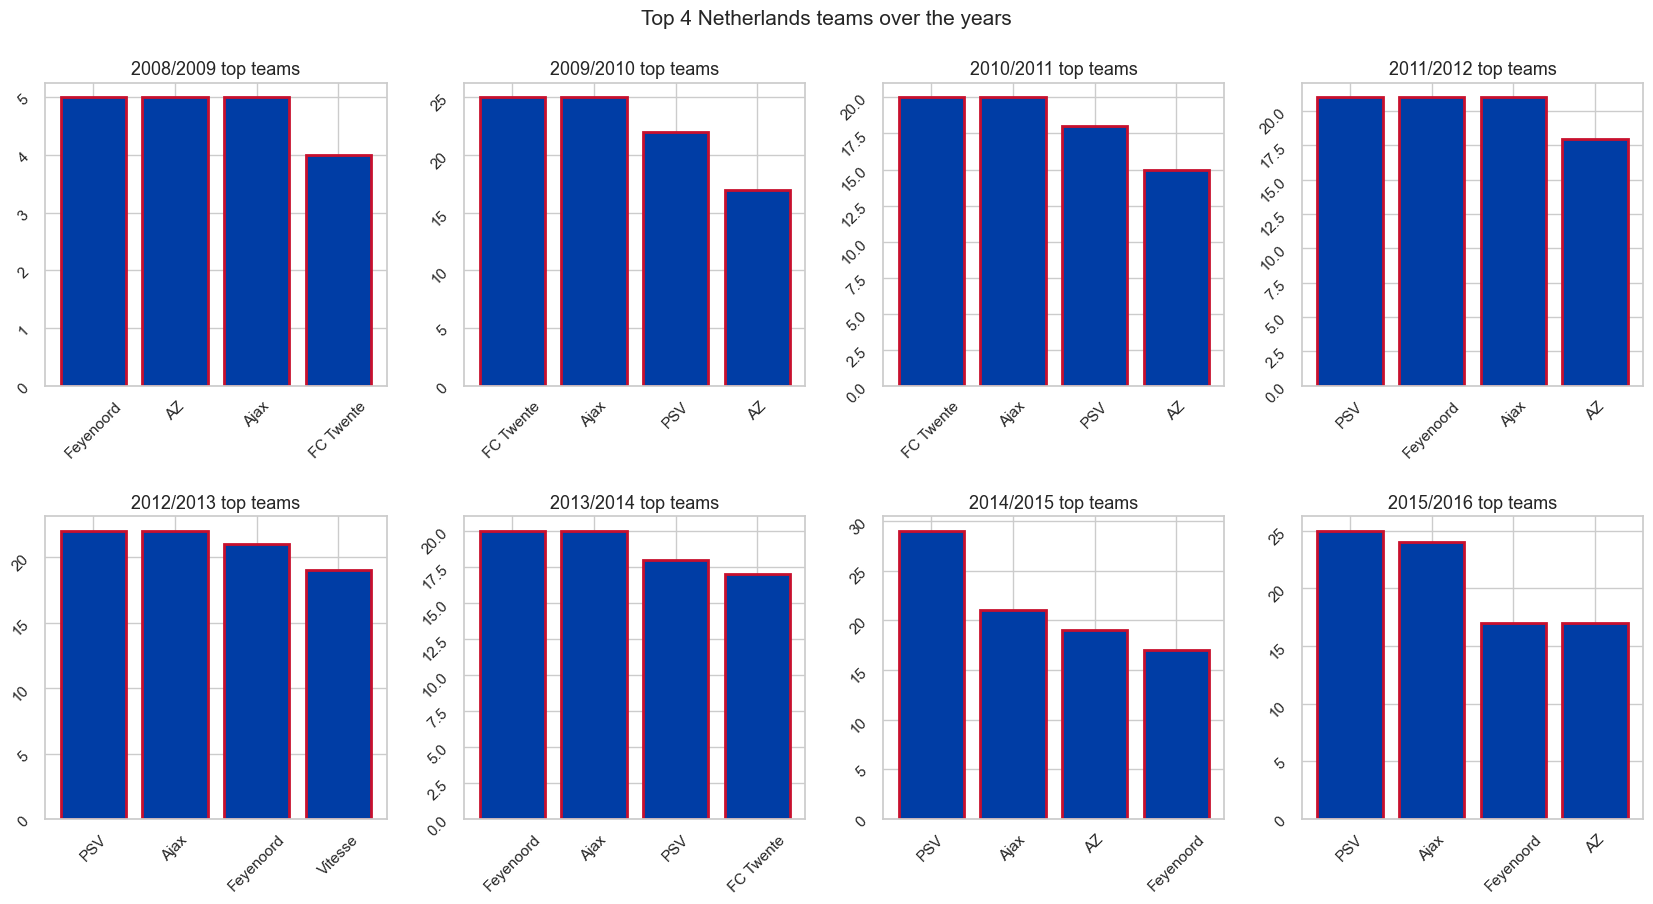

In [596]:
""" Plotting top 4 teams with highest number of matches by season in Netherlands """

df_netherlands_teams = df_wins_season[df_wins_season['country'] == 'Netherlands']
seasons = [col for col in df_netherlands_teams.columns if "/" in col]

fig, axes = plt.subplots(2, 4, figsize=(17, 9))
i = 0
j = 0

for season in seasons:
  if i < 2:
    if j < 4: 
        max_vals = df_netherlands_teams.nlargest(4, [season]) 
        min_vals = df_netherlands_teams.nsmallest(4, [season]) 

        if season == "2015/2016":
          max_teams_matches_won.extend(list(max_vals['team']))
          min_teams_matches_won.extend(list(min_vals['team'])) 
    
        axes[i][j].bar(max_vals['team'], max_vals[season], color='#003DA5', edgecolor='#C8102E',linewidth=2)
        axes[i][j].set_title(f"{season} top teams", fontsize=13)
        axes[i][j].tick_params(labelrotation=45) 
      
        j+=1
        if j == 4:
            i+=1
            j=0

fig.tight_layout(pad=2)
fig.suptitle("Top 4 Netherlands teams over the years", y=1.02, fontsize=15) 

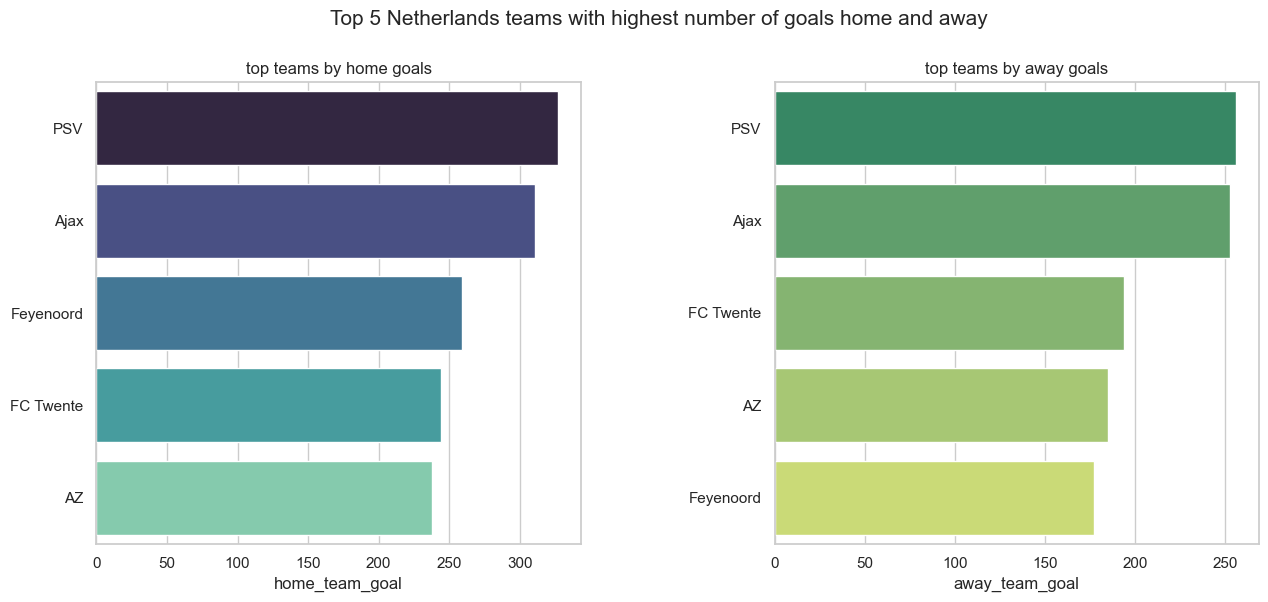

In [448]:
""" Plotting top 5 Netherlands teams with highest number of home and away goals """ 

df_netherlands = df_matches[df_matches['country_name'] == 'Netherlands']

h_t = df_netherlands.groupby("home_team_name")["home_team_goal"].sum().reset_index()
a_t = df_netherlands.groupby("away_team_name")["away_team_goal"].sum().reset_index()
h_t = h_t.sort_values(by="home_team_goal",ascending= False)
a_t = a_t.sort_values(by="away_team_goal",ascending= False)

plt.figure(figsize=(15,6))
plt.subplot(121)
ax = sns.barplot(y="home_team_name",x="home_team_goal",
                 data=h_t[:5], palette="mako",
                 linewidth = 1)
plt.ylabel('')
plt.title("top teams by home goals")
 
plt.subplot(122)

ax = sns.barplot(y="away_team_name",x="away_team_goal",
                 data=a_t[:5], palette="summer",
                linewidth = 1)
plt.ylabel("")
plt.subplots_adjust(wspace = .4)
plt.title("top teams by away goals")

plt.suptitle("Top 5 Netherlands teams with highest number of goals home and away", y=1, fontsize=15)
plt.show()

Text(0.5, 1.02, 'Top 4 Portugal teams over the years')

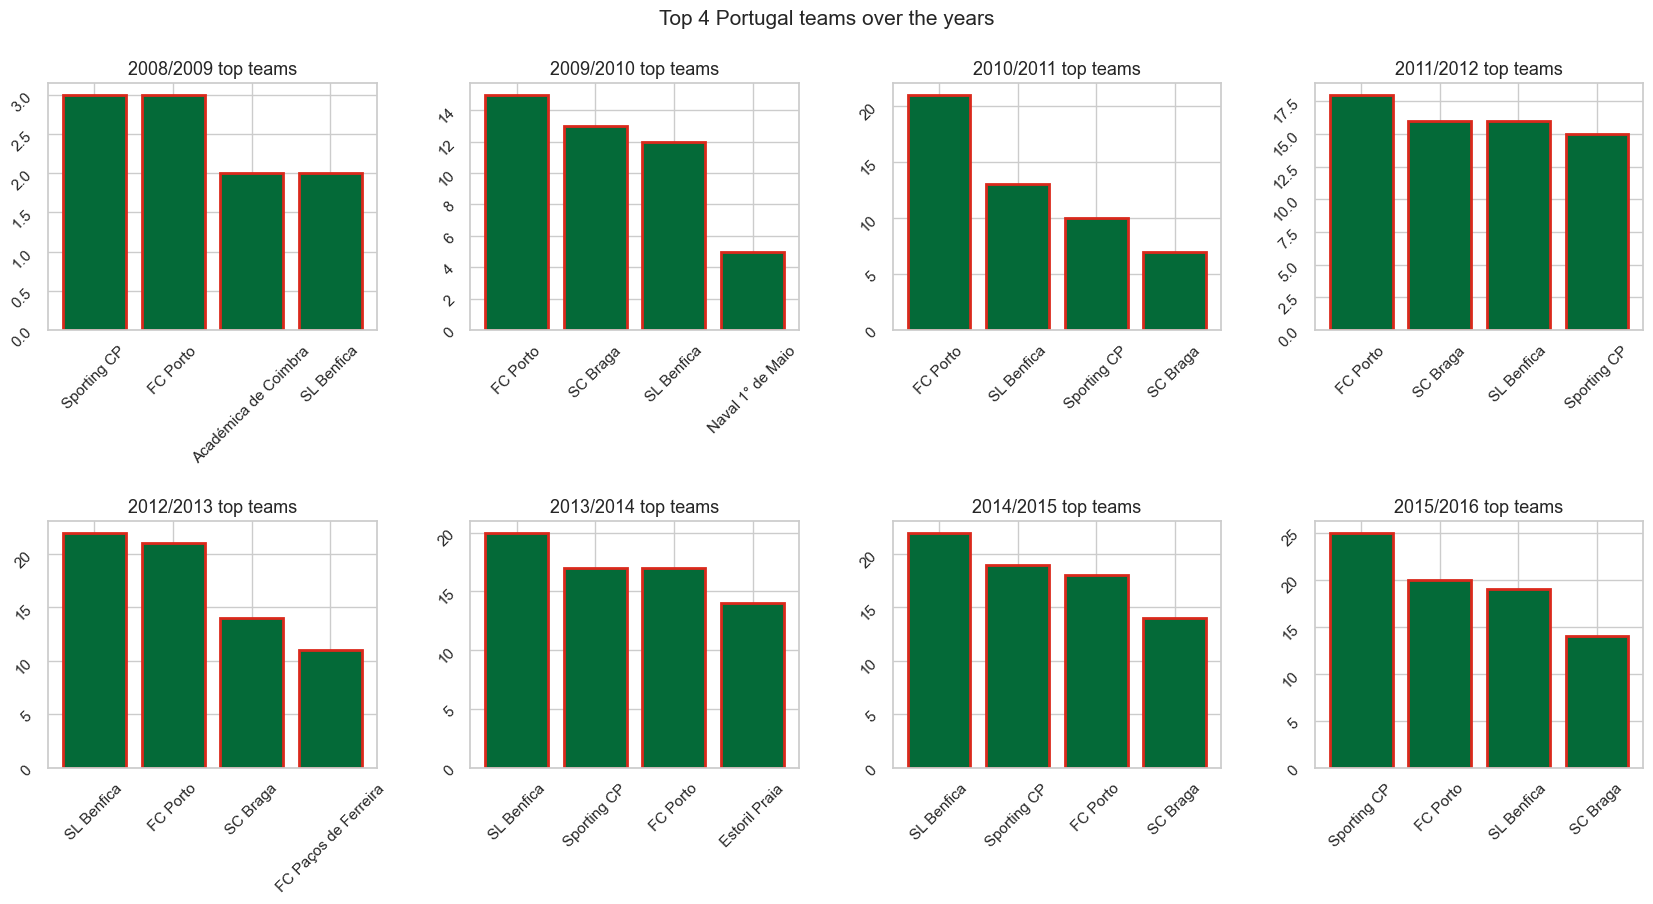

In [592]:
""" Plotting top 4 teams with highest number of matches by season in Portugal """

df_portugal_teams = df_wins_season[df_wins_season['country'] == 'Portugal']
seasons = [col for col in df_portugal_teams.columns if "/" in col]

fig, axes = plt.subplots(2, 4, figsize=(17, 9))
i = 0
j = 0

for season in seasons:
  if i < 2:
    if j < 4: 
        max_vals = df_portugal_teams.nlargest(4, [season]) 
        min_vals = df_portugal_teams.nsmallest(4, [season]) 

        if season == "2015/2016":
          max_teams_matches_won.extend(list(max_vals['team']))
          min_teams_matches_won.extend(list(min_vals['team']))  
    
        axes[i][j].bar(max_vals['team'], max_vals[season], color='#046A38', edgecolor='#DA291C',linewidth=2)
        axes[i][j].set_title(f"{season} top teams", fontsize=13)
        axes[i][j].tick_params(labelrotation=45) 
      
        j+=1
        if j == 4:
            i+=1
            j=0

fig.tight_layout(pad=2)
fig.suptitle("Top 4 Portugal teams over the years", y=1.02, fontsize=15) 

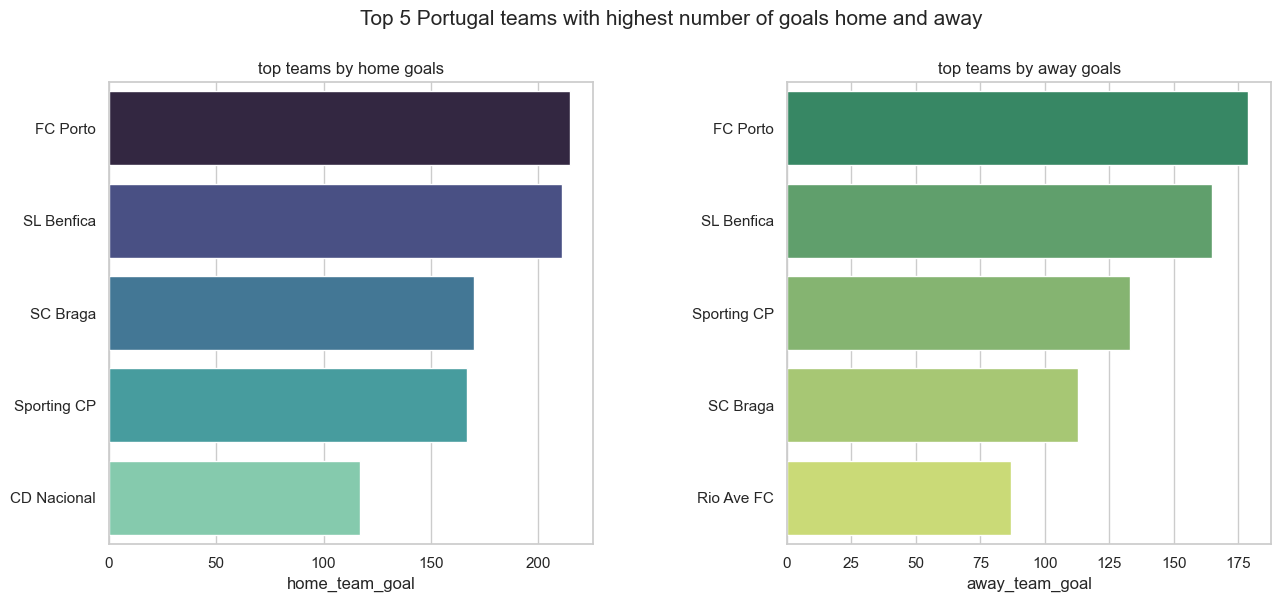

In [450]:
""" Plotting top 5 Portugal teams with highest number of home and away goals """ 

df_portugal = df_matches[df_matches['country_name'] == 'Portugal']

h_t = df_portugal.groupby("home_team_name")["home_team_goal"].sum().reset_index()
a_t = df_portugal.groupby("away_team_name")["away_team_goal"].sum().reset_index()
h_t = h_t.sort_values(by="home_team_goal",ascending= False)
a_t = a_t.sort_values(by="away_team_goal",ascending= False)

plt.figure(figsize=(15,6))
plt.subplot(121)
ax = sns.barplot(y="home_team_name",x="home_team_goal",
                 data=h_t[:5], palette="mako",
                 linewidth = 1)
plt.ylabel('')
plt.title("top teams by home goals")
 
plt.subplot(122)

ax = sns.barplot(y="away_team_name",x="away_team_goal",
                 data=a_t[:5], palette="summer",
                 linewidth = 1)
plt.ylabel("")
plt.subplots_adjust(wspace = .4)
plt.title("top teams by away goals")

plt.suptitle("Top 5 Portugal teams with highest number of goals home and away", y=1, fontsize=15)
plt.show()

Text(0.5, 1.02, 'Top 4 Belgium teams over the years')

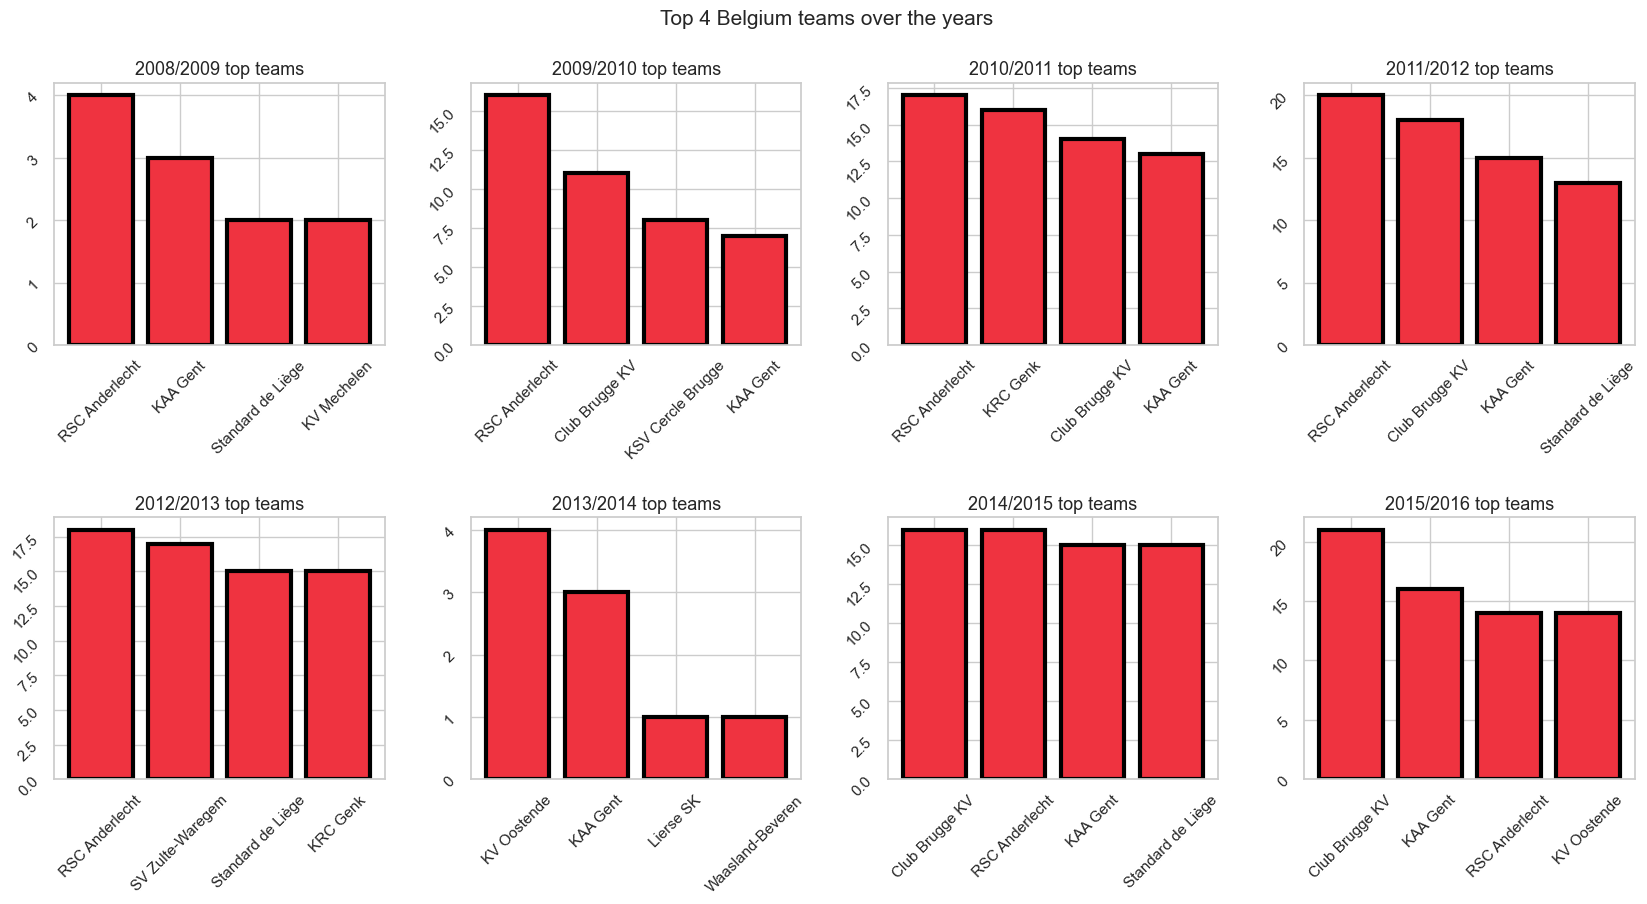

In [595]:
""" Plotting top 4 teams with highest number of matches by season in Belgium """

df_belgium_teams = df_wins_season[df_wins_season['country'] == 'Belgium']
seasons = [col for col in df_belgium_teams.columns if "/" in col]

fig, axes = plt.subplots(2, 4, figsize=(17, 9))
i = 0
j = 0

for season in seasons:
  if i < 2:
    if j < 4: 
        max_vals = df_belgium_teams.nlargest(4, [season]) 
        min_vals = df_belgium_teams.nsmallest(4, [season]) 

        if season == "2015/2016":
          max_teams_matches_won.extend(list(max_vals['team']))
          min_teams_matches_won.extend(list(min_vals['team'])) 
    
        axes[i][j].bar(max_vals['team'], max_vals[season], color='#EF3340', edgecolor='#000', linewidth=3)
        axes[i][j].set_title(f"{season} top teams", fontsize=13)
        axes[i][j].tick_params(labelrotation=45) 
      
        j+=1
        if j == 4:
            i+=1
            j=0

fig.tight_layout(pad=2)
fig.suptitle("Top 4 Belgium teams over the years", y=1.02, fontsize=15) 

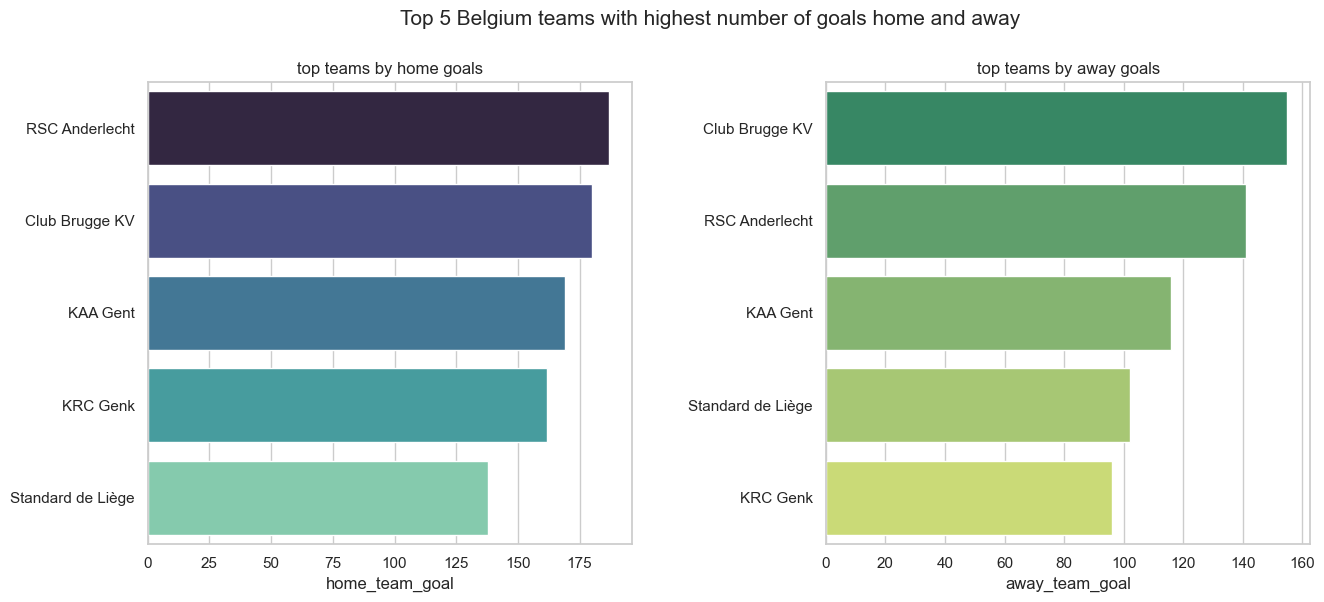

In [452]:
""" Plotting top 4 teams with highest number of matches by season in Belgium """

df_belgium = df_matches[df_matches['country_name'] == 'Belgium']

h_t = df_belgium.groupby("home_team_name")["home_team_goal"].sum().reset_index()
a_t = df_belgium.groupby("away_team_name")["away_team_goal"].sum().reset_index()
h_t = h_t.sort_values(by="home_team_goal",ascending= False)
a_t = a_t.sort_values(by="away_team_goal",ascending= False)

plt.figure(figsize=(15,6))
plt.subplot(121)
ax = sns.barplot(y="home_team_name",x="home_team_goal",
                 data=h_t[:5], palette="mako",
                 linewidth = 1)
plt.ylabel('')
plt.title("top teams by home goals")
 
plt.subplot(122)

ax = sns.barplot(y="away_team_name",x="away_team_goal",
                 data=a_t[:5], palette="summer",
                linewidth = 1)
plt.ylabel("")
plt.subplots_adjust(wspace = .4)
plt.title("top teams by away goals")

plt.suptitle("Top 5 Belgium teams with highest number of goals home and away", y=1, fontsize=15)
plt.show()

Text(0.5, 1.02, 'Top 4 Poland teams over the years')

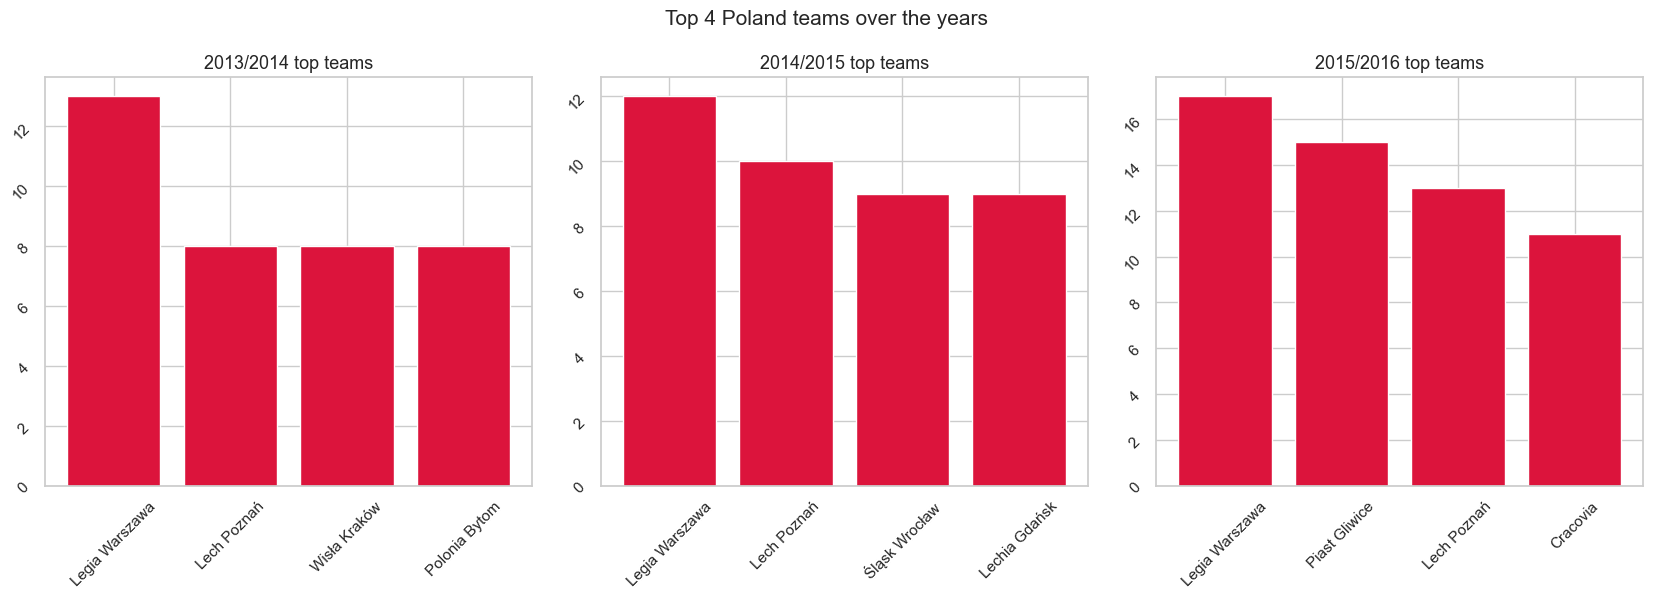

In [593]:
""" Plotting top 4 teams with highest number of matches by season in Poland """

df_poland_teams = df_wins_season[df_wins_season['country'] == 'Poland']
seasons = df_matches[df_matches['country_name'] == 'Poland']['season'].unique()

fig, axes = plt.subplots(1, 3, figsize=(17, 6))
i = 0 

for season in seasons: 
    max_vals = df_poland_teams.nlargest(4, [season]) 
    min_vals = df_poland_teams.nsmallest(4, [season]) 

    if season == "2015/2016":
        max_teams_matches_won.extend(list(max_vals['team']))
        min_teams_matches_won.extend(list(min_vals['team']))
        
    axes[i].bar(max_vals['team'], max_vals[season], color='#DC143C')
    axes[i].set_title(f"{season} top teams", fontsize=13)
    axes[i].tick_params(labelrotation=45) 

    i+=1

fig.tight_layout(pad=2)
fig.suptitle("Top 4 Poland teams over the years", y=1.02, fontsize=15) 

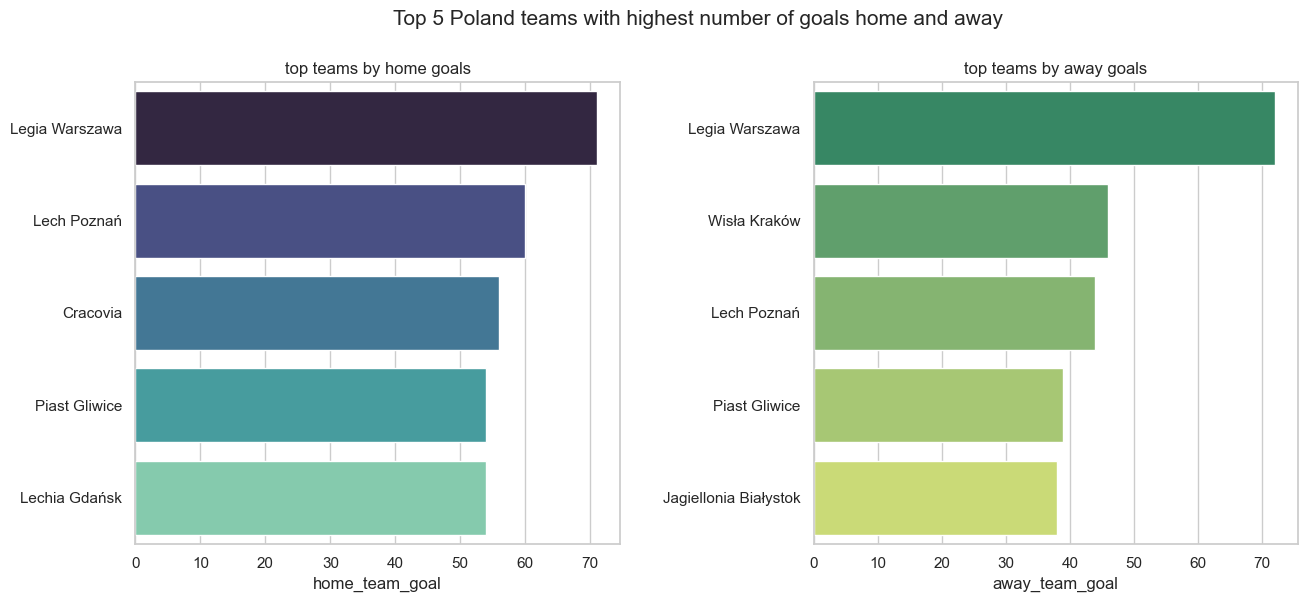

In [454]:
""" Plotting top 5 Poland teams with highest number of home and away goals """ 

df_poland = df_matches[df_matches['country_name'] == 'Poland']

h_t = df_poland.groupby("home_team_name")["home_team_goal"].sum().reset_index()
a_t = df_poland.groupby("away_team_name")["away_team_goal"].sum().reset_index()
h_t = h_t.sort_values(by="home_team_goal",ascending= False)
a_t = a_t.sort_values(by="away_team_goal",ascending= False)

plt.figure(figsize=(15,6))
plt.subplot(121)
ax = sns.barplot(y="home_team_name",x="home_team_goal",
                 data=h_t[:5], palette="mako",
                 linewidth = 1)
plt.ylabel('')
plt.title("top teams by home goals")
 
plt.subplot(122)

ax = sns.barplot(y="away_team_name",x="away_team_goal",
                 data=a_t[:5], palette="summer",
                linewidth = 1)
plt.ylabel("")
plt.subplots_adjust(wspace = .4)
plt.title("top teams by away goals")

plt.suptitle("Top 5 Poland teams with highest number of goals home and away", y=1, fontsize=15)
plt.show()

We have gathered the best teams in different leagues over the years. Now I want to see whether the best team has some remarkable differences between their home and away goals. Therefore, I will do the hypothesis testing.

### Hypothesis testing
#### Average Home - Away goals difference for Top 4 teams in different leagues in season 2015/2016

Considering top 4 teams with biggest number of matches won, do these teams also have smallest average home - away goals difference?

Let's define a few parameters:

* Population here is a top 4 teams matches

* Our Parameter of Interest is (μ1 − μ2): average home-away goals difference

* μ1: Mean average home-away goals difference of top 4 teams with lowest number of matches won

* μ2: Mean average home-away goals difference of top 4 teams with highest number of matches won

H₀: μ1≤μ2

H₁: μ1>μ2

Significance Level - 5%

In [455]:
""" Getting avergae team goals difference in season 2015/2016"""

teams = df_teams['team_long_name'].unique()
df_2015_2016_avg_team_goals_diff = pd.DataFrame()  
df_2015_2016 = df_matches[df_matches['season'] == '2015/2016']
df_2015_2016_avg_team_goals_diff['team'] = teams
differences = []

for team in teams:
    team_away_matches = df_2015_2016[df_2015_2016['away_team_name'] == team] 
    
    if len(team_away_matches['away_team_goal']) > 0:
        away_avg_goals = sum(team_away_matches['away_team_goal']) / len(team_away_matches['away_team_goal']) 

    team_away_matches = df_2015_2016[df_2015_2016['home_team_name'] == team] 
    if len(team_away_matches['home_team_name']) > 0:
        home_avg_goals = sum(team_away_matches['home_team_goal']) / len(team_away_matches['home_team_goal']) 

    diff = abs(home_avg_goals - away_avg_goals)
    differences.append(diff)

df_2015_2016_avg_team_goals_diff['avg_goal_diff'] = differences
df_2015_2016_avg_team_goals_diff.head()

team  avg_goal_diff
0            Arsenal       0.157895
1          Liverpool       0.157895
2  Manchester United       0.263158
3         Stoke City       0.157895
4            Chelsea       0.263158

In [456]:
""" Getting average goal difference of top 4 teams with highest number of matches won in 2015/2016 season """
top_4_highest = df_2015_2016_avg_team_goals_diff[df_2015_2016_avg_team_goals_diff['team'].isin(max_teams_matches_won)] 

In [457]:
""" Getting average goal difference of top 4 teams with lowest number of matches won in 2015/2016 season """
top_4_lowest = df_2015_2016_avg_team_goals_diff[df_2015_2016_avg_team_goals_diff['team'].isin(min_teams_matches_won)] 

In [458]:
""" Performing a t-test """
summary, results = rp.ttest(group1=top_4_highest['avg_goal_diff'], group1_name= "Top 4 Highest",
         group2=top_4_lowest['avg_goal_diff'], group2_name= "Top 4 Lowest")

##### Interpretation

The average goal difference (home-away) for top 4 teams with highest number of matches won, Mean=0.568, was statistically signigicantly higher than top 4 teams with lowest number of matches, Mean=0.326; t=3.052, p=0.003 

In [459]:
summary

Variable     N      Mean        SD        SE  95% Conf.  Interval
0  Top 4 Highest  44.0  0.568327  0.447661  0.067487   0.432225  0.704428
1   Top 4 Lowest  44.0  0.326883  0.273819  0.041280   0.243634  0.410131
2       combined  88.0  0.447605  0.388391  0.041403   0.365313  0.529897

In [460]:
results

Independent t-test  results
0  Difference (Top 4 Highest - Top 4 Lowest) =    0.2414
1                         Degrees of freedom =   86.0000
2                                          t =    3.0520
3                      Two side test p value =    0.0030
4                     Difference < 0 p value =    0.9985
5                     Difference > 0 p value =    0.0015
6                                  Cohen's d =    0.6507
7                                  Hedge's g =    0.6450
8                             Glass's delta1 =    0.5393
9                           Point-Biserial r =    0.3126

There is a statistically significant difference in the average goal difference between teams with lowest and highest amount of matches won

* *t=3.052*
* *p=0.003*

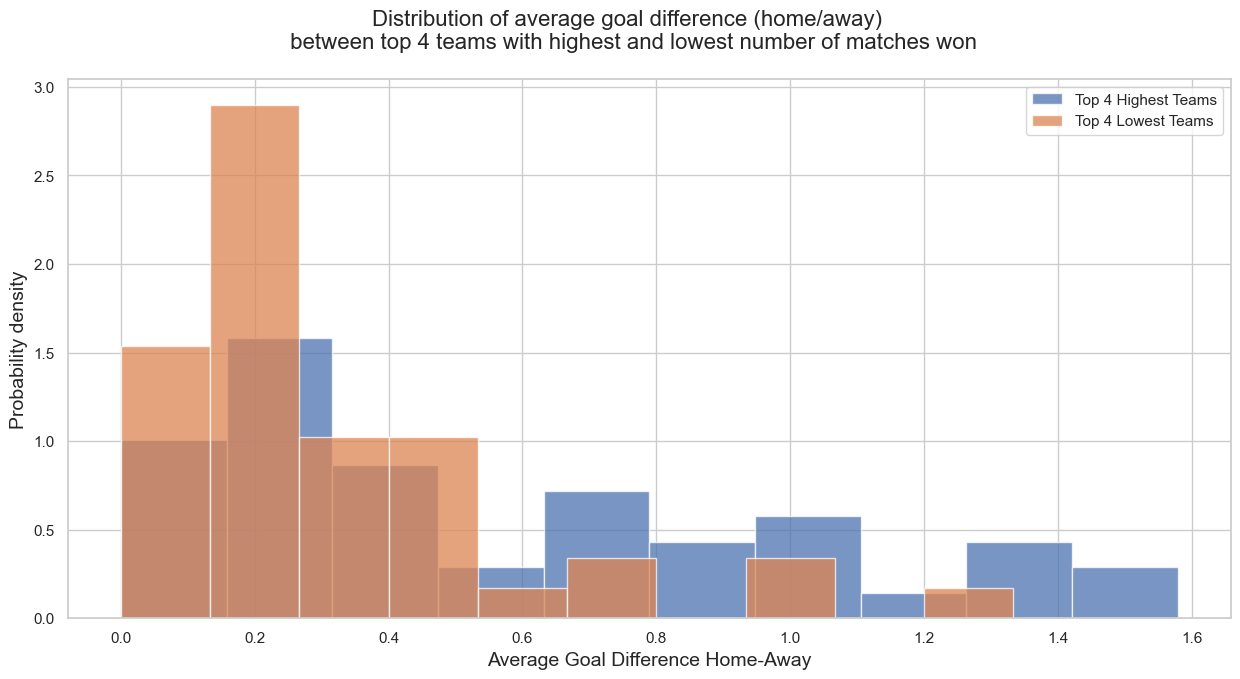

In [461]:
""" Plotting the distribution of average goal difference (home/away) between top 4 teams with highest and lowest number of mathches won """
fig = plt.figure(figsize = (15, 7))
ax = fig.add_subplot(111)


plt.hist(top_4_highest['avg_goal_diff'], label= "Top 4 Highest Teams",
                     density= True,
                     alpha=0.75)
plt.hist(top_4_lowest['avg_goal_diff'], label= "Top 4 Lowest Teams",
                       density= True,
                       alpha=0.75)


plt.suptitle("Distribution of average goal difference (home/away) \n between top 4 teams with highest and lowest number of matches won", fontsize= 16)
plt.xlabel("Average Goal Difference Home-Away", fontsize= 14)
plt.ylabel("Probability density", fontsize= 14)
plt.legend() 
plt.show()

### Teams Attributes Correlation

In order to predict game outcome, we have to see the correlations between the attributes.

In [462]:
""" Merging teams and team_attributes datasets"""
merge_teams = df_teams.copy()
df = pd.merge(merge_teams, team_attributes, how="left", on="team_api_id") 
cols_available = [col for col in df.columns if "_fifa_" not in col and "id_x" not in col and "id_y" not in col]
df_team_attributes = df[cols_available]

In [587]:
""" Changing team_attributes date column value to datetime """
df_team_attributes['date'] = pd.to_datetime(df_team_attributes['date'])

In [464]:
""" Changing df_matches date column value to datetime """
df_matches['date'] = pd.to_datetime(df_matches['date'])

I also created a new value for winning rate of that specific date which takes the last 2 years of matches.

In [588]:
""" Calculating current team winning rate by taking last 2 years of matches"""
teams = df_team_attributes['team_long_name'].unique()
team_winning_rating = []

for i in range(0, len(df_team_attributes)):
    date = df_team_attributes.iloc[i]['date']
    team = df_team_attributes.iloc[i]['team_long_name']

    df_team_matches = df_matches[(df_matches['home_team_name'] == team) | (df_matches['away_team_name'] == team)] 
    df_matches_last_2_years = df_team_matches[(df_team_matches['date'] < date) & (df_team_matches['date'] > pd.to_datetime(str(date.year - 2)))]
    df_won_matches_last_2_years = df_matches_last_2_years[df_matches_last_2_years['winner_team_name'] == team]
    
    if len(df_matches_last_2_years) == 0:
        winning_rate = 0
    else:
        winning_rate = len(df_won_matches_last_2_years) / len(df_matches_last_2_years)
    
    team_winning_rating.append(winning_rate)
 
df_team_attributes['current_winning_rate'] = team_winning_rating

In [466]:
cat_team_attr_columns = df_team_attributes.select_dtypes(include=['object']).columns.tolist()
cols_team_attr_available = [col for col in df_team_attributes.columns if col not in cat_team_attr_columns]
cols_team_attr_available.remove('date')
cols_team_attr_available.remove('team_api_id')

Now, I plotted a heatmap to see the correlations between the team attributes. 

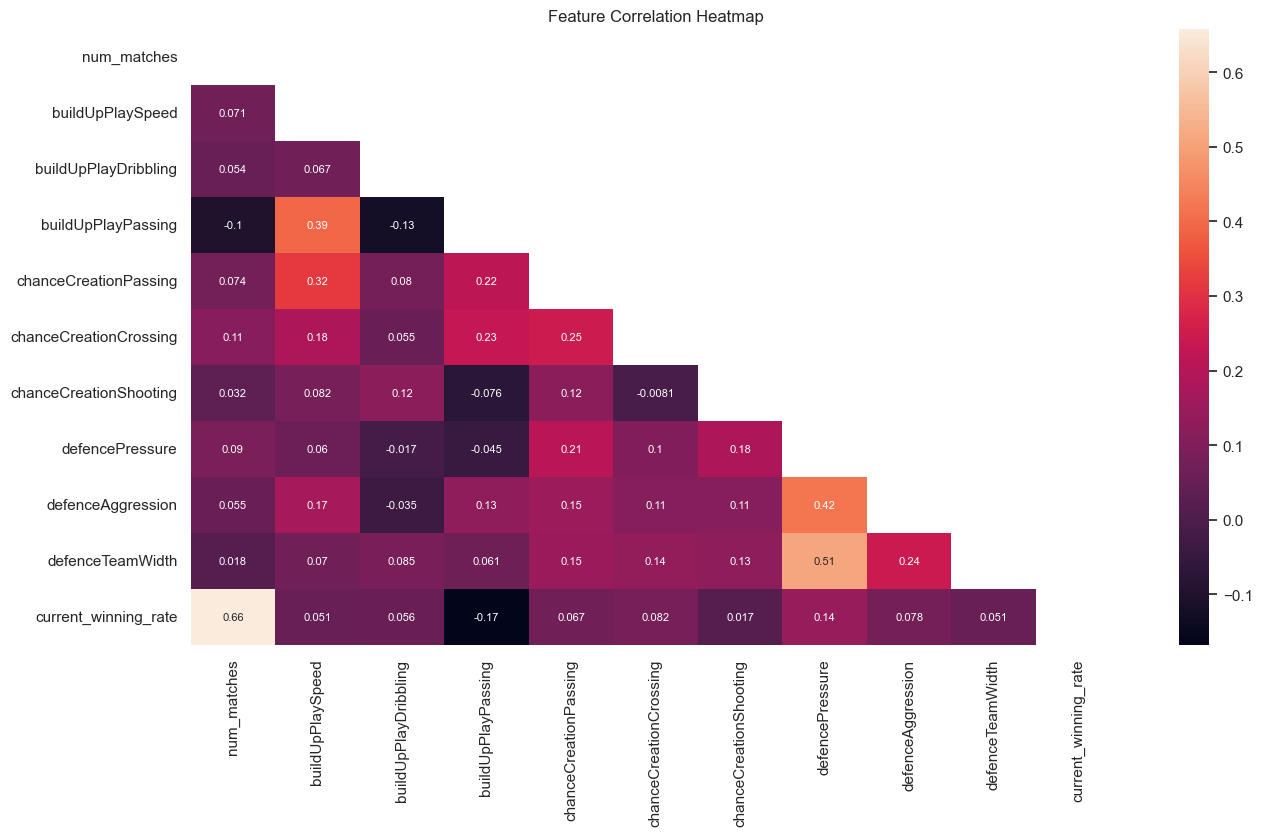

In [467]:
corr_df = df_team_attributes[cols_team_attr_available].corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr_df, annot=True, mask=np.triu(corr_df), annot_kws={"fontsize":8})
plt.title("Feature Correlation Heatmap")
plt.show()

In [468]:
""" Calculating correlations with current_winnng_rate """
cols_team_attr_available.remove('current_winning_rate')
winning_rate = df_team_attributes['current_winning_rate']
corr_win_rate = df_team_attributes[cols_team_attr_available].corrwith(winning_rate)
corr_win_rate = corr_win_rate.sort_values()

I also wanted to see the correlation between other team attributes and the team winning rate.
* We can see the largest correalation between winning rate and number of matches
* Deffence pressure is also important to have a high winning rate
* The strongest negative correlation we can see with build up play passing

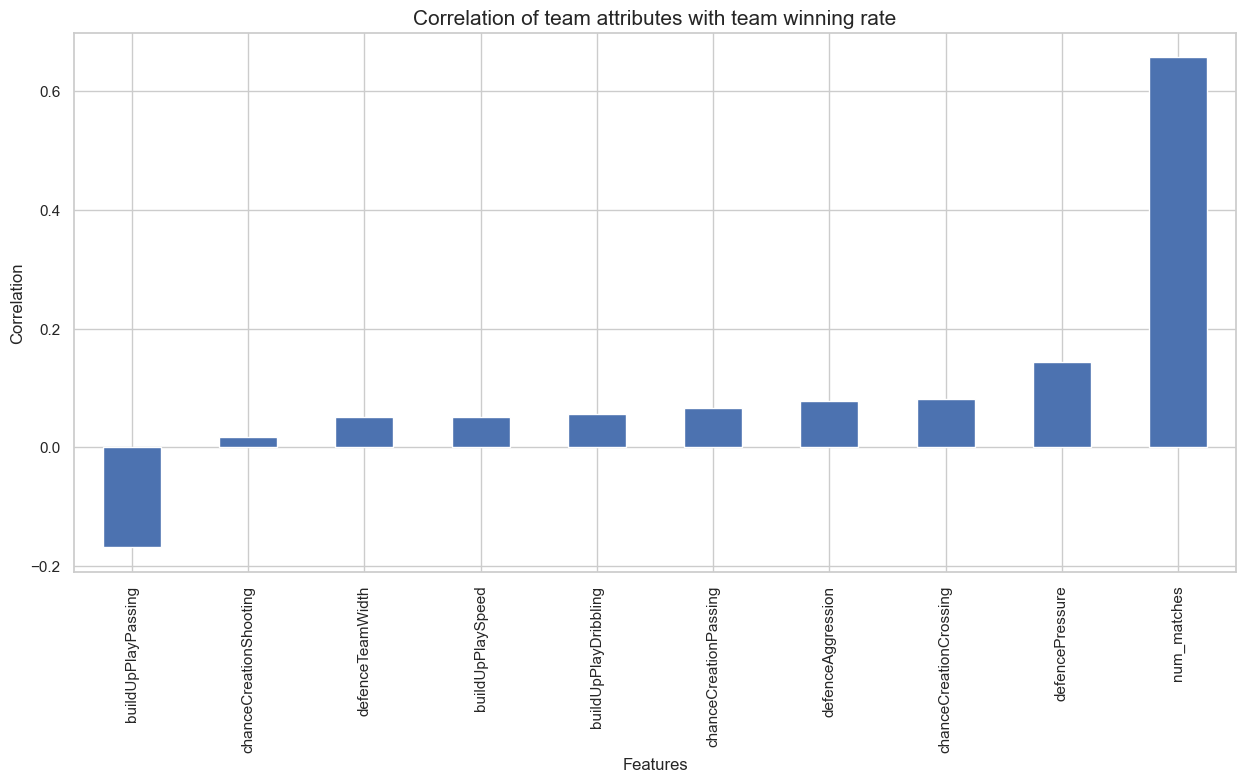

In [469]:
""" Plotting correlation between different team attributs and their current winning rate """
plt.figure(figsize=(15, 7))
corr_win_rate.plot(kind='bar')
plt.xlabel("Features")
plt.ylabel('Correlation') 
plt.title('Correlation of team attributes with team winning rate', fontsize=15)
plt.show()

### Player Analysis

In [470]:
""" Converting player_attributes date to datetime"""
df_player_attributes['date'] = pd.to_datetime(df_player_attributes['date'])

I plotted the overall ratings over the years. We can see that the median of the overall_rating is around 70 

Text(0.5, 0.95, 'Players Overall Rating Distribution over the years')

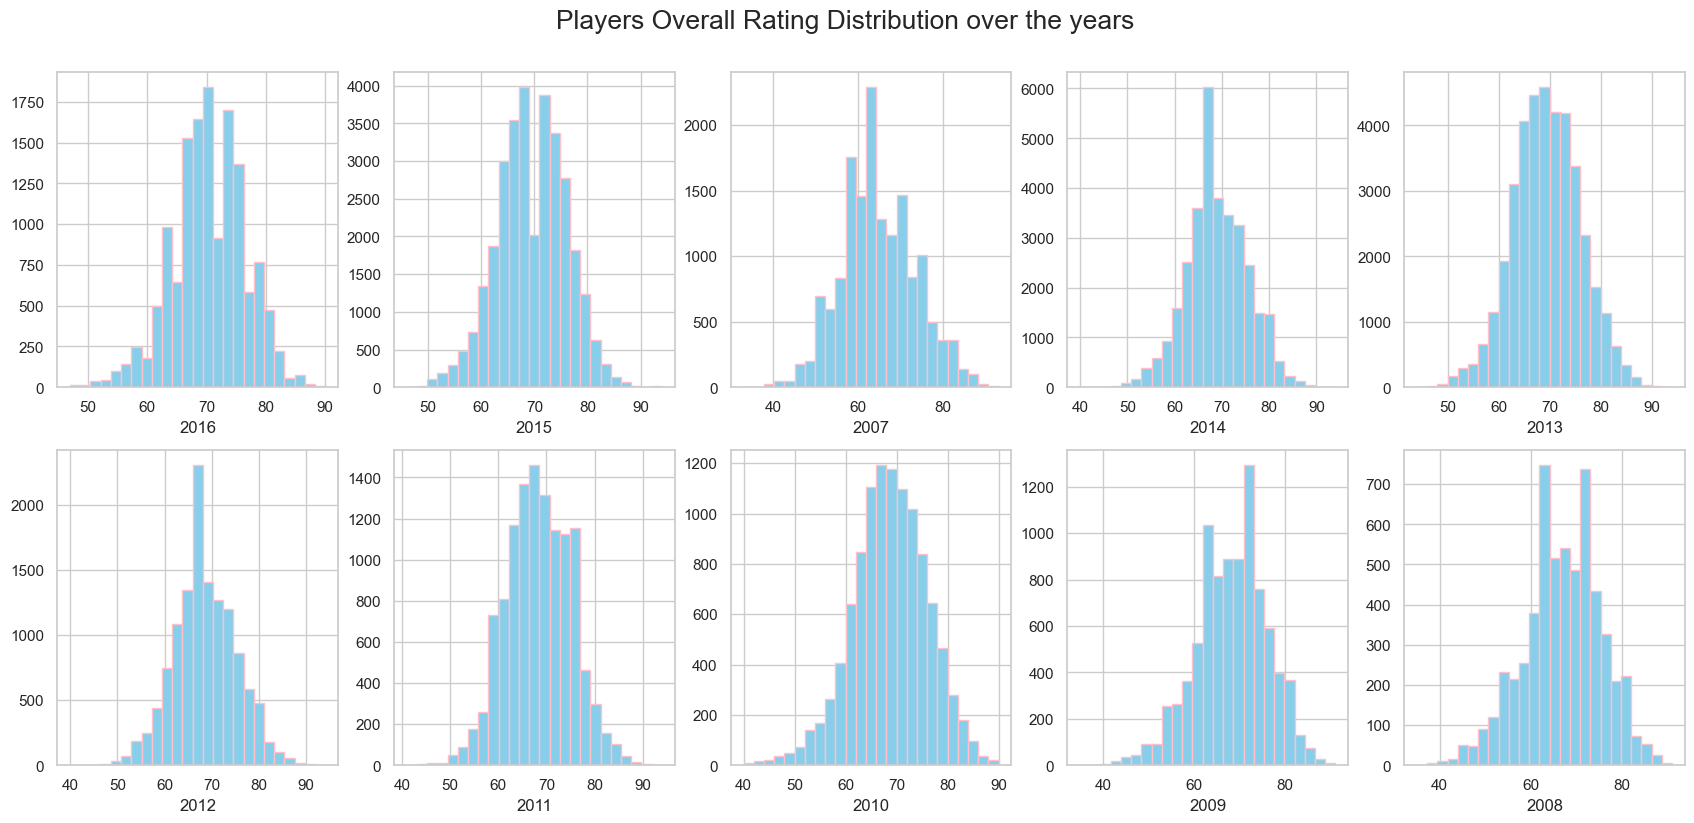

In [471]:
""" Plotting overall rating of players over the years """
years = df_player_attributes['date'].dt.year.unique()

fig, axes = plt.subplots(2, 5, figsize=(21, 9))
i = 0
j = 0

for year in years:
  if i < 2:
    if j < 5: 

        ovr = df_player_attributes[df_player_attributes['date'].dt.year == year]['overall_rating'] 
        axes[i][j].hist(ovr, bins=25, color = "skyblue", ec="pink")
        axes[i][j].set_xlabel(year)  
 
        j+=1
        if j == 5:
            i+=1
            j=0
            
fig.suptitle("Players Overall Rating Distribution over the years", fontsize=19, y=0.95)

In [472]:
""" Merging players and player_attributes tables """
df1 = df_player_attributes.reset_index(drop=True)
df1 = df1.iloc[: , 1:]
df1.pop("player_fifa_api_id")

df2 = df_players.reset_index(drop=True)
df2 = df2.iloc[: , 1:]
df2.pop("player_fifa_api_id")

df_players_attr = pd.merge(df1, df2, how="left", right_on='player_api_id', left_on='player_api_id')

### Best and Worst Players Overall

Based on overall_rating we can find worst and best players. Therefore, I calculated the total overall rating and took top 5 best and worst players.

In [473]:
""" Gathering all existing players in matches dataset """
all_players = df_matches[player_cols].values.tolist()
all_players = [item for sublist in all_players for item in sublist] 

In [474]:
""" Taking all players that are also in players_attributes dataset """
df_available_players = df_players_attr[df_players_attr['player_api_id'].isin(all_players)]

In [475]:
""" Calculating players average overall rating """
ovr_sort = df_available_players.sort_values('overall_rating', ascending=False)
ovr_sort = ovr_sort[['player_name','overall_rating']]
players = ovr_sort['player_name'].unique()

players_avg_overall_rating = {player: np.average((ovr_sort[ovr_sort['player_name'] == player]['overall_rating']))
                              for player in players}

players_avg_overall_rating = dict(sorted(players_avg_overall_rating.items(), key=lambda item: item[1], reverse=True))

The best players were:
* Lionel Messi with 92.2 total average overall_rating
* Cristiano Ronaldo with 91.3 total average overall_rating
* Franck Ribery with 88.5 total average overall_rating
* Andres Iniesta with 88.32 total average overall_rating
* Zlatan Ibrahimovic with 88.28 total average overall_rating

In [476]:
""" Printng out the top 5 best players with highest overall rating """
best_players = dict(list(players_avg_overall_rating.items())[:5])
best_players

{'Lionel Messi': 92.1923076923077,
 'Cristiano Ronaldo': 91.28,
 'Franck Ribery': 88.45833333333333,
 'Andres Iniesta': 88.32,
 'Zlatan Ibrahimovic': 88.28571428571429}

In [477]:
""" Taking top 4 overall best players overall rating change overtime """
df_best_players_over_time = df_players_attr[['player_name','overall_rating', 'date']]
df_best_players_over_time = df_best_players_over_time[df_best_players_over_time['player_name'].isin(list(best_players.keys()))]

I wanted to see how overall_rating changes overtime for these best players:
* Lionel Messi overal_rating was growing up until 2008 and then was at plateu for a few years. Then grew steadily in 2011 and then also grew from 2015
* Christiano Ronaldo was the top rated out of all these top 5 players up until 2009 when Lionel Messi surpassed Christiano Ronaldo.
* Franc Ribery overall rating was falling down from 2014
* Andres Iniesta overall rating was faling down from 2012
* Zlatan Ibrahimovic rating reached bottom in 2010 but after that was growing up until 2015.

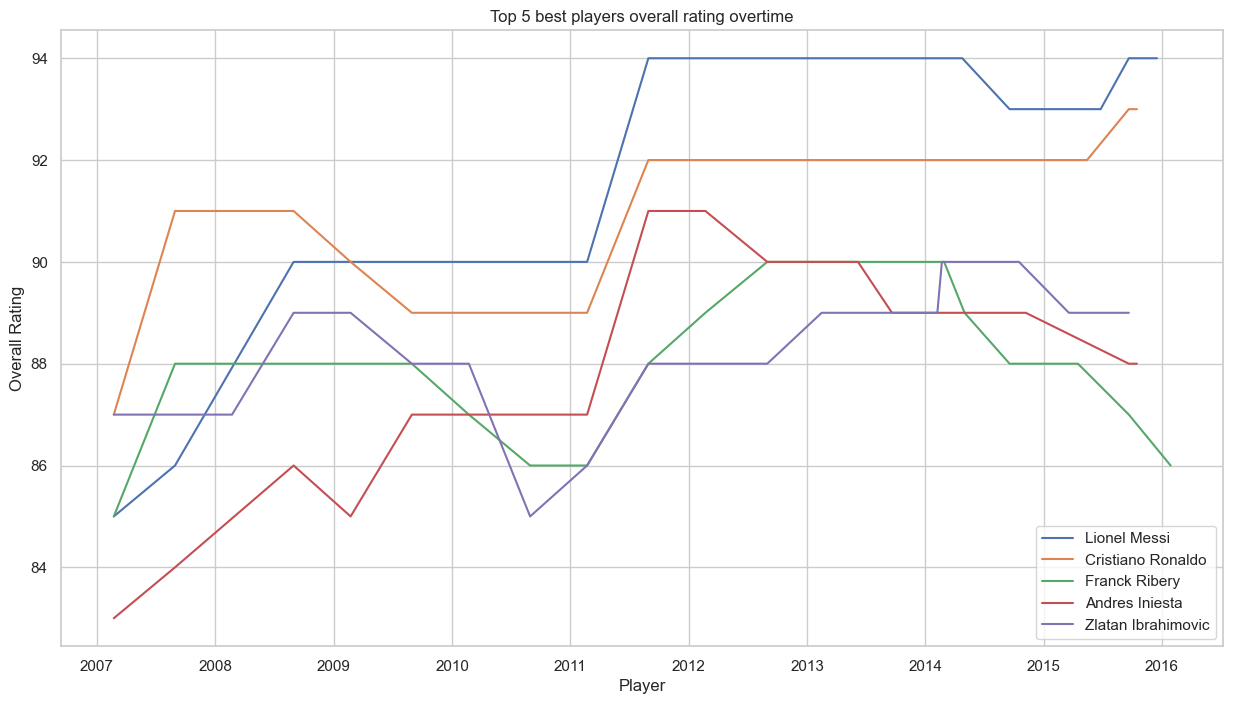

In [478]:
""" Ploting how overall rating changed for top 5 best players """
fig = plt.figure(figsize = (15, 8))

for player in best_players:
    rating = list(df_best_players_over_time[df_best_players_over_time['player_name'] == player]['overall_rating'])
    date = list(df_best_players_over_time[df_best_players_over_time['player_name'] == player]['date']) 
        
    plt.plot(date, rating, label=player)
 
plt.legend(loc="lower right",  prop = {"size" : 11})

plt.title("Top 5 best players overall rating overtime")
plt.xlabel("Player")
plt.ylabel("Overall Rating")
plt.show()

The top 5 worst players were:
* Liam Hughes with overall total average rating of 46
* Jordan Kirkpatrick with overall total average rating of 45.5
* Badis Lebbihi with overall total average rating of 45
* Gianluca D'Angelo with overall total average rating of 43.75
* Frederic Schaub with overall total average rating of 43

In [479]:
""" Printing overall worst players"""
worst_players = dict(list(players_avg_overall_rating.items())[-5:])
worst_players

{'Liam Hughes': 46.0,
 'Jordan Kirkpatrick': 45.5,
 'Badis Lebbihi': 45.0,
 "Gianluca D'Angelo": 43.75,
 'Frederic Schaub': 43.0}

In [480]:
""" Taking overall worst players overall_rating change overtime """
df_worst_players_over_time = df_players_attr[['player_name','overall_rating', 'date']]
df_worst_players_over_time = df_worst_players_over_time[df_worst_players_over_time['player_name'].isin(list(worst_players.keys()))]

All the worst players ratings were not changing drastically overtime but for some such as Badis Lebbihi it went from the worst rated in 2007-2008 to best out of the worsts.

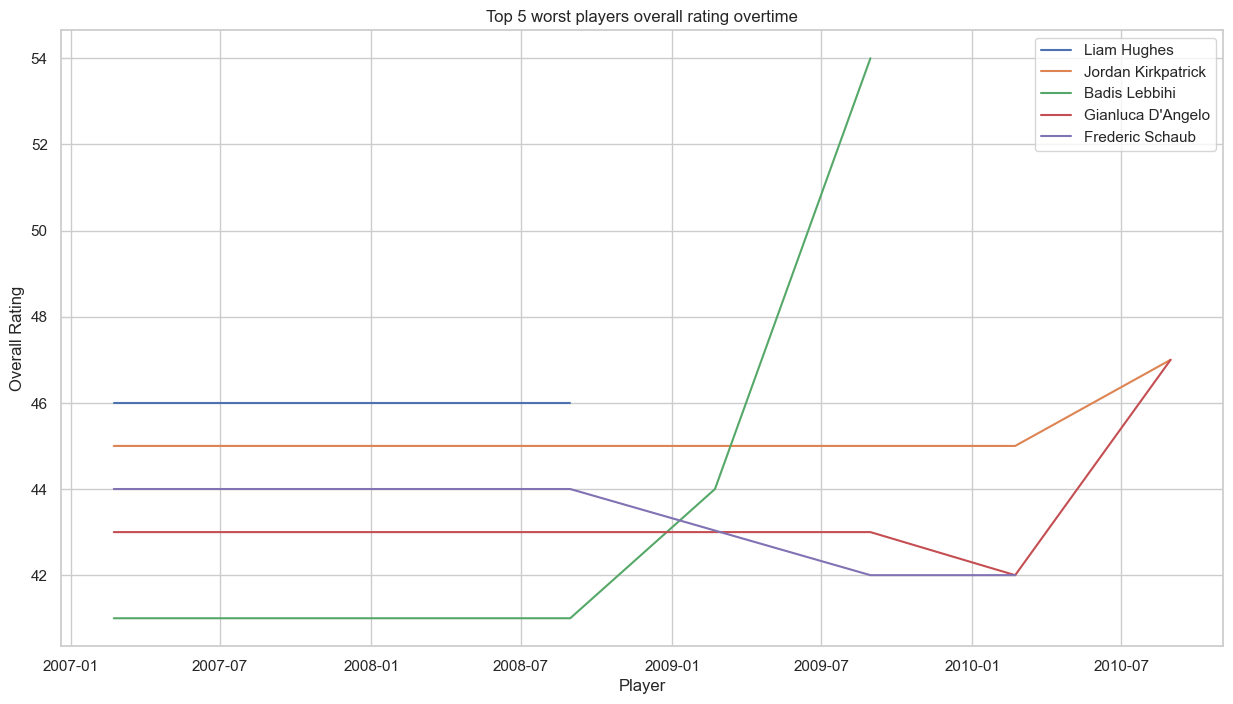

In [481]:
""" Plotting top 5 worst players overall rating change overtime """
fig = plt.figure(figsize = (15, 8))

for player in worst_players:
    rating = list(df_worst_players_over_time[df_worst_players_over_time['player_name'] == player]['overall_rating'])
    date = list(df_worst_players_over_time[df_worst_players_over_time['player_name'] == player]['date']) 
        
    plt.plot(date, rating, label=player)
 
plt.legend(loc="upper right",  prop = {"size" : 11})

plt.title("Top 5 worst players overall rating overtime")
plt.xlabel("Player")
plt.ylabel("Overall Rating")
plt.show()

In [482]:
""" Function that prints and plots information about player"""
def get_info_about_player_from_top5(index, players, label): 
    player_name = list(players.items())[index][0]
 
    player_api_id = float(df_players[df_players['player_name'] == player_name]['player_api_id'])
     
    home_players = [col for col in player_cols if "home" in col]
    away_players = [col for col in player_cols if "away" in col]
   
    rating = list(players.items())[index][1]
    
    home_player_matches = df_matches[df_matches[home_players].applymap(lambda x: str(player_api_id) in str(x)).any(1) == True]
    away_player_matches = df_matches[df_matches[away_players].applymap(lambda x: str(player_api_id) in str(x)).any(1) == True]

    player_teams = list(set(home_player_matches['home_team_name'].unique()) | set(away_player_matches['away_team_name'].unique()))
 
    _, axes = plt.subplots(1, len(player_teams), figsize=(15, 6))

    print(f"The Top {index+1} player with {label} overall rating is {player_name} with rating of {rating}.\n" + 
          f"In total he played {len(home_player_matches) + len(away_player_matches)} number of matches.\n" + 
          f"He player in teams:")

    i = 0
    for team in player_teams:
        num_matches = len(home_player_matches[home_player_matches['home_team_name'] == team])
        num_matches += len(away_player_matches[away_player_matches['away_team_name'] == team]) 

        draws = len(home_player_matches[(home_player_matches['winner_team_name'] == 'draw')])

        matches_won = len(home_player_matches[(home_player_matches['home_team_name'] == team) &
                                              (home_player_matches['winner_team_name'] == team)])

        matches_won += len(away_player_matches[(away_player_matches['away_team_name'] == team) &
                                               (away_player_matches['winner_team_name'] == team)])
                            

        print(f" * {team} where he played {num_matches} matches which {matches_won} of them won.")
 
        data = [(num_matches-matches_won)/num_matches, draws/num_matches,  matches_won/num_matches]
        keys = ['Matches Lost', 'Draw', 'Matches Won']
         
        explode = [0,0, 0.1] 

        color = 'summer'
        if label == "lowest":
            color = 'Reds_d' 

        palette_color = sns.color_palette(color)[index:index+3]

        ax = axes
        if len(player_teams) > 1:
            ax = axes[i]
         
        ax.pie(data, labels=keys, colors=palette_color,
                explode=explode, autopct='%.0f%%')
        ax.set_title(f"{team} win/draw/lost ratio", fontsize=14)
        i+=1 
 

The Top 1 player with highest overall rating is Lionel Messi with rating of 92.1923076923077.
In total he played 225 number of matches.
He player in teams:
 * FC Barcelona where he played 225 matches which 175 of them won.


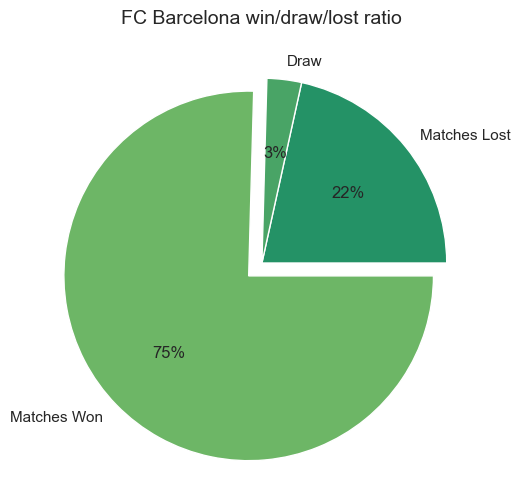

In [483]:
""" Printing and plotting information about the Top 1st player with highest overall rating - Lionel Messi """
get_info_about_player_from_top5(0, best_players, "highest")

The Top 2 player with highest overall rating is Cristiano Ronaldo with rating of 91.28.
In total he played 247 number of matches.
He player in teams:
 * Manchester United where he played 30 matches which 23 of them won.
 * Real Madrid CF where he played 217 matches which 165 of them won.


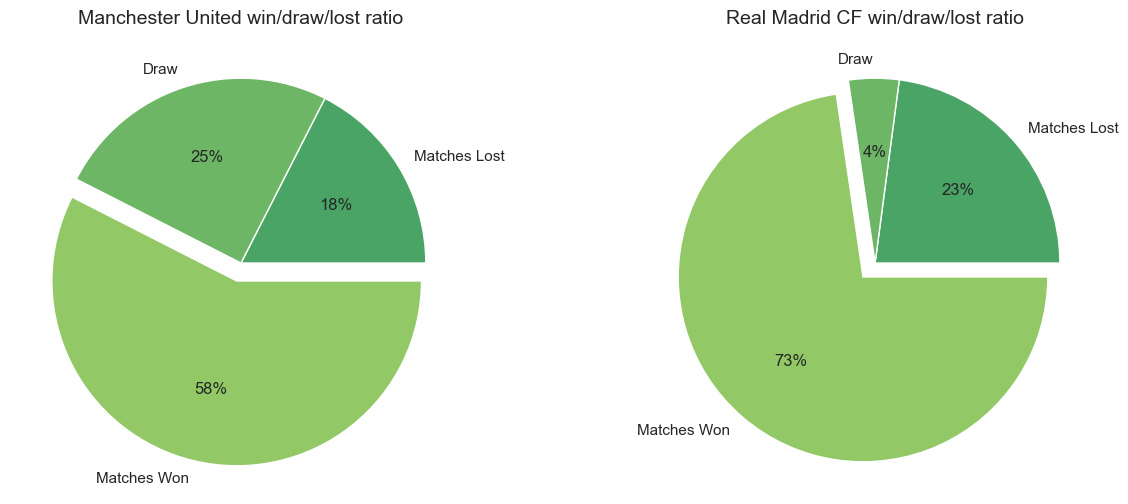

In [484]:
""" Printing and plotting information about the Top 2nd player with highest overall rating - Christiano Ronaldo """
get_info_about_player_from_top5(1, best_players, "highest")

The Top 3 player with highest overall rating is Franck Ribery with rating of 88.45833333333333.
In total he played 138 number of matches.
He player in teams:
 * FC Bayern Munich where he played 138 matches which 104 of them won.


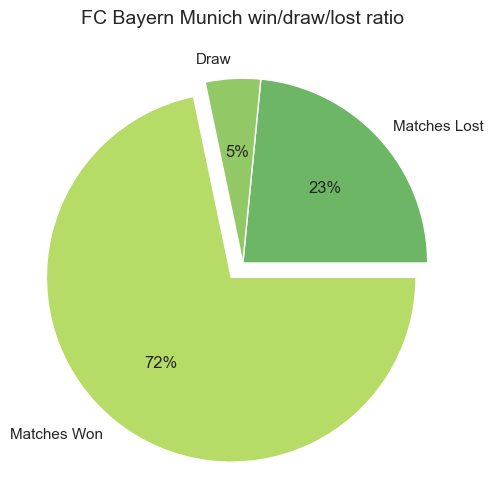

In [485]:
""" Printing and plotting information about the Top 3rd player with highest overall rating - Franck Ribery """
get_info_about_player_from_top5(2, best_players, "highest")

The Top 4 player with highest overall rating is Andres Iniesta with rating of 88.32.
In total he played 171 number of matches.
He player in teams:
 * FC Barcelona where he played 171 matches which 134 of them won.


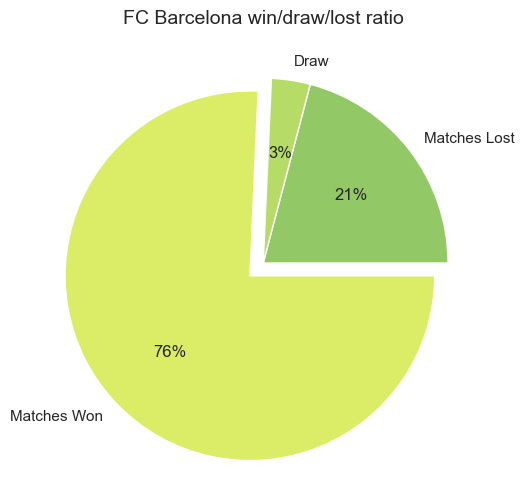

In [486]:
""" Printing and plotting information about the Top 4th player with highest overall rating - Andres Iniesta """
get_info_about_player_from_top5(3, best_players, "highest")

The Top 5 player with highest overall rating is Zlatan Ibrahimovic with rating of 88.28571428571429.
In total he played 215 number of matches.
He player in teams:
 * Inter where he played 26 matches which 18 of them won.
 * FC Barcelona where he played 15 matches which 12 of them won.
 * Milan where he played 60 matches which 37 of them won.
 * Paris Saint-Germain where he played 114 matches which 83 of them won.


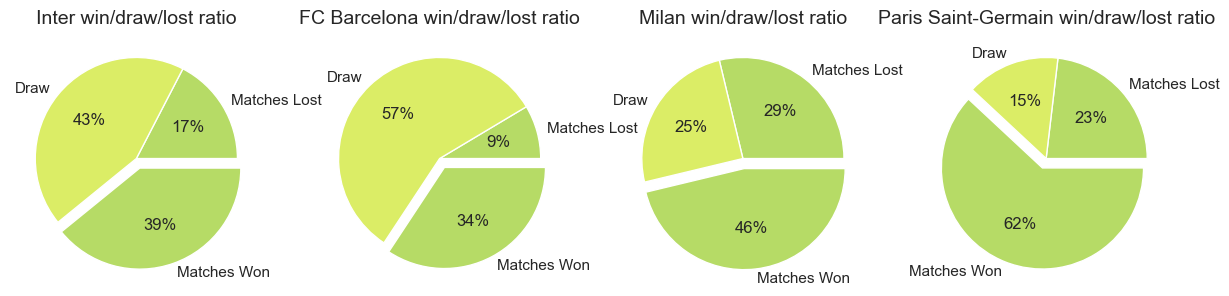

In [487]:
""" Printing and plotting information about the Top 5th player with highest overall rating - Zlatan Ibrahimovic """
get_info_about_player_from_top5(4, best_players, "highest")

The Top 1 player with lowest overall rating is Liam Hughes with rating of 46.0.
In total he played 3 number of matches.
He player in teams:
 * Inverness Caledonian Thistle where he played 3 matches which 1 of them won.


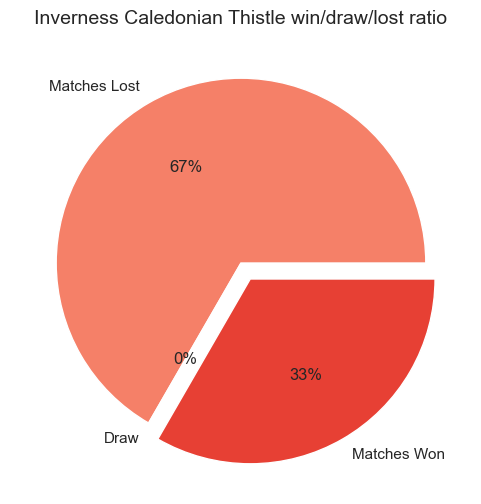

In [488]:
""" Printing and plotting information about the 1st worst player with lowest overall rating - Liam Hughes """
get_info_about_player_from_top5(0, worst_players, "lowest")

The Top 2 player with lowest overall rating is Jordan Kirkpatrick with rating of 45.5.
In total he played 1 number of matches.
He player in teams:
 * Hamilton Academical FC where he played 1 matches which 0 of them won.


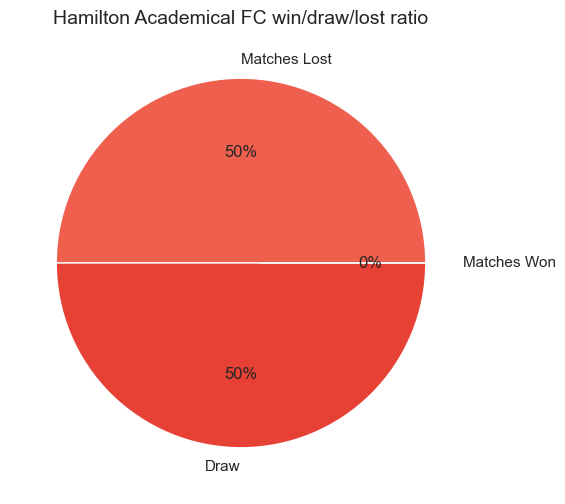

In [489]:
""" Printing and plotting information about the 2nd worst player with lowest overall rating - Jordan Kirkpatrick """
get_info_about_player_from_top5(1, worst_players, "lowest")

The Top 3 player with lowest overall rating is Badis Lebbihi with rating of 45.0.
In total he played 1 number of matches.
He player in teams:
 * SV Zulte-Waregem where he played 1 matches which 0 of them won.


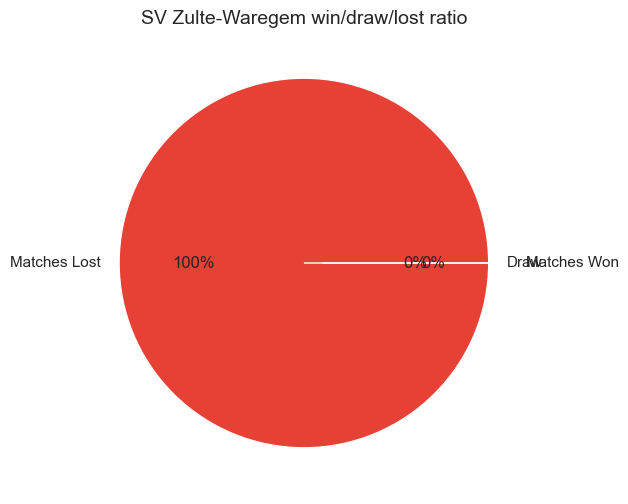

In [490]:
""" Printing and plotting information about the 3rd worst player with lowest overall rating - Badis Lebbihi """
get_info_about_player_from_top5(2, worst_players, "lowest")

The Top 4 player with lowest overall rating is Gianluca D'Angelo with rating of 43.75.
In total he played 5 number of matches.
He player in teams:
 * Grasshopper Club Zürich where he played 5 matches which 4 of them won.


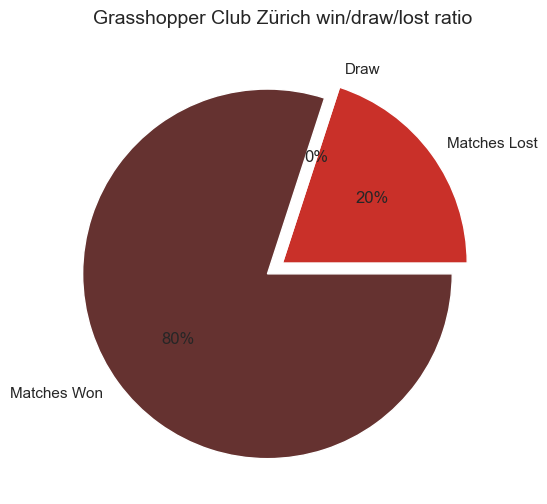

In [491]:
""" Printing and plotting information about the 4th worst player with lowest overall rating - Gianluca D'Angelo """
get_info_about_player_from_top5(3, worst_players, "lowest")

The Top 5 player with lowest overall rating is Frederic Schaub with rating of 43.0.
In total he played 4 number of matches.
He player in teams:
 * FC Aarau where he played 4 matches which 1 of them won.


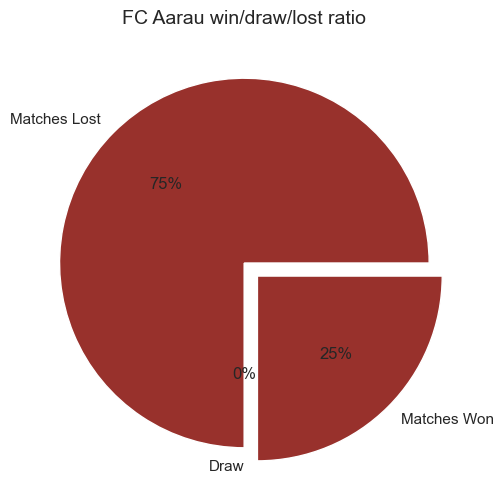

In [492]:
""" Printing and plotting information about the 5th worst player with lowest overall rating - Frederic Schaub """
get_info_about_player_from_top5(4, worst_players, "lowest")

### Players Age Distribution

Now I created a new feature for age which counts difference between current date and birthday

In [493]:
""" Converting player birthday to datetime"""
df_players_attr['birthday'] = pd.to_datetime(df_players_attr['birthday']) 

In [494]:
""" Creating new age feature """
age = df_players_attr['date'] - df_players_attr['birthday']
df_players_attr['current_age'] = age
df_players_attr['current_age'] = df_players_attr['current_age'] / np.timedelta64(1, 'Y')
df_players_attr['current_age'] = df_players_attr['current_age'].apply(np.floor)
df_players_attr['current_age'] = df_players_attr['current_age'].astype('int')

We can see that the most of the players are of age around 25 over all of the years.

Text(0.5, 0.95, 'Players Age Distribution over the years')

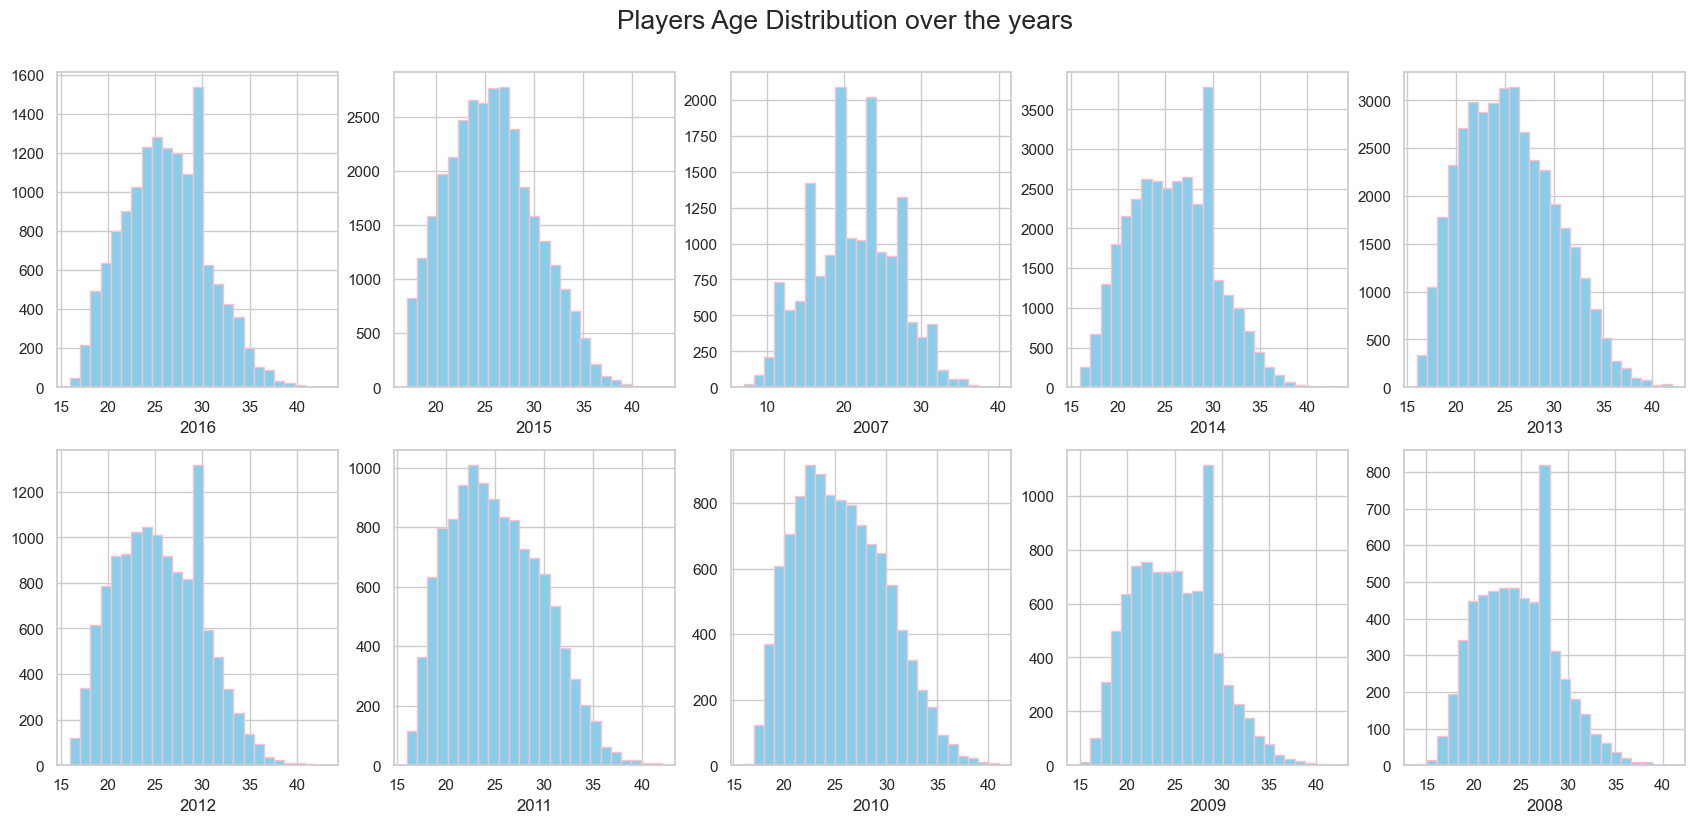

In [495]:
""" Plotting the distribution of age overtime """
years = df_players_attr['date'].dt.year.unique()

fig, axes = plt.subplots(2, 5, figsize=(21, 9))
i = 0
j = 0

for year in years:
  if i < 2:
    if j < 5: 

        ages = df_players_attr[df_players_attr['date'].dt.year == year]['current_age'] 
        axes[i][j].hist(ages, bins=25, color = "skyblue", ec="pink")
        axes[i][j].set_xlabel(year)  
 
        j+=1
        if j == 5:
            i+=1
            j=0
            
fig.suptitle("Players Age Distribution over the years", fontsize=19, y=0.95)


#### Oldest and Youngest Players

I also wanted to see which players are the youngest and the oldest by taking the maximum and minimum of current age column.

In [496]:
""" Getting the oldest and youngest player age"""
oldest_age = max(df_players_attr['current_age'])
youngest_age = min(df_players_attr['current_age'])

There were 3 players with oldest age (43)
* Brad Friedel
* Mark Schwarzer
* Rob van Dijk

In [497]:
""" Printing out the information about the oldest players in the dataset """
oldest_players = df_players_attr[df_players_attr['current_age'] == oldest_age]['player_name'].unique()
print(f"The oldest players of age {oldest_age} in the dataset were {oldest_players}")

The oldest players of age 43 in the dataset were ['Brad Friedel' 'Mark Schwarzer' 'Rob van Dijk']


We can see that overall rating of the oldest players were falling down over the years.

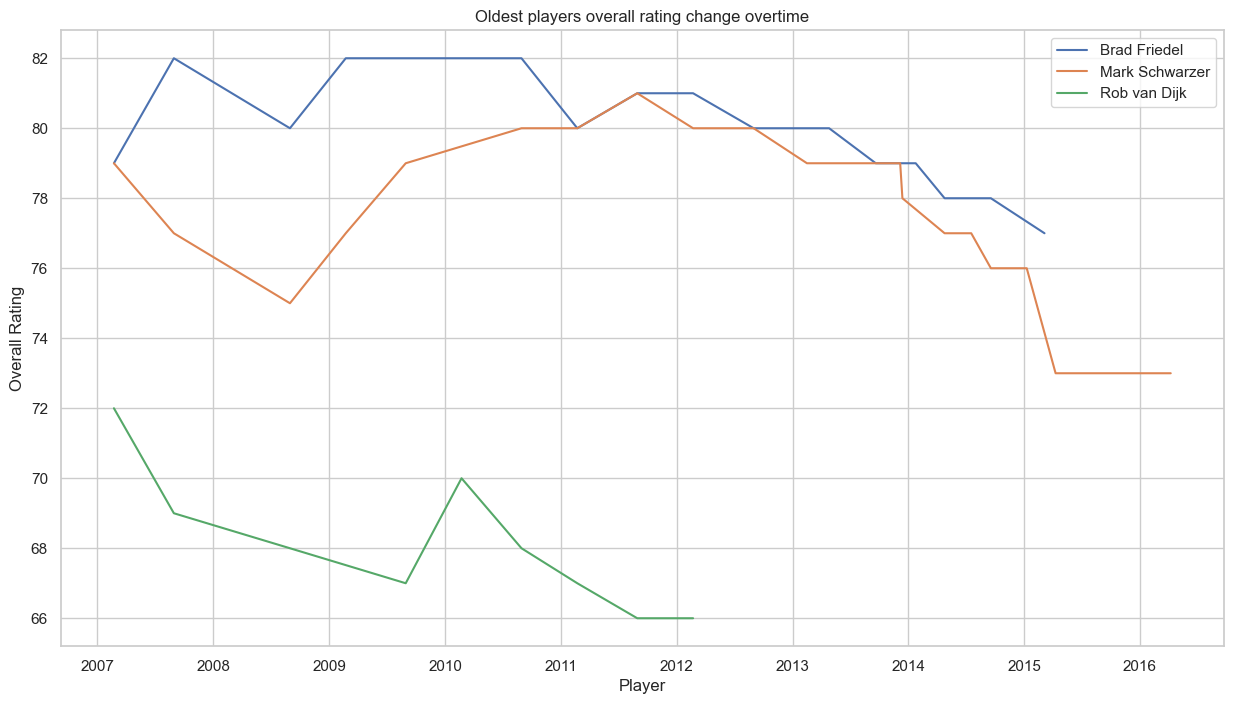

In [498]:
""" Plotting the overall_rating change for the oldest players overtime """
fig = plt.figure(figsize = (15, 8))

for player in oldest_players:
    rating = list(df_players_attr[df_players_attr['player_name'] == player]['overall_rating'])
    date = list(df_players_attr[df_players_attr['player_name'] == player]['date']) 
        
    plt.plot(date, rating, label=player)
 
plt.legend(loc="upper right",  prop = {"size" : 11})

plt.title("Oldest players overall rating change overtime")
plt.xlabel("Player")
plt.ylabel("Overall Rating")
plt.show()

We can also see that not overall rating but also the potential of the oldest players were falling down over the years.

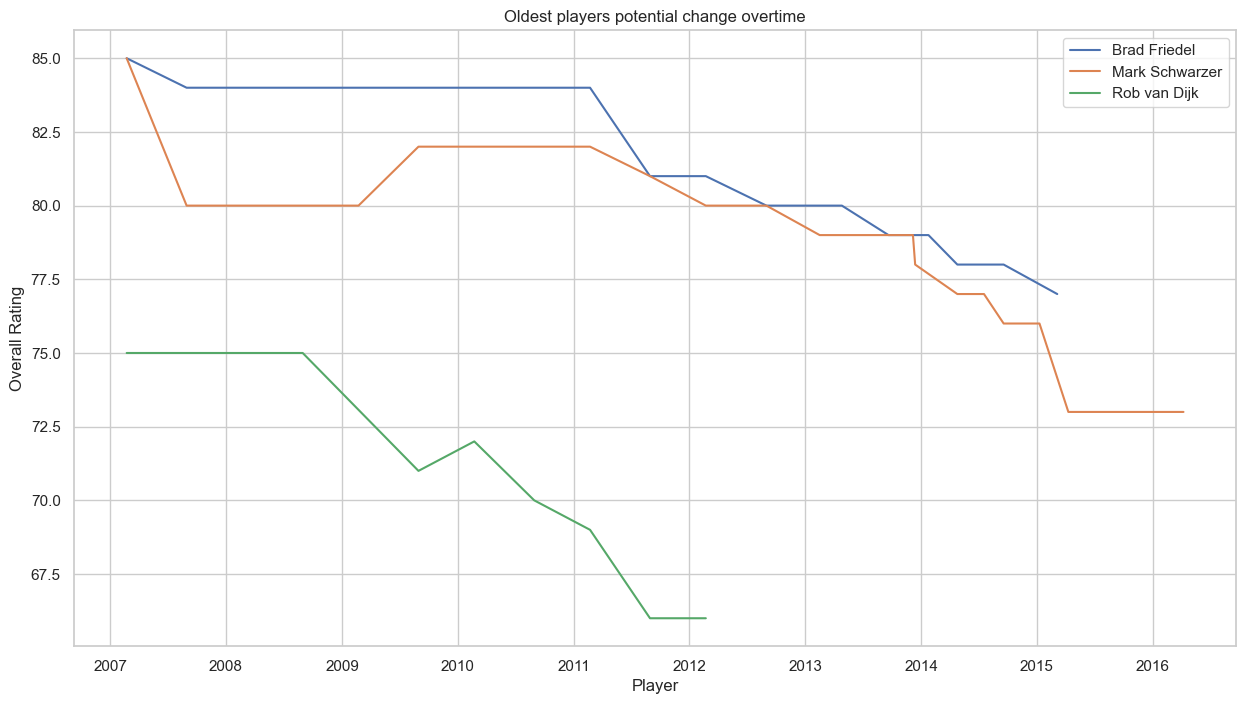

In [499]:
""" Plotting the potential change for oldest players in the dataset """
fig = plt.figure(figsize = (15, 8))

for player in oldest_players:
    rating = list(df_players_attr[df_players_attr['player_name'] == player]['potential'])
    date = list(df_players_attr[df_players_attr['player_name'] == player]['date']) 
        
    plt.plot(date, rating, label=player)
 
plt.legend(loc="upper right",  prop = {"size" : 11})

plt.title("Oldest players potential change overtime")
plt.xlabel("Player")
plt.ylabel("Overall Rating")
plt.show()

We can see that the dataset had some outliers that does not seem right.

In [500]:
""" Printing out the youngest players"""
df_players_attr[df_players_attr['current_age'] == youngest_age]

player_api_id       date  overall_rating  potential preferred_foot  \
63879         618878 2007-02-22            70.0       86.0          right   
85954         682552 2007-02-22            64.0       84.0          right   

      attacking_work_rate defensive_work_rate  crossing  finishing  \
63879              medium              medium      12.0       12.0   
85954              medium              medium      39.0       66.0   

       heading_accuracy  ...  gk_diving  gk_handling  gk_kicking  \
63879              12.0  ...       72.0         64.0        74.0   
85954              64.0  ...        6.0         12.0        11.0   

       gk_positioning  gk_reflexes           player_name   birthday  height  \
63879            68.0         76.0  Gianluigi Donnarumma 1999-02-25  195.58   
85954             8.0          9.0         Jonathan Leko 1999-04-24  182.88   

       weight  current_age  
63879     198            7  
85954     141            7  

[2 rows x 45 columns]

By reading some of the leagues posts about their youngest players, I've decided to drop all the players whose age were lower than 16 as most of those youngest players were indeed around 16 years old.

Premiere League Youngests (https://theanalyst.com/eu/2022/09/youngest-premier-league-players/) 

In [501]:
""" Setting up new youngest age"""
youngest_age = 16

There are way more young players than older ones.

In [502]:
""" Printing out the number of youngest players in the dataset """
youngest_players = df_players_attr[df_players_attr['current_age'] == youngest_age]['player_name'].unique()
print(f"There are {len(youngest_players)} players of age {youngest_age}")

There are 724 players of age 16


In [503]:
""" Dropping players that are too young """
df_players_attr_too_young_dropped = df_players_attr[df_players_attr['current_age'] >= 16] 

I have gathered the information about oldest and youngest players. Now I want to see whether young players has some remarkable differences between their potential.

### Hypothesis testing
#### Potential differences between youngest and oldest players in the dataset

Considering players over 35 and below 20, do younger players have significantly higher potential?

Let's define a few parameters:

* Population here is a young and old players

* Our Parameter of Interest is (μ1 − μ2): mean player potential

* μ1: Mean player potential of players over or equal to 35

* μ2: Mean player potential of players below or equal to 20

H₀: μ1≤μ2

H₁: μ1>μ2

Significance Level - 5%

In [504]:
""" Getting all players with age larger or equal to 35 """
df_players_over_35 = df_players_attr_too_young_dropped[df_players_attr_too_young_dropped['current_age'] >= 35]
df_players_over_35 = df_players_over_35.sample(3000)

""" Getting all players with age smaller or equal to 20 """
df_players_below_20 = df_players_attr_too_young_dropped[df_players_attr_too_young_dropped['current_age'] <= 20]
df_players_below_20 = df_players_below_20.sample(3000)

In [505]:
""" Getting t-test results"""
summary, results = rp.ttest(group1=df_players_below_20['potential'], group1_name= "Players below or equal to 20",
                            group2=df_players_over_35['potential'], group2_name= "Players over or equal to 35")

##### Interpretation

The mean potential value of players of age below or equal to 20, Mean=73.808, was statistically signigicantly higher than players of age over or equal to 35 matches, Mean=71.715; t=4.449, p<0.05

In [506]:
summary

Variable       N       Mean        SD        SE  \
0  Players below or equal to 20  2982.0  73.854460  7.162250  0.131158   
1   Players over or equal to 35  3000.0  71.650000  6.406131  0.116959   
2                      combined  5982.0  72.748913  6.881869  0.088978   

   95% Conf.   Interval  
0  73.597290  74.111630  
1  71.420671  71.879329  
2  72.574484  72.923343

In [507]:
results

Independent t-test    results
0  Difference (Players below or equal to 20 - Pla...     2.2045
1                              Degrees of freedom =   5980.0000
2                                               t =     12.5486
3                           Two side test p value =      0.0000
4                          Difference < 0 p value =      1.0000
5                          Difference > 0 p value =      0.0000
6                                       Cohen's d =      0.3245
7                                       Hedge's g =      0.3245
8                                  Glass's delta1 =      0.3078
9                                Point-Biserial r =      0.1602

There is a statistically significant difference in the mean potential between players over 35 years and below 19

* *t=4.449*
* *p<0.05*

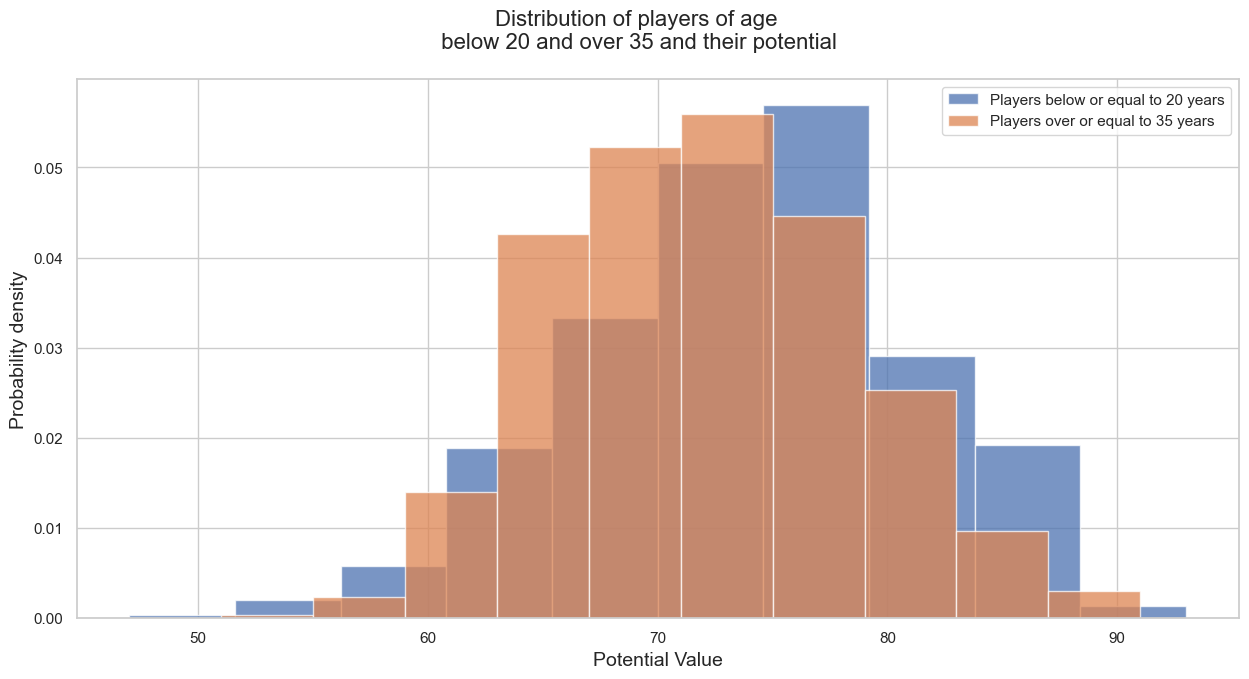

In [508]:
""" Plotting the distribution of players of age below 20 and over 35 and their potential"""
fig = plt.figure(figsize = (15, 7))
ax = fig.add_subplot(111)
 
plt.hist(df_players_below_20['potential'], label= "Players below or equal to 20 years",
                     density= True,
                     alpha=0.75)
plt.hist(df_players_over_35['potential'], label= "Players over or equal to 35 years",
                       density= True,
                       alpha=0.75)


plt.suptitle("Distribution of players of age \n below 20 and over 35 and their potential ", fontsize= 16)
plt.xlabel("Potential Value", fontsize= 14)
plt.ylabel("Probability density", fontsize= 14)
plt.legend() 
plt.show()

### Player Attributes Correlation

I also wanted to see the correlations between age and other attributes.

In [509]:
""" Converting categorical value 'defensive_work_rate' into numeric """

df_players_attr["defensive_work_rate"] = df_players_attr["defensive_work_rate"].astype('category')
df_players_attr['defensive_work_rate'] = df_players_attr['defensive_work_rate'].cat.codes
cols_available.append('defensive_work_rate')

In [510]:
""" Converting categorical value 'attacking_work_rate' into numeric """

df_players_attr["attacking_work_rate"] = df_players_attr["attacking_work_rate"].astype('category')
df_players_attr['attacking_work_rate'] = df_players_attr['attacking_work_rate'].cat.codes
cols_available.append('attacking_work_rate')

In [511]:
""" Converting categorical value 'preferred_foot' into numeric """

df_players_attr["preferred_foot"] = df_players_attr["preferred_foot"].astype('category')
df_players_attr['preferred_foot'] = df_players_attr['preferred_foot'].cat.codes
cols_available.append('preferred_foot')

In [512]:
""" Getting columns without age"""
age = df_players_attr_too_young_dropped['current_age']
cat_columns = df_players_attr.select_dtypes(include=['object']).columns.tolist()
cols_available = [col for col in df_players_attr.columns if col not in cat_columns]
cols_available.remove('player_api_id') 
cols_available.remove('current_age')

In [513]:
""" Getting correlation with current player age """
corr_age = df_players_attr[cols_available].corrwith(age)
corr_age = corr_age.sort_values()

* We can see that overall_rating has a strong positive correlation with age which can indicate that older players have higher overall_rating (more experience)
* Reactions are also strongly positively correlated with age
* Acceleration is strongest negatively correlated with age.

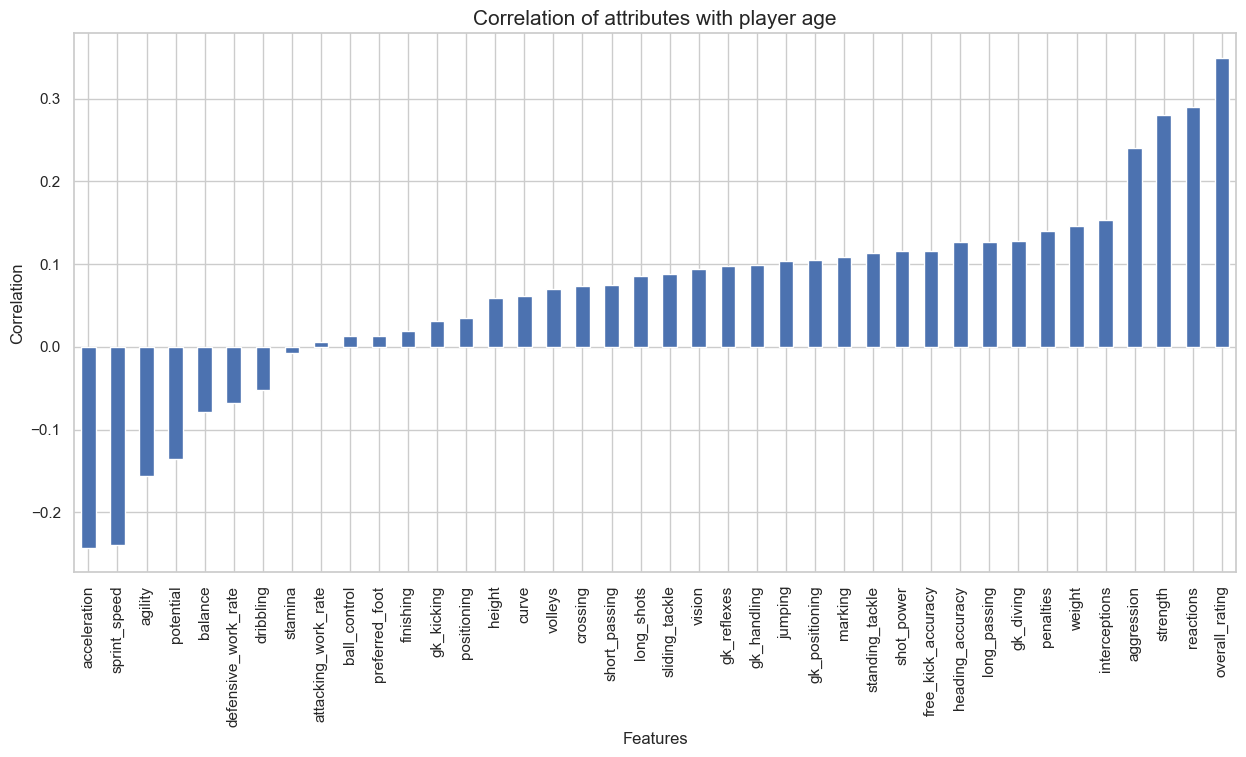

In [514]:
""" Plotting the correlation of attributes with player's current age """
plt.figure(figsize=(15, 7))
corr_age.plot(kind='bar')
plt.xlabel("Features")
plt.ylabel('Correlation') 
plt.title('Correlation of attributes with player age', fontsize=15)
plt.show()

The most strongest positively correlated features with overall_rating:
* Reactions
* Potential 
* Short passing
* Ball control
* Long passing

The most strongest negatively correlated features with overall_rating:
* attacking work rate


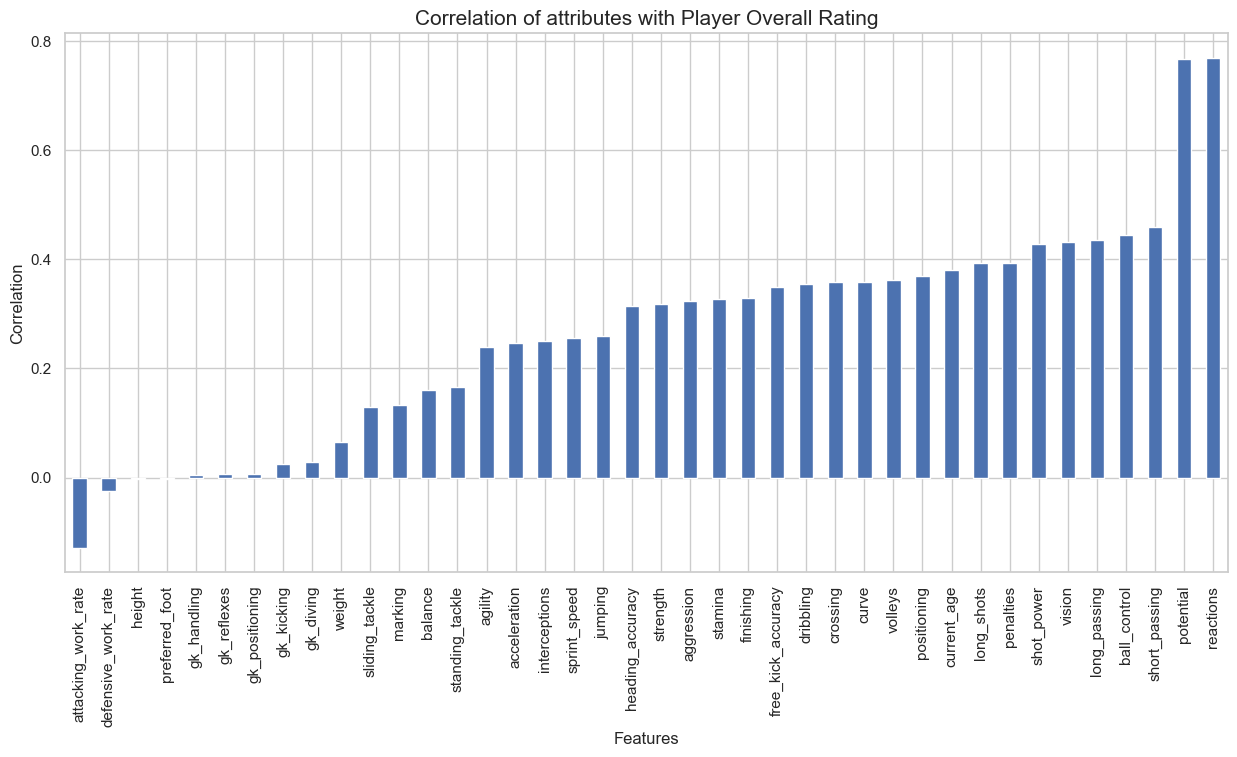

In [515]:
""" Plotting player's attributes correlation with overall_rating """
ovr = df_players_attr['overall_rating']

cols_available = [col for col in df_players_attr.columns if col not in cat_columns and col != "overall_rating" and col != "player_api_id"]
corr_overall_rating = df_players_attr[cols_available].corrwith(ovr)
corr_overall_rating = corr_overall_rating.sort_values()

plt.figure(figsize=(15, 7))
corr_overall_rating.plot(kind='bar')
plt.xlabel("Features")
plt.ylabel('Correlation')
plt.title('Correlation of attributes with Player Overall Rating', fontsize=15)
plt.show()

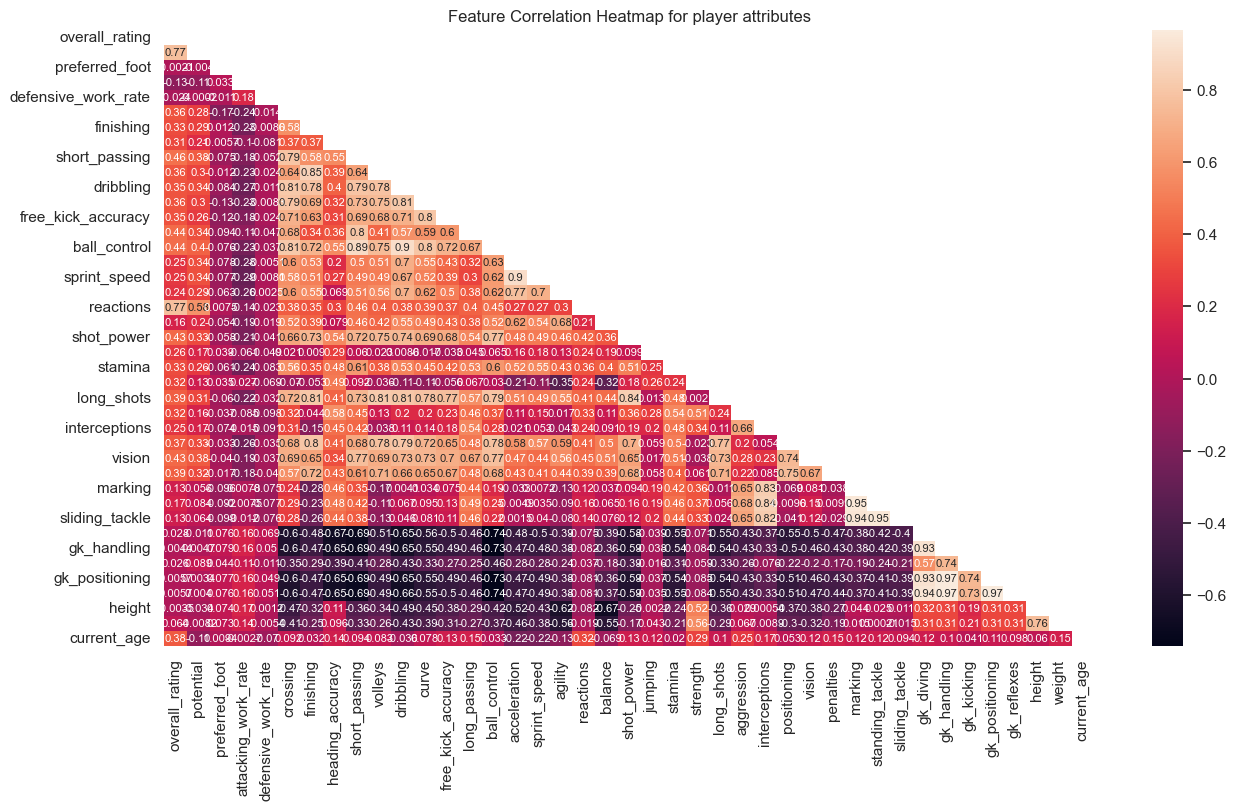

In [516]:
""" Plotting all player attributes correlation heatmap """
cols_available = [col for col in df_players_attr.columns if col not in cat_columns and col != "player_api_id"]

corr_df = df_players_attr[cols_available].corr()

plt.figure(figsize=(15, 8))
sns.heatmap(corr_df, annot=True, mask=np.triu(corr_df), annot_kws={"fontsize":8})
plt.title("Feature Correlation Heatmap for player attributes")
plt.show()

In [517]:
""" Taking pairs of correlations """
upper_corr_mat = corr_df.where(
    np.triu(np.ones(corr_df.shape), k=1).astype(np.bool_))
   
unique_corr_pairs = upper_corr_mat.unstack().dropna()
   
pos_player_attrs = unique_corr_pairs.sort_values(ascending=False) 

Text(0.5, 0.98, 'Top 4 positively correlated fatures')

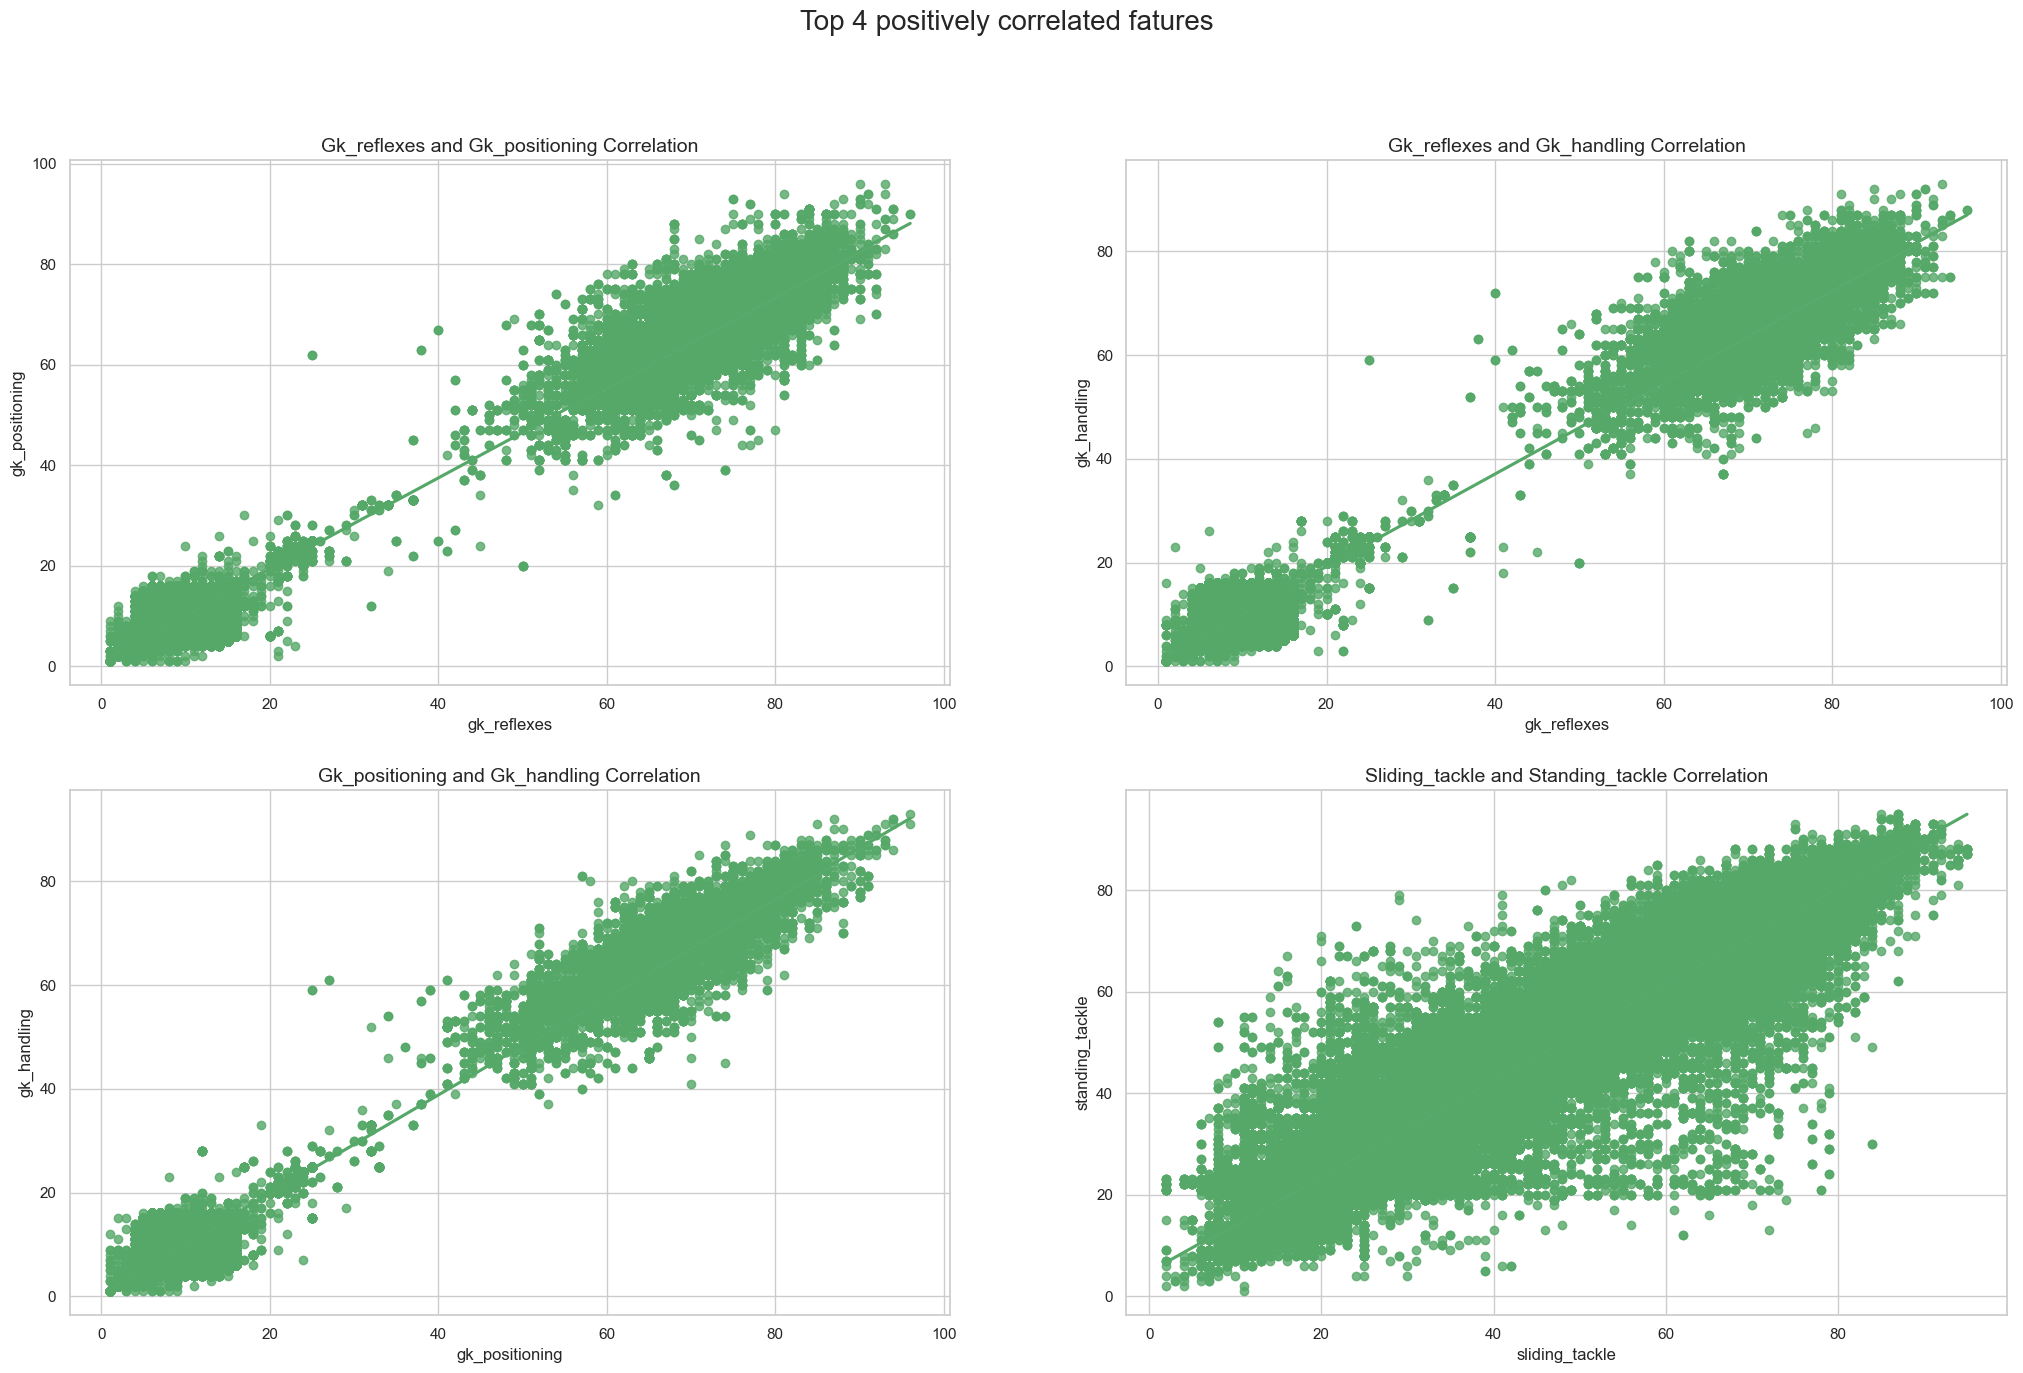

In [518]:
""" Plotting top 4 most positively correlated features for player attributes """
fig, axes = plt.subplots(2, 2, figsize=(25, 15))
i = 0
j = 0

for val in pos_player_attrs.head(4).keys():
  if i < 2:
    if j < 2:
      sns.regplot(x=val[0], y=val[1], data=df_players_attr, marker= 'o', color="g", ax=axes[i][j])
      axes[i][j].set_xlabel(val[0])
      axes[i][j].set_ylabel(val[1])
      axes[i][j].set_title(val[0].capitalize() + " and " + val[1].capitalize() + " Correlation", fontsize=14)
      j+=1
      if j == 2:
        i+=1
        j=0
fig.suptitle("Top 4 positively correlated fatures", fontsize=20)


Text(0.5, 0.98, 'Top 4 negatively correlated fatures')

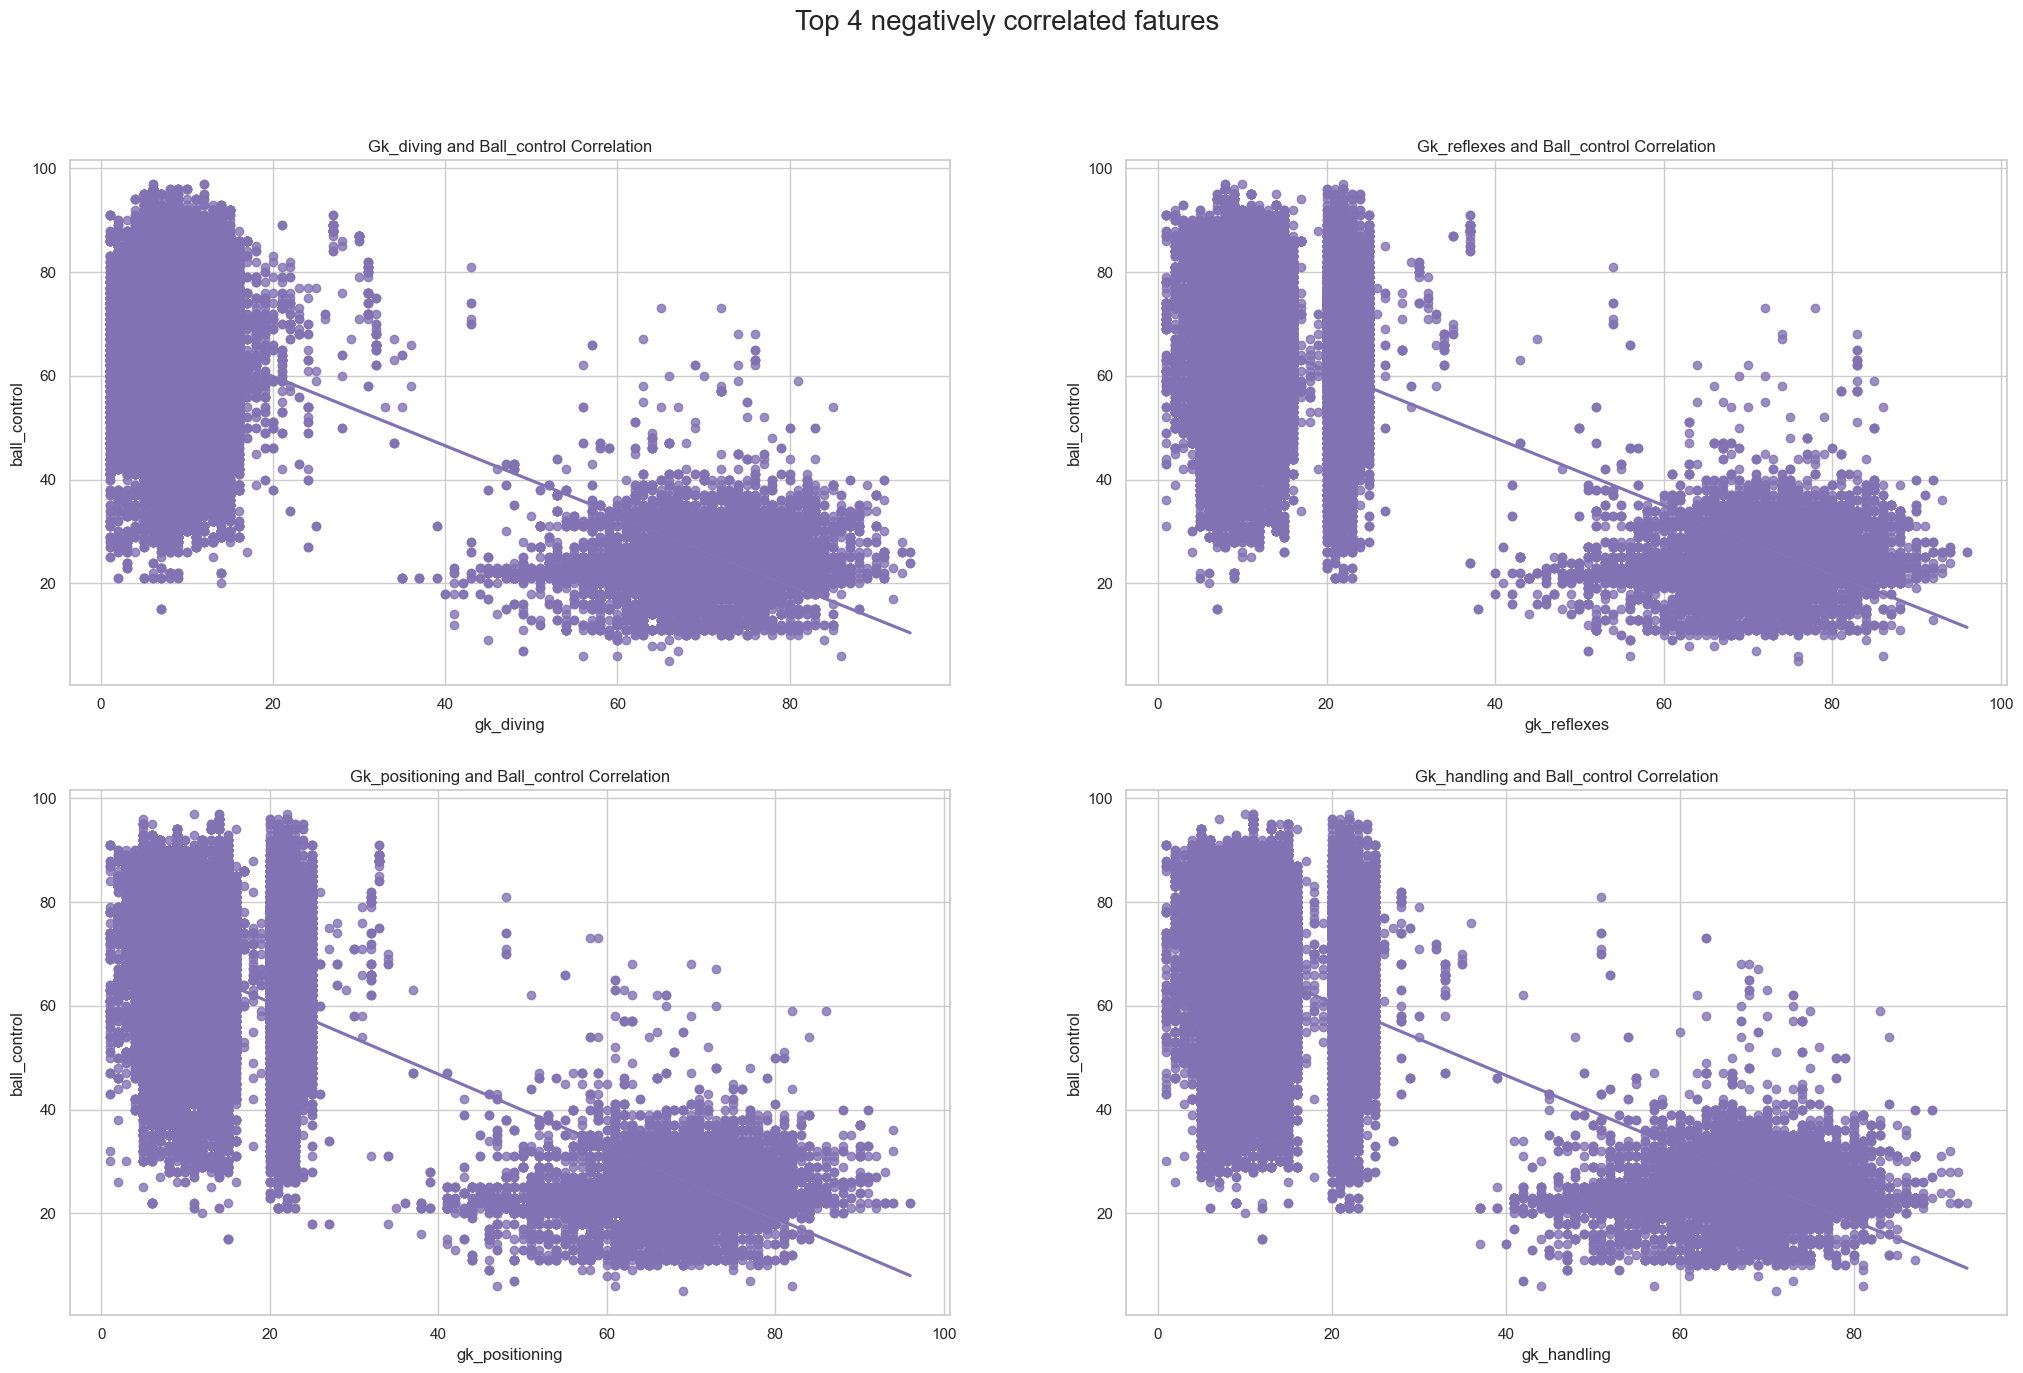

In [519]:
""" Plotting top 4 most negatively correlated features for player attributes """

neg_player_attrs = unique_corr_pairs.sort_values(ascending=True)
fig, axes = plt.subplots(2, 2, figsize=(25, 15))
i = 0
j = 0

for val in neg_player_attrs.head(4).keys():
  if i < 2:
    if j < 2:
      sns.regplot(x=val[0], y=val[1], data=df_players_attr,marker= 'o', color="m", ax=axes[i][j])
      axes[i][j].set_xlabel(val[0])
      axes[i][j].set_ylabel(val[1])
      axes[i][j].set_title(val[0].capitalize() + " and " + val[1].capitalize() + " Correlation")
      j+=1
      if j == 2:
        i+=1
        j=0

fig.suptitle("Top 4 negatively correlated fatures", fontsize=20) 

### Features Selection

#### Chosen Player Features

I need to selected important features for future modelling. First of all, I decided to add current winning rating for home and away teams.

In [520]:
""" Removing unnecessary columns for prediction """
player_cols_drop = ['player_name', 'birthday']
player_cols = [col for col in df_players_attr.columns if col not in player_cols_drop]
players_attr_for_pred = df_players_attr[player_cols]

In [521]:
""" Getting home and away teams winning rates of each match"""
team_winning_rating = []
away_winning_rates = []
home_winning_rates = []
away_avg_goals = []
home_avg_goals = []

for i in range(0, len(df_matches)):
    date = df_matches.iloc[i]['date']
    home_team = df_matches.iloc[i]['home_team_name']
    away_team = df_matches.iloc[i]['away_team_name']

    home_team_matches = df_matches[((df_matches['home_team_name'] == home_team) | (df_matches['away_team_name'] == home_team)) &
                                    (df_matches['date'] < date) & (df_matches['date'] > pd.to_datetime(str(date.year - 5)))] 
    home_team_matches_won = home_team_matches[home_team_matches['winner_team_name'] == home_team]

    home_goals = home_team_matches[home_team_matches['home_team_name'] == home_team]['home_team_goal']
    away_goals = home_team_matches[home_team_matches['away_team_name'] == home_team]['away_team_goal']
    

    if len(home_team_matches) == 0:
        home_team_winning_rate = 0
        home_team__avg_goals_scored = 0
    else:
        home_team_winning_rate = len(home_team_matches_won) / len(home_team_matches)
        home_team__avg_goals_scored = (sum(home_goals) + sum(away_goals)) / (len(home_goals) + len(away_goals))

    home_winning_rates.append(home_team_winning_rate)
    home_avg_goals.append(home_team__avg_goals_scored)

    away_team_matches = df_matches[((df_matches['home_team_name'] == away_team) | (df_matches['away_team_name'] == away_team)) &
                                    (df_matches['date'] < date) & (df_matches['date'] > pd.to_datetime(str(date.year - 5)))] 
    away_team_matches_won = away_team_matches[away_team_matches['winner_team_name'] == away_team]

    home_goals = away_team_matches[away_team_matches['home_team_name'] == away_team]['home_team_goal']
    away_goals = away_team_matches[away_team_matches['away_team_name'] == away_team]['away_team_goal']

    if len(away_team_matches) == 0:
        away_team_winning_rate = 0
        away_team__avg_goals_scored = 0
    else:
        away_team_winning_rate = len(away_team_matches_won) / len(away_team_matches)
        away_team__avg_goals_scored = (sum(home_goals) + sum(away_goals)) / (len(home_goals) + len(away_goals))

    away_avg_goals.append(away_team__avg_goals_scored)
    away_winning_rates.append(away_team_winning_rate)

In [522]:
""" Adding new columns to dataset - current home and away teams winning rate on that date """
df_matches["home_team_winning_rate"] = home_winning_rates
df_matches["away_team_winning_rate"] = away_winning_rates

df_matches["home_team_avg_goals"] = home_avg_goals
df_matches["away_team_avg_goals"] = away_avg_goals

In [523]:
""" Selecting columns to drop for prediction"""
drop_cols = ['country_id', 'country_name', 'season']
left_cols = [col for col in df_matches.columns if "_api_id" not in col
             and "team_name" not in col and col not in drop_cols]

In [524]:
""" Creating new variable for predictions """
matches_attr_for_pred = df_matches[left_cols] 

The following cells are corresponding to merging team attributes, player attributes with matches dataset.

As we have a lot of features in both team and player teams, I had to take the features that are corresponding to that particular date so I took features that are the most near to the match date.

In [525]:
""" Function that takes team attributes on that particular match date """
team_cols_str = ""
team_cols = [col for col in df_team_attributes.columns if col not in ['team_long_name', 'team_short_name', 'num_matches', 'country', 'buildUpPlayDribbling', 'current_winning_rate']]

for col in team_cols:
        team_cols_str += (f"t.{col}, ")
team_cols_str = team_cols_str[:-2]

def get_team_attributes(team_type):
        sql = f'''SELECT DISTINCT(m.id), m.date as match_date, {team_cols_str}
                        FROM ((
                                team_attributes t 
                                INNER JOIN match m
                                ON t.team_api_id = m.home_team_api_id
                        ))
                        WHERE t.date <= m.date 
                '''

        df = pd.read_sql(sql=sql, con=db)
        df['date'] = pd.to_datetime(df['date']) 
        return df

In [526]:
""" Function that takes player attributes on that particular match date """

player_cols_str = ""
for col in player_attr_cleaned.columns[2:]:
    player_cols_str += (f"p.{col}, ")
player_cols_str = player_cols_str[:-2]

def get_player_attributes(player_type, player_num):
    sql = f'''SELECT DISTINCT(m.id), m.date as match_date, {player_cols_str}, pl.height, pl.weight, pl.birthday 
                FROM ((
                        player_attributes p
                        INNER JOIN player pl ON pl.player_api_id = p.player_api_id
                        INNER JOIN match m
                        ON p.player_api_id = m.{player_type}_player_{player_num}
                ))
                WHERE p.date <= m.date 
        '''
        
    df = pd.read_sql(sql=sql, con=db)
    df['date'] = pd.to_datetime(df['date']) 
    df['birthday'] = pd.to_datetime(df['birthday']) 
 
    df['current_age'] = df['date'] - df['birthday']
    df['current_age'] = df['current_age'] / np.timedelta64(1, 'Y')
    df['current_age'] = df['current_age'].apply(np.floor)
    df['current_age'] = df['current_age'].astype('int')

    df['attacking_work_rate'] = df['defensive_work_rate'].astype('category')
    df['attacking_work_rate'] = df['attacking_work_rate'].cat.codes
    df['defensive_work_rate'] = df['defensive_work_rate'].astype('category')
    df['defensive_work_rate'] = df['defensive_work_rate'].cat.codes
    df['preferred_foot'] = df['preferred_foot'].astype('category')
    df['preferred_foot'] = df['preferred_foot'].cat.codes
        
    return df

In [527]:
matches_with_players_attr = matches_attr_for_pred.copy()  

In [528]:
""" Getting info about each home and away player and merging it into matches prediction dataset """

for player_type in ["home", "away"]:
    for i in range(1, 12):
        df = get_player_attributes(player_type, i)
        idx = df.groupby(by='id')['date'].idxmax()
        df=df.loc[idx,]
 
        df_cols = df.columns
        all_cols = [col for col in df_cols if col != 'date' and col != 'player_api_id' and col != 'match_date']
        df = df[all_cols]

        missing_cols = [col for col in df.columns if df[col].isnull().sum() > 0 or col == "id"]

        if len(missing_cols) > 0:  
            imp = IterativeImputer(max_iter=3, random_state=0)
            missing_vals_imputed = imp.fit_transform(df[missing_cols].values) 
            missing_vals_df = pd.DataFrame(missing_vals_imputed, columns=missing_cols) 
            non_missing_cols = [col for col in all_cols if col not in missing_cols or col == 'id']    
            df = pd.merge(df[non_missing_cols], missing_vals_df, how="left", on='id')
 
        table1 = df.add_suffix(f'_{player_type}_player_{i}') 
        table1 = table1.rename(index=str, columns={f'id_{player_type}_player_{i}':'id'})

        matches_with_players_attr = pd.merge(matches_with_players_attr, table1, how="left", on='id')

In [529]:
merge_matches_with_teams = matches_with_players_attr

In [530]:
""" Getting info about each home and away team and merging it into matches prediction dataset """

for team_type in ["home", "away"]: 
    df = get_team_attributes(team_type)
    idx = df.groupby(by='id')['date'].idxmax()
    df=df.loc[idx,]

    df_cols = df.columns
    all_cols = [col for col in df_cols if col != 'date' and col != 'team_api_id' and col != 'match_date']
    df = df[all_cols]

    table1 = df.add_suffix(f'_{team_type}_team') 
    table1 = table1.rename(index=str, columns={f'id_{team_type}_team':'id'})

    missing_cols = [col for col in df.columns if df[col].isnull().sum() > 0 or col == "id"]
     
    merge_matches_with_teams = pd.merge(merge_matches_with_teams, table1, how="left", on='id')

In [531]:
""" Dropping non existing matches information """
merge_matches_with_teams = merge_matches_with_teams.dropna()
merge_matches_with_teams.isnull().sum()

game_outcome                          0
id                                    0
league_id                             0
stage                                 0
date                                  0
                                     ..
defenceAggression_away_team           0
defenceAggressionClass_away_team      0
defenceTeamWidth_away_team            0
defenceTeamWidthClass_away_team       0
defenceDefenderLineClass_away_team    0
Length: 1071, dtype: int64

In [532]:
""" Updating matches variable for prediction """
matches_attr_for_pred = merge_matches_with_teams.copy() 

#### Data Scaling

In [533]:
""" Removing useless columns for prediction"""

cols = [col for col in matches_attr_for_pred.columns if "birthday" not in col and col not in ["game_outcome", "id", "date", "home_team_goal", "away_team_goal"]]
df_features = matches_attr_for_pred[cols] 

In [589]:
""" Converting non numeric features into numeric ones """

df_columns = df_features.columns
num_cols = df_features._get_numeric_data().columns
categorical_cols = list(set(df_columns) - set(num_cols))

for col in categorical_cols:  
    df_features.loc[:, col] = df_features[col].astype('category')
    df_features.loc[:, col] = df_features[col].cat.codes

First, before training I had to scale the values. 

In [535]:
""" Scaling the data with StandardScaler and taking the target values """

scaler = StandardScaler()  
df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=cols) 
df_scaled['date'] = matches_attr_for_pred['date'] 

df_scaled['game_outcome'] = matches_attr_for_pred['game_outcome'] 
df_scaled['game_outcome'] = df_scaled['game_outcome'].astype('category')
df_scaled['game_outcome'] = df_scaled['game_outcome'].cat.codes

df_scaled['home_team_goal'] = matches_attr_for_pred['home_team_goal'] 
df_scaled['home_team_goal'] = df_scaled['home_team_goal'].astype('category')
df_scaled['home_team_goal'] = df_scaled['home_team_goal'].cat.codes

df_scaled['away_team_goal'] = matches_attr_for_pred['away_team_goal'] 
df_scaled['away_team_goal'] = df_scaled['away_team_goal'].astype('category')
df_scaled['away_team_goal'] = df_scaled['away_team_goal'].cat.codes

In [536]:
""" Printing out scaled dataset """
df_scaled = df_scaled.sort_values(by='date', ascending=True)
df_scaled.head()

league_id     stage  home_player_X1  home_player_X2  home_player_X3  \
1762   -1.253622  1.410834             0.0       -0.208835       -0.169926   
9810   -0.141010 -0.956330             0.0       -0.208835       -0.169926   
9817    0.252605  0.558655             0.0       -0.208835       -0.169926   
7427   -0.460391  0.179909             0.0       -0.208835       -0.169926   
12341   0.822479  0.179909             0.0       -0.208835       -0.169926   

       home_player_X4  home_player_X5  home_player_X6  home_player_X7  \
1762        -0.110581        0.296023        0.571831        1.019701   
9810        -0.110581        0.296023       -0.253728        0.123453   
9817        -0.110581        0.296023       -1.079287       -0.772795   
7427        -0.110581        0.296023        0.571831        1.019701   
12341       -0.110581        0.296023       -0.253728        0.123453   

       home_player_X8  ...  defencePressureClass_away_team  \
1762        -1.250079  ...                        0.371817   
9810         1.019294  ...                        0.371817   
9817         0.451951  ...                       -2.974439   
7427        -1.250079  ...                        0.371817   
12341        1.019294  ...                        0.371817   

       defenceAggression_away_team  defenceAggressionClass_away_team  \
1762                      0.782594                          0.331159   
9810                      1.612779                          0.331159   
9817                     -2.019282                         -3.815546   
7427                     -0.358911                          0.331159   
12341                    -0.047592                          0.331159   

       defenceTeamWidth_away_team  defenceTeamWidthClass_away_team  \
1762                    -0.027372                        -0.131532   
9810                    -1.852641                        -0.131532   
9817                    -2.389485                        -3.224394   
7427                     0.294734                        -0.131532   
12341                    0.187365                        -0.131532   

       defenceDefenderLineClass_away_team       date  game_outcome  \
1762                            -0.268012 2010-02-23             2   
9810                            -0.268012 2010-02-24             0   
9817                            -0.268012 2010-02-24             2   
7427                            -0.268012 2010-02-26             2   
12341                           -0.268012 2010-02-26             0   

       home_team_goal  away_team_goal  
1762                3               0  
9810                1               2  
9817                2               1  
7427                2               1  
12341               1               2  

[5 rows x 1048 columns]

In [537]:
""" Appending target values for correlation checking """
cols.append("game_outcome")
cols.append("away_team_goal")
cols.append("home_team_goal")

In [538]:
""" Taking correlations of new scaled dataset """
corr_df = df_scaled[cols].corr() 

In [539]:
len(cols)

1047

I choose the mostly correlated features with the target values - 'game_outcome', 'away_team_goal', 'home_team_goal'

In [540]:
""" Taking features which are mostly correlated with our target variables """
corr = (corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))

targets = ['game_outcome', 'away_team_goal', 'home_team_goal']

corr = [[index[0], index[1]] for index, value in corr.items() if (value >= 0.75 or value <= -0.75)]
corr = list(itertools.chain(*corr))
corr = list(dict.fromkeys(corr))
feature_cols = corr
len(feature_cols)

503

### Prediction

* Predict Game Outcome - home, draw or away
* Predict home goal score
* Predict away goal score

##### Predicting Game Outcome

In [541]:
""" Removing target variables to prevent data leakage """
for target in targets:
    if target in feature_cols:
        feature_cols.remove(target)

First, I splitted the dataset into training and testing data by the date of the match.

In [542]:
""" Splitting dataset into train and test based on date in order not to train on future games""" 

train, test = np.split(df_scaled, [round(len(df_scaled) * 0.7)]) 

X_train = train[feature_cols]
Y_train = train['game_outcome'] 

X_test = test[feature_cols]
Y_test = test['game_outcome'] 

**Preparing Dummy Regressor**

I decided to create a dummy regressor model in order to see whether my models will have meaningful results.

In [543]:
""" Preparing dummy regressor model in order to compare it with our real models """

DummyR = DummyRegressor(strategy='mean')
DummyR.fit(X_train, Y_train)

""" Train Predictions"""
train_game_outcome_pred = DummyR.predict(X_train) 
predictions = [round(pred) for pred in train_game_outcome_pred]

mae = mean_absolute_error(y_true=Y_train,y_pred=predictions)
mse = mean_squared_error(y_true=Y_train,y_pred=predictions)  
rmse = mean_squared_error(y_true=Y_train,y_pred=predictions,squared=False)
dummy_results_train = [mae, mse, rmse]

""" Test Predictions"""
test_game_outcome_pred = DummyR.predict(X_test) 
predictions = [round(pred) for pred in test_game_outcome_pred]
mae = mean_absolute_error(y_true=Y_test,y_pred=predictions)
mse = mean_squared_error(y_true=Y_test,y_pred=predictions)  
rmse = mean_squared_error(y_true=Y_test,y_pred=predictions,squared=False)
dummy_results_test = [mae, mse, rmse]

**Linear Regression - Game Outcome**

In [544]:
""" Fitting our Linear Regression model """
LinR = LinearRegression().fit(X_train, Y_train)

In [545]:
""" Creating dictionary to save model results for future comparison """
MAEs = {}
MSEs = {}
RMSEs = {}

In [546]:
""" Predicting on train data """

train_game_outcome_pred = LinR.predict(X_train) 
predictions = [round(pred) for pred in train_game_outcome_pred]

mae = mean_absolute_error(y_true=Y_train,y_pred=predictions)
mse = mean_squared_error(y_true=Y_train,y_pred=predictions)  
rmse = mean_squared_error(y_true=Y_train,y_pred=predictions,squared=False)
r2  = r2_score(y_true=Y_train,y_pred=predictions)
  
print("Linear Regression Train Results:")
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)
print("R2:",r2)

Linear Regression Train Results:
MAE: 0.7332626600342493
MSE: 0.742722009296257
RMSE: 0.8618132102121996
R2: -0.041806830939570494


In [547]:
""" Saving model results in our dictionary """

MAEs['train'] = [mae]
MSEs['train'] = [mse]
RMSEs['train'] = [rmse]

In [548]:
""" Predicting on test data """

test_gameoutcome_pred = LinR.predict(X_test) 
predictions = [round(pred) for pred in test_gameoutcome_pred]

mae = mean_absolute_error(y_true=Y_test,y_pred=predictions)
mse = mean_squared_error(y_true=Y_test,y_pred=predictions)  
rmse = mean_squared_error(y_true=Y_test,y_pred=predictions,squared=False) 
print("Linear Regression Test Results:")
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse) 

Linear Regression Test Results:
MAE: 1.5594671741198858
MSE: 2.927687916270219
RMSE: 1.7110487767069118


In [549]:
""" Saving model results in our dictionary """

MAEs['test'] = [mae]
MSEs['test'] = [mse]
RMSEs['test'] = [rmse]

**Logistic Regression - Game Outcome**

In [550]:
""" Fitting Logistic Regression model """
LogR = LogisticRegression(solver='lbfgs', max_iter=1000).fit(X_train, Y_train.values.ravel())

In [551]:
""" Predicting on train data """

train_game_outcome_pred = LogR.predict(X_train) 
predictions = [round(pred) for pred in train_game_outcome_pred]

mae = mean_absolute_error(y_true=Y_train,y_pred=predictions)
mse = mean_squared_error(y_true=Y_train,y_pred=predictions)  
rmse = mean_squared_error(y_true=Y_train,y_pred=predictions,squared=False)
r2  = r2_score(y_true=Y_train,y_pred=predictions)
  
print("Logistic Regression Train Results:")
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)
print("R2:",r2)

Logistic Regression Train Results:
MAE: 0.7724863410258501
MSE: 1.2751365897414988
RMSE: 1.1292194603979773
R2: -0.7886180737156416


In [552]:
""" Saving model results in our dictionary """

MAEs['train'].append(mae)
MSEs['train'].append(mse)
RMSEs['train'].append(rmse)

In [553]:
""" Predicting on test data """
 
test_game_outcome_pred = LogR.predict(X_test)  
predictions = [round(pred) for pred in test_game_outcome_pred]

mae = mean_absolute_error(y_true=Y_test,y_pred=predictions)
mse = mean_squared_error(y_true=Y_test,y_pred=predictions)  
rmse = mean_squared_error(y_true=Y_test,y_pred=predictions,squared=False) 
  
print("Logistic Regression Test Results:")
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse) 

Logistic Regression Test Results:
MAE: 2.0
MSE: 5.303520456707897
RMSE: 2.302937354056314


In [554]:
""" Saving model results in our dictionary """ 

MAEs['test'].append(mae)
MSEs['test'].append(mse)
RMSEs['test'].append(rmse)

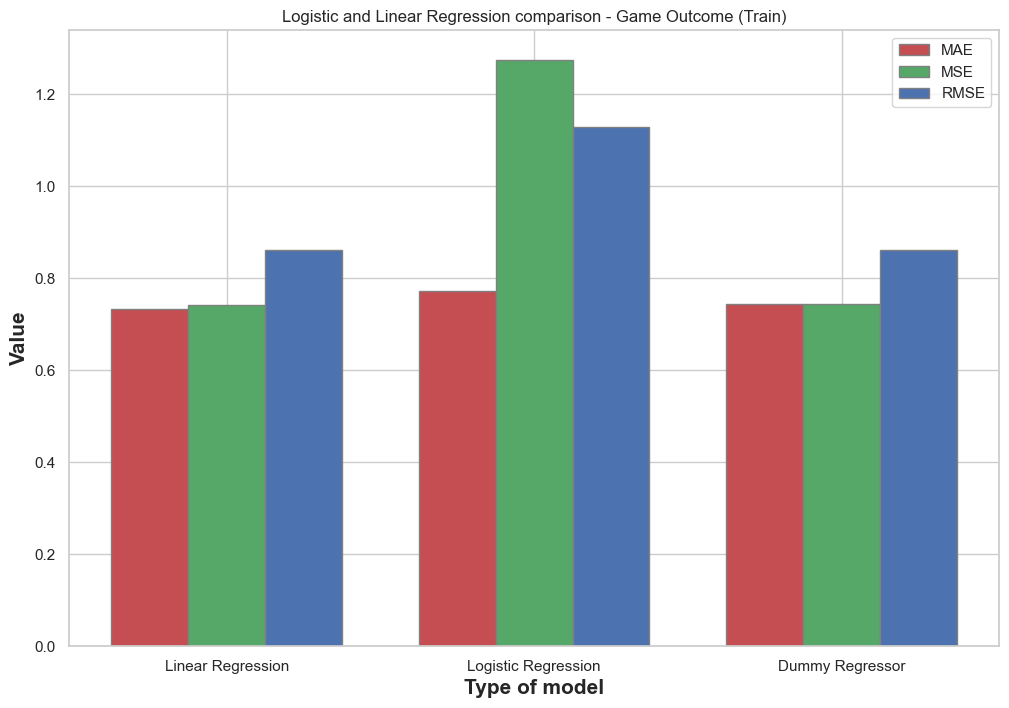

In [555]:
""" Plotting different models results for comparison - Train Data """
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
     
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

mae_results = MAEs['train']
mae_results.append(dummy_results_train[0])

mse_results = MSEs['train']
mse_results.append(dummy_results_train[1])

rmse_results = RMSEs['train']
rmse_results.append(dummy_results_train[2])
  
plt.bar(br1, mae_results, color ='r', width = barWidth,
        edgecolor ='grey', label ='MAE')
plt.bar(br2, mse_results, color ='g', width = barWidth,
        edgecolor ='grey', label ='MSE')
plt.bar(br3, rmse_results, color ='b', width = barWidth,
        edgecolor ='grey', label ='RMSE')
  
plt.xlabel('Type of model', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['Linear Regression', 'Logistic Regression', 'Dummy Regressor'])
plt.title("Logistic and Linear Regression comparison - Game Outcome (Train)")
 
plt.legend()
plt.show()

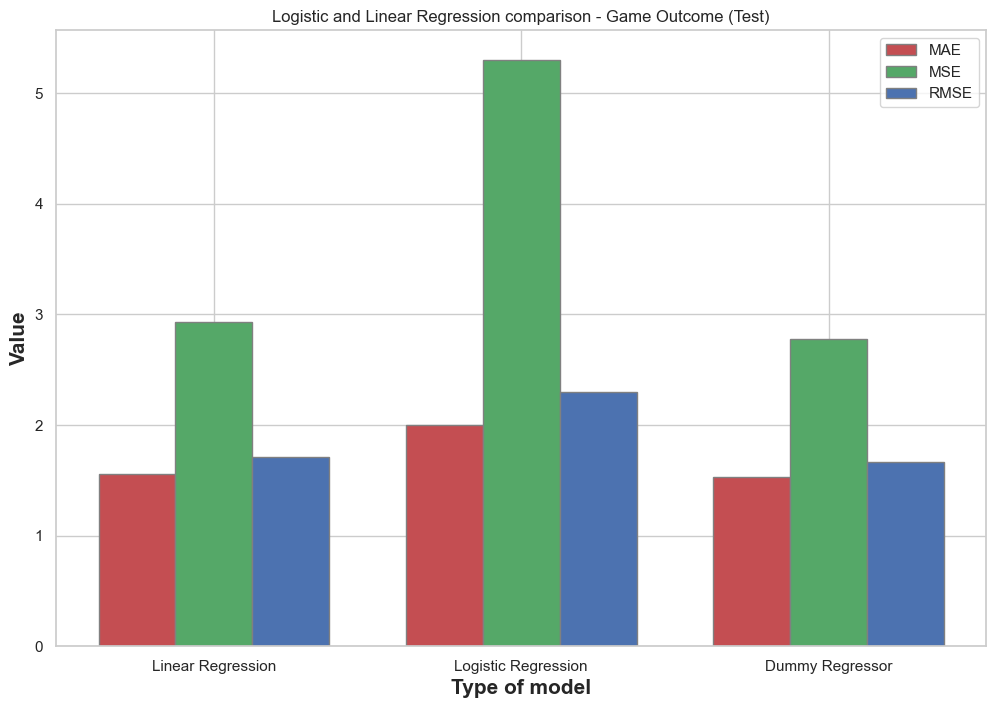

In [556]:
""" Plotting different models results for comparison - Test Data """

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
     
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

mae_results = MAEs['test']
mae_results.append(dummy_results_test[0])

mse_results = MSEs['test']
mse_results.append(dummy_results_test[1])

rmse_results = RMSEs['test']
rmse_results.append(dummy_results_test[2])
  
plt.bar(br1, mae_results, color ='r', width = barWidth,
        edgecolor ='grey', label ='MAE')
plt.bar(br2, mse_results, color ='g', width = barWidth,
        edgecolor ='grey', label ='MSE')
plt.bar(br3, rmse_results, color ='b', width = barWidth,
        edgecolor ='grey', label ='RMSE')
  
plt.xlabel('Type of model', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['Linear Regression', 'Logistic Regression', 'Dummy Regressor'])
plt.title("Logistic and Linear Regression comparison - Game Outcome (Test)")
 
plt.legend()
plt.show()

#### Predict Home Team results

In [557]:
""" Splitting dataset into train and test based on date in order not to train on future games """ 

train, test = np.split(df_scaled, [round(len(df_scaled) * 0.7)]) 

X_train = train[feature_cols]
Y_train = train['home_team_goal'] 

X_test = test[feature_cols]
Y_test = test['home_team_goal']

**Preparing Dummy Regressor**

In [558]:
""" Preparing dummy regressor model in order to compare it with our real models """

DummyR = DummyRegressor(strategy='constant', constant=max(Y_train))
DummyR.fit(X_train, Y_train)

""" Train Predictions"""
train_game_outcome_pred = DummyR.predict(X_train) 
predictions = [round(pred) for pred in train_game_outcome_pred]

mae = mean_absolute_error(y_true=Y_train,y_pred=predictions)
mse = mean_squared_error(y_true=Y_train,y_pred=predictions)  
rmse = mean_squared_error(y_true=Y_train,y_pred=predictions,squared=False)
dummy_results_train = [mae, mse, rmse]

""" Test Predictions"""
test_game_outcome_pred = DummyR.predict(X_test) 
predictions = [round(pred) for pred in test_game_outcome_pred]
mae = mean_absolute_error(y_true=Y_test,y_pred=predictions)
mse = mean_squared_error(y_true=Y_test,y_pred=predictions)  
rmse = mean_squared_error(y_true=Y_test,y_pred=predictions,squared=False)
dummy_results_test = [mae, mse, rmse]

**Linear Regression - Home Team Goal**

In [559]:
""" Fitting our Linear Regression model """

LinR = LinearRegression().fit(X_train, Y_train)

In [560]:
""" Creating dictionary to save model results for future comparison """
MAEs = {}
MSEs = {}
RMSEs = {}

In [561]:
""" Predicting on train data """ 

train_home_goal = LinR.predict(X_train)  
predictions = [round(pred) for pred in train_home_goal]

mae = mean_absolute_error(y_true=Y_train, y_pred=predictions)
mse = mean_squared_error(y_true=Y_train, y_pred=predictions)
rmse = mean_squared_error(y_true=Y_train, y_pred=predictions,squared=False)
r2  = r2_score(y_true=Y_train,y_pred=predictions)
  
print("Linear Regression Train Results for home goal:")
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)
print("R2:",r2)

Linear Regression Train Results for home goal:
MAE: 0.9938024953110984
MSE: 1.7329364755769388
RMSE: 1.3164104510284544
R2: -0.02532806613153049


In [562]:
""" Saving model results in our dictionary """

MAEs['train'] = [mae]
MSEs['train'] = [mse]
RMSEs['train'] = [rmse]

In [563]:
""" Predicting on test data """ 

test_home_goal = LinR.predict(X_test)  
predictions = [round(pred) for pred in test_home_goal]

mae = mean_absolute_error(y_true=Y_test, y_pred=predictions)
mse = mean_squared_error(y_true=Y_test, y_pred=predictions)
rmse = mean_squared_error(y_true=Y_test, y_pred=predictions,squared=False) 
  
print("Linear Regression Test Results for home goal:")
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse) 

Linear Regression Test Results for home goal:
MAE: 2.0142721217887725
MSE: 5.053663177925785
RMSE: 2.2480354040641317


In [564]:
""" Saving model results in our dictionary """

MAEs['test'] = [mae]
MSEs['test'] = [mse]
RMSEs['test'] = [rmse]

In [565]:
""" Fitting our Logistic Regression model """
LogR = LogisticRegression(solver='lbfgs', max_iter=5000).fit(X_train, Y_train.values.ravel())

In [566]:
""" Predicting on train data """ 

train_home_goal = LogR.predict(X_train)  
predictions = [round(pred) for pred in train_home_goal]

mae = mean_absolute_error(y_true=Y_train, y_pred=predictions)
mse = mean_squared_error(y_true=Y_train, y_pred=predictions)
rmse = mean_squared_error(y_true=Y_train, y_pred=predictions,squared=False)
r2  = r2_score(y_true=Y_train,y_pred=predictions)
  
print("Logistic Regression Train Results for home goal:")
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)
print("R2:",r2)

Logistic Regression Train Results for home goal:
MAE: 0.9989399005137405
MSE: 2.065236891462122
RMSE: 1.437093209037647
R2: -0.2219405488140389


In [567]:
""" Saving model results in our dictionary """ 

MAEs['train'].append(mae)
MSEs['train'].append(mse)
RMSEs['train'].append(rmse)

In [568]:
""" Predicting on test data """ 

test_home_goal = LogR.predict(X_test)  
predictions = [round(pred) for pred in test_home_goal]

mae = mean_absolute_error(y_true=Y_test, y_pred=predictions)
mse = mean_squared_error(y_true=Y_test, y_pred=predictions)
rmse = mean_squared_error(y_true=Y_test, y_pred=predictions,squared=False) 
  
print("Logistic Regression Test Results for home goal:")
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse) 

Logistic Regression Test Results for home goal:
MAE: 1.851569933396765
MSE: 4.722740247383444
RMSE: 2.173186657280834


In [569]:
""" Saving model results in our dictionary """

MAEs['test'].append(mae)
MSEs['test'].append(mse)
RMSEs['test'].append(rmse)

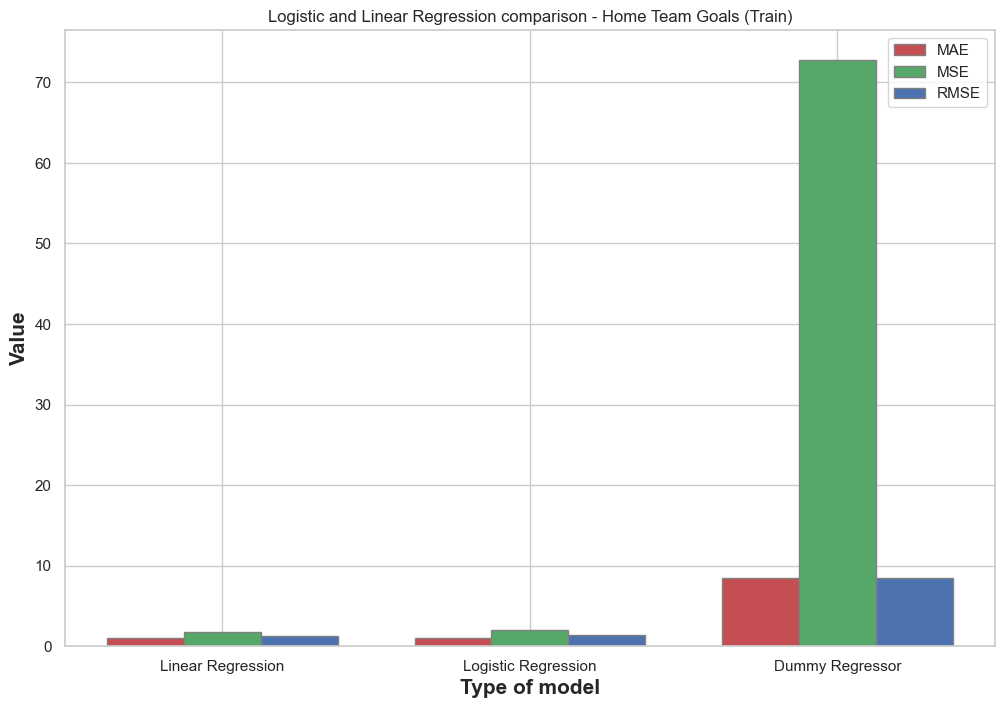

In [570]:
""" Plotting different models results for comparison - Train Data """

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
     
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

mae_results = MAEs['train']
mae_results.append(dummy_results_train[0])

mse_results = MSEs['train']
mse_results.append(dummy_results_train[1])

rmse_results = RMSEs['train']
rmse_results.append(dummy_results_train[2])
  
plt.bar(br1, mae_results, color ='r', width = barWidth,
        edgecolor ='grey', label ='MAE')
plt.bar(br2, mse_results, color ='g', width = barWidth,
        edgecolor ='grey', label ='MSE')
plt.bar(br3, rmse_results, color ='b', width = barWidth,
        edgecolor ='grey', label ='RMSE')
  
plt.xlabel('Type of model', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['Linear Regression', 'Logistic Regression', 'Dummy Regressor'])
plt.title("Logistic and Linear Regression comparison - Home Team Goals (Train)")
 
plt.legend()
plt.show()

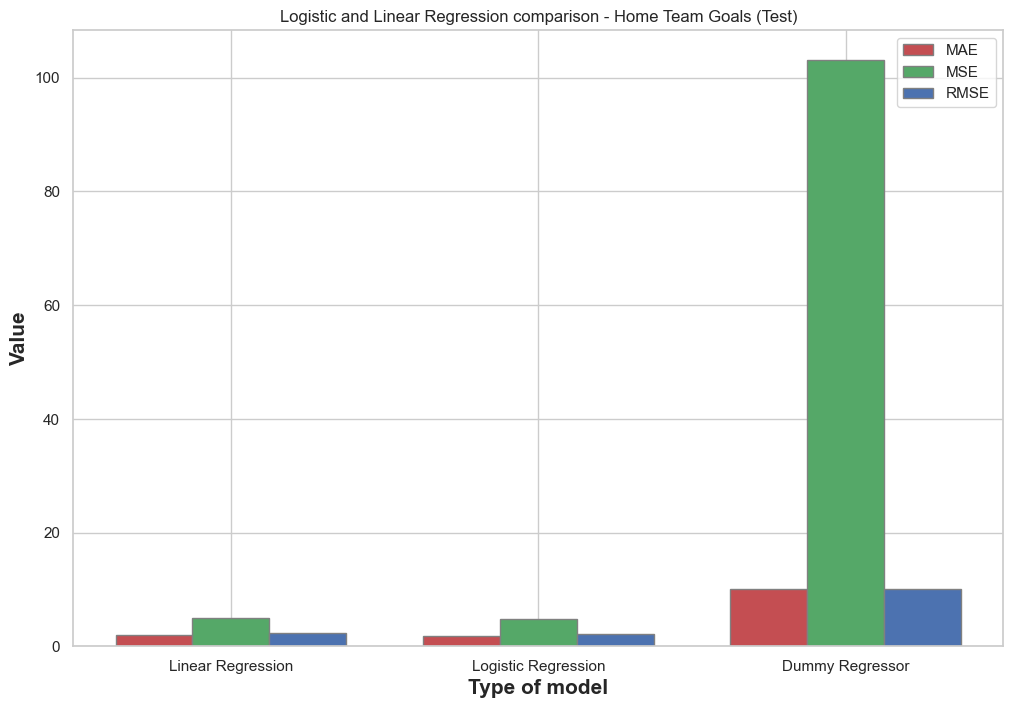

In [571]:
""" Plotting different models results for comparison - Test Data """

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
     
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

mae_results = MAEs['test']
mae_results.append(dummy_results_test[0])

mse_results = MSEs['test']
mse_results.append(dummy_results_test[1])

rmse_results = RMSEs['test']
rmse_results.append(dummy_results_test[2])
  
plt.bar(br1, mae_results, color ='r', width = barWidth,
        edgecolor ='grey', label ='MAE')
plt.bar(br2, mse_results, color ='g', width = barWidth,
        edgecolor ='grey', label ='MSE')
plt.bar(br3, rmse_results, color ='b', width = barWidth,
        edgecolor ='grey', label ='RMSE')
  
plt.xlabel('Type of model', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['Linear Regression', 'Logistic Regression', 'Dummy Regressor'])
plt.title("Logistic and Linear Regression comparison - Home Team Goals (Test)")
 
plt.legend()
plt.show()

#### Predict Away Team results

In [572]:
""" Splitting dataset into train and test based on date in order not to train on future games """ 

train, test = np.split(df_scaled, [round(len(df_scaled) * 0.7)]) 

X_train = train[feature_cols]
Y_train = train['away_team_goal'] 

X_test = test[feature_cols]
Y_test = test['away_team_goal']

**Preparing Dummy Regressor**

In [573]:
""" Preparing dummy regressor model in order to compare it with our real models """

DummyR = DummyRegressor(strategy='constant', constant=max(Y_train))
DummyR.fit(X_train, Y_train)

""" Train Predictions"""
train_game_outcome_pred = DummyR.predict(X_train) 
predictions = [round(pred) for pred in train_game_outcome_pred]

mae = mean_absolute_error(y_true=Y_train,y_pred=predictions)
mse = mean_squared_error(y_true=Y_train,y_pred=predictions)  
rmse = mean_squared_error(y_true=Y_train,y_pred=predictions,squared=False)
dummy_results_train = [mae, mse, rmse]

""" Test Predictions"""
test_game_outcome_pred = DummyR.predict(X_test) 
predictions = [round(pred) for pred in test_game_outcome_pred]
mae = mean_absolute_error(y_true=Y_test,y_pred=predictions)
mse = mean_squared_error(y_true=Y_test,y_pred=predictions)  
rmse = mean_squared_error(y_true=Y_test,y_pred=predictions,squared=False)
dummy_results_test = [mae, mse, rmse]

In [574]:
""" Fitting our Linear Regression model"""
LinR = LinearRegression().fit(X_train, Y_train)

In [575]:
""" Creating dictionary to save model results for future comparison """
MAEs = {}
MSEs = {}
RMSEs = {}

In [576]:
""" Predicting on train data """ 

train_away_goal = LinR.predict(X_train)  
predictions = [round(pred) for pred in train_away_goal]

mae = mean_absolute_error(y_true=Y_train, y_pred=predictions)
mse = mean_squared_error(y_true=Y_train, y_pred=predictions)
rmse = mean_squared_error(y_true=Y_train, y_pred=predictions, squared=False)
r2  = r2_score(y_true=Y_train,y_pred=predictions)
  
print("Linear Regression Train Results for away goal:")
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)
print("R2:",r2)

Linear Regression Train Results for away goal:
MAE: 0.8379678708309549
MSE: 1.323167251080486
RMSE: 1.1502900725819056
R2: -0.004744408620454665


In [577]:
""" Saving model results in our dictionary """ 

MAEs['train'] = [mae]
MSEs['train'] = [mse]
RMSEs['train'] = [rmse]

In [578]:
""" Predicting on test data """ 

test_away_goal = LinR.predict(X_test)  
predictions = [round(pred) for pred in test_away_goal]

mae = mean_absolute_error(y_true=Y_test, y_pred=predictions)
mse = mean_squared_error(y_true=Y_test, y_pred=predictions)
rmse = mean_squared_error(y_true=Y_test, y_pred=predictions, squared=False) 
  
print("Linear Regression Test Results for away goal:")
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse) 

Linear Regression Test Results for away goal:
MAE: 1.6247383444338725
MSE: 3.291722169362512
RMSE: 1.8143103839648034


In [579]:
""" Saving model results in our dictionary """ 

MAEs['test'] = [mae]
MSEs['test'] = [mse]
RMSEs['test'] = [rmse]

In [580]:
""" Fitting our Logistic Regression model """
LogR = LogisticRegression(solver='lbfgs', max_iter=5000).fit(X_train, Y_train.values.ravel())

In [581]:
""" Predicting on train data """ 

train_away_goal = LogR.predict(X_train)  
predictions = [round(pred) for pred in train_away_goal]

mae = mean_absolute_error(y_true=Y_train, y_pred=predictions)
mse = mean_squared_error(y_true=Y_train, y_pred=predictions)
rmse = mean_squared_error(y_true=Y_train, y_pred=predictions, squared=False)
r2  = r2_score(y_true=Y_train,y_pred=predictions)
  
print("Logistic Regression Train Results for away goal:")
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

Logistic Regression Train Results for away goal:
MAE: 0.8797194813667129
MSE: 1.7080649107070047
RMSE: 1.3069295737364752


In [582]:
""" Saving model results in our dictionary """ 

MAEs['train'].append(mae)
MSEs['train'].append(mse)
RMSEs['train'].append(rmse)

In [583]:
""" Predicting on test data """ 

test_away_goal = LogR.predict(X_test)  
predictions = [round(pred) for pred in test_away_goal]

mae = mean_absolute_error(y_true=Y_test, y_pred=predictions)
mse = mean_squared_error(y_true=Y_test, y_pred=predictions)
rmse = mean_squared_error(y_true=Y_test, y_pred=predictions, squared=False) 
  
print("Logistic Regression Test Results for away goal:")
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

Logistic Regression Test Results for away goal:
MAE: 1.4572787821122741
MSE: 3.0690770694576592
RMSE: 1.7518781548548572


In [584]:
""" Saving model results in our dictionary """
 
MAEs['test'].append(mae)
MSEs['test'].append(mse)
RMSEs['test'].append(rmse)

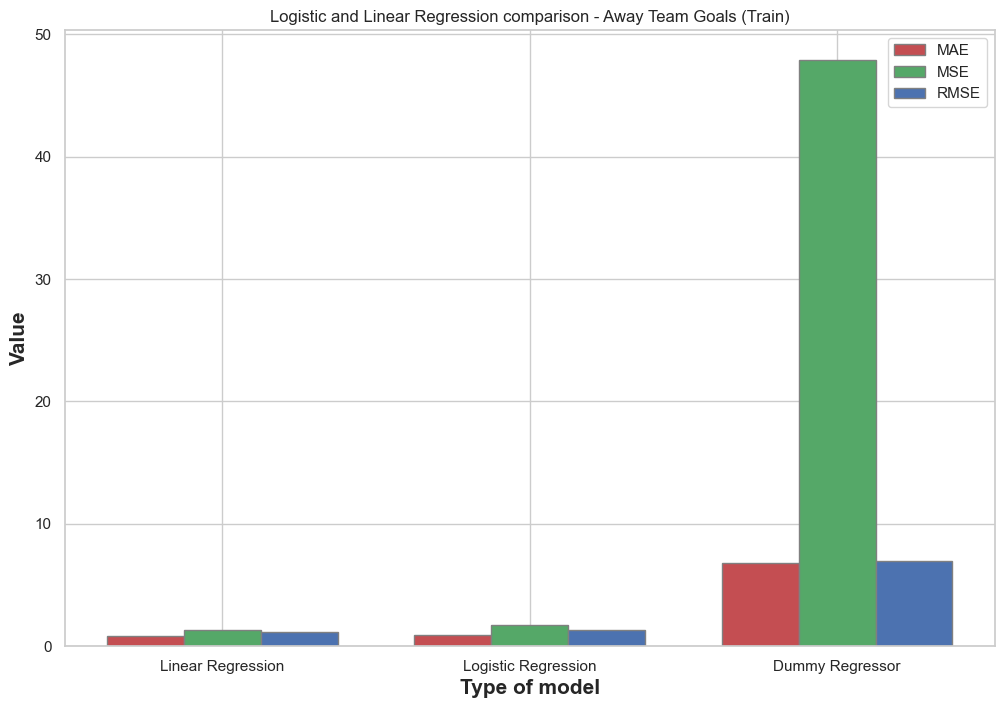

In [585]:
""" Plotting different models results for comparison - Train Data """

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
     
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

mae_results = MAEs['train']
mae_results.append(dummy_results_train[0])

mse_results = MSEs['train']
mse_results.append(dummy_results_train[1])

rmse_results = RMSEs['train']
rmse_results.append(dummy_results_train[2])
  
plt.bar(br1, mae_results, color ='r', width = barWidth,
        edgecolor ='grey', label ='MAE')
plt.bar(br2, mse_results, color ='g', width = barWidth,
        edgecolor ='grey', label ='MSE')
plt.bar(br3, rmse_results, color ='b', width = barWidth,
        edgecolor ='grey', label ='RMSE')
  
plt.xlabel('Type of model', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['Linear Regression', 'Logistic Regression', 'Dummy Regressor'])
plt.title("Logistic and Linear Regression comparison - Away Team Goals (Train)")
 
plt.legend()
plt.show()

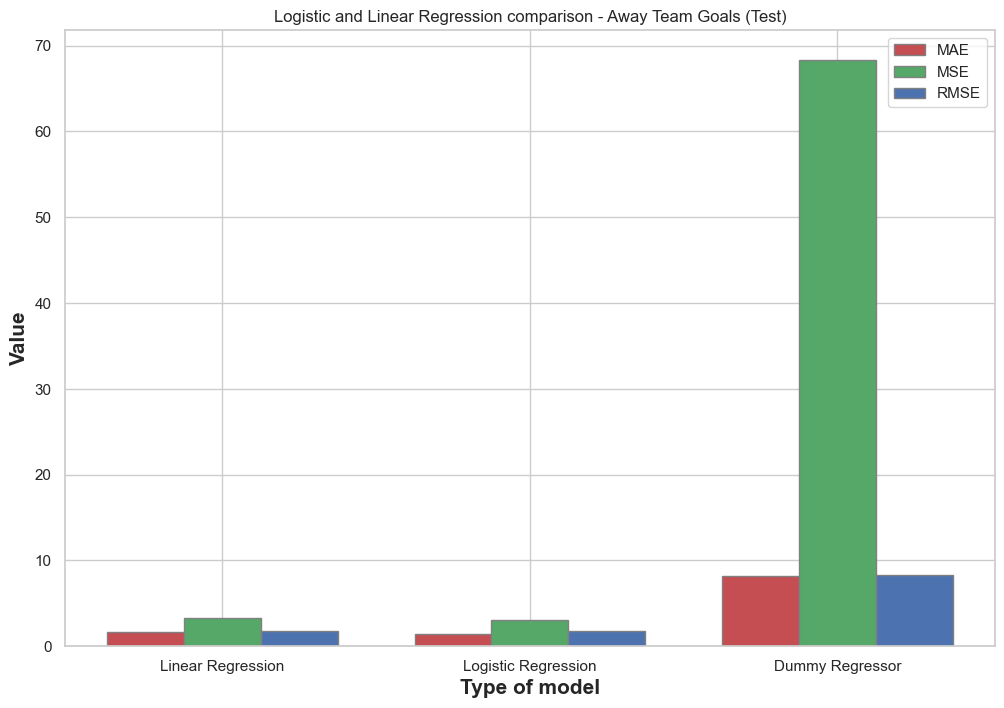

In [586]:
""" Plotting different models results for comparison - Train Data """

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
     
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

mae_results = MAEs['test']
mae_results.append(dummy_results_test[0])

mse_results = MSEs['test']
mse_results.append(dummy_results_test[1])

rmse_results = RMSEs['test']
rmse_results.append(dummy_results_test[2])
  
plt.bar(br1, mae_results, color ='r', width = barWidth,
        edgecolor ='grey', label ='MAE')
plt.bar(br2, mse_results, color ='g', width = barWidth,
        edgecolor ='grey', label ='MSE')
plt.bar(br3, rmse_results, color ='b', width = barWidth,
        edgecolor ='grey', label ='RMSE')
  
plt.xlabel('Type of model', fontweight ='bold', fontsize = 15)
plt.ylabel('Value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(3)],
        ['Linear Regression', 'Logistic Regression', 'Dummy Regressor'])
plt.title("Logistic and Linear Regression comparison - Away Team Goals (Test)")
 
plt.legend()
plt.show()

## Summary

### League Analysis:
##### Question: What are the number of matches of each league in the dataset? 
	- Poland - 462
	- Switzerland - 1178
	- Belgium - 1215
	- Portugal - 1279
	- Scotland - 1541
	- Netherlands - 2034
	- Germany - 2374
	- Spain - 2706
	- Italy - 2746
	- France - 2864
	- England - 2962

##### Question: Which countries have the largest/smallest home and away goal difference?
	Smallest home away goal difference have:
	- Scotland 
	- Portugal

Largest home away goal difference have:
	- Spain
	- Netherlands

##### Question: Which leagues have the highest and lowest average home goals?
	- Netherlands have highest average home goals
	- France have lowest average home goals

##### Question: Which leagues have the highest and lowest average away goals?
	- Netherlands have highest average away goals
	- France have lowest average away goals

##### Question: Is there such thing as home advantage?
	- All of the leagues have more goals scored home than away. Therefore, we can conclude that there exists such thing as home advantage.

### Team Analysis:
##### Question: How many distinct teams there are in each league?
	- Switzerland - 15
	- Scotland - 17
	- Poland -  19
	- Belgium - 22 
	- Netherlands - 24
	- Portugal - 27
	- Germany - 30
	- Italy - 32
	- Spain - 33
	- England - 34
	- France - 35

##### Question: What are the teams with largest number of matches won?
	Teams with largest number of matches won were:
	- Real Madrid
	- FC Barcelona
	- Celtic

##### Question: Which are the teams with highest winning rate?
	Teams with highest winning rate were:
	- FC Barcelona
	- SL Benfica
	- Real Madrid CF 

##### Question: Which are the teams that scored highest number of home goals?
	Teams that scored most of the home goals were:
	- Real Madrid CF
	- FC Barcelona
	- FC Bayern Munich

##### Question: Which are the teams that scored highest number of away goals?
	Teams that scored most of the away goals were:
	- Real Madrid CF
	- FC Barcelona
	- Celtic

##### Question: Which are the teams that won most of the games in each league by season?
	- England
		- 2008/2009 - Manchester United
		- 2009/2010 - Manchester United
		- 2010/2011 - Manchester United
		- 2011/2012 - Manchester United
		- 2012/2013 - Manchester United
		- 2013/2014 - Manchester City
		- 2014/2015 - Chelsea
		- 2015/2016 - Leicester City

	- France
		- 2008/2009 - Girondins de Bordeaux
		- 2009/2010 - Olympique de Marseille
		- 2010/2011 - LOSC Lille
		- 2011/2012 - Montpellier Herault SC
		- 2012/2013 - Paris Saint-Germain
		- 2013/2014 - Paris Saint-Germain
		- 2014/2015 - Paris Saint-Germain
		- 2015/2016 - Paris Saint-Germain

	- Italy
		- 2008/2009 - Milan
		- 2009/2010 - Roma
		- 2010/2011 - Milan
		- 2011/2012 - Milan
		- 2012/2013 - Juventus
		- 2013/2014 - Juventus
		- 2014/2015 - Juventus
		- 2015/2016 - Juventus

	- Spain
		- 2008/2009 - FC Barcelona
		- 2009/2010 - Read Madrid CF
		- 2010/2011 - FC Barcelona
		- 2011/2012 - Read Madrid CF
		- 2012/2013 - FC Barcelona
		- 2013/2014 - Atletico Madrid
		- 2014/2015 - FC Barcelona
		- 2015/2016 - Atletico Madrid

	- Scotland
		- 2008/2009 - Rangers
		- 2009/2010 - Rangers
		- 2010/2011 - Celtic
		- 2011/2012 - Celtic
		- 2012/2013 - Celtic
		- 2013/2014 - Celtic
		- 2014/2015 - Celtic
		- 2015/2016 - Celtic

	- Germany
		- 2008/2009 - FC Bayern Munich
		- 2009/2010 - FC Bayern Munich
		- 2010/2011 - Borussia Dortmund
		- 2011/2012 - Borussia Dortmund
		- 2012/2013 - FC Bayern Munich
		- 2013/2014 - FC Bayern Munich
		- 2014/2015 - FC Bayern Munich
		- 2015/2016 - FC Bayern Munich

	- Switzerland
		- 2008/2009 - FC Zurich
		- 2009/2010 - BSC Young Boys
		- 2010/2011 - FC Basel
		- 2011/2012 - FC Basel
		- 2012/2013 - FC Basel
		- 2013/2014 - FC Basel
		- 2014/2015 - FC Basel
		- 2015/2016 - FC Basel

	- Netherlands
		- 2008/2009 - Feyenoord
		- 2009/2010 - FC Twente
		- 2010/2011 - FC Twente
		- 2011/2012 - PSV
		- 2012/2013 - PSV
		- 2013/2014 - Feyenoord
		- 2014/2015 - PSV
		- 2015/2016 - PSV

	- Portugal
		- 2008/2009 - Sporting CP
		- 2009/2010 - FC Porto
		- 2010/2011 - FC Porto
		- 2011/2012 - FC Porto
		- 2012/2013 - SL Benfica
		- 2013/2014 - SL Benfica
		- 2014/2015 - SL Benfica
		- 2015/2016 - Sporting CP

	- Belgium
		- 2008/2009 - RSC Anderlecht
		- 2009/2010 - RSC Anderlecht
		- 2010/2011 - RSC Anderlecht
		- 2011/2012 - RSC Anderlecht
		- 2012/2013 - RSC Anderlecht
		- 2013/2014 - KV Oostende
		- 2014/2015 - Club Brugge KV
		- 2015/2016 - Club Brugge KV

	- Poland 
		- 2013/2014 - Legia Warszawa
		- 2014/2015 - Legia Warszawa
		- 2015/2016 - Legia Warszawa

##### Question: Do teams with highest number of won matches also have lowest home-away average goal difference?
	- There are significant difference between average goal difference between teams with lowest and highest amount of matches won. Lowest number of matches won teams have also lower average home-away goal difference.

##### Question: What features are mostly correlated with team winning rate?
	- We can see the largest correalation between winning rate and number of matches
	- Deffence pressure is also important to have a high winning rate
	- The strongest negative correlation we can see with build up play passing

### Player Analysis:
##### Question: What is the distribution of player overall rating in the dataset?
	- The median of the overall_rating is around 70 

##### Question: What are the best and worst players by overall rating?
	The best players were:
	- Lionel Messi with 92.2 total average overall_rating
	- Cristiano Ronaldo with 91.3 total average overall_rating
	- Franck Ribery with 88.5 total average overall_rating
	- Andres Iniesta with 88.32 total average overall_rating
	- Zlatan Ibrahimovic with 88.28 total average overall_rating

The top 5 worst players were:
	- Liam Hughes with overall total average rating of 46
	- Jordan Kirkpatrick with overall total average rating of 45.5
	- Badis Lebbihi with overall total average rating of 45
	- Gianluca D'Angelo with overall total average rating of 43.75
	- Frederic Schaub with overall total average rating of 43

##### Question: In what teams did best and worst players play in?
	Best Players:
	- Lionel Messi - FC Barcelona
	- Cristiano Ronaldo - Real Madrid, Manchester United
	- Franck Ribery - FC Bayern Munich
	- Andres Iniesta - FC Barcelona
	- Zlatan Ibrahimovic - Inter, Paris Saint-Germain, Milan, FC Barcelona

	Worst Players:
	- Liam Hughes - Inverness Caledonian Thistle
	- Jordan Kirkpatrick - Hamilton Academical FC
	- Badis Lebbihi - SV Zulte Weregem 
	- Gianluca D'Angelo - Grasshopper Club Zurich
	- Frederic Schaub - FC Aarau

##### Question: What is the distribution of player age in the dataset?
	- The median age in the dataset is around 25

##### Question: What are the youngest and oldest players in the dataset?
	- The oldest players of age 43 in the dataset were ['Brad Friedel' 'Mark Sch…
	- There are 724 players of age 16 

##### Question: How did overall rating and potential change overtime for oldest players?
	- That overall rating and potential of the oldest players were falling down over the years. 

##### Question: Do young players have some remarkable difference over older players by their potential?
	- Younger players potential are higher but it is not always the case as sometimes older players have higher potential.
	
##### Question: What are the most correlated features with player age?
	- We can see that overall_rating has a strong positive correlation with age which can indicate that older players have higher overall_rating (more experience)
	- Reactions are also strongly positively correlated with age
	- Acceleration is strongest negatively correlated with age.

##### Question: What are the most correlated features with player overall rating?
	- The most strongest positively correlated features with overall_rating:
		- Reactions
		- Potential 
		- Short passing
		- Ball control
		- Long passing

	- The most strongest negatively correlated features with overall_rating:
		- attacking work rate 

### Prediction:
##### Question: Is it possible to predict game outcome (home, draw or away)?
##### Question: Is it possible to predict number of home team goals?
##### Question: Is it possible to predict number of away team goals?
	- The model created for this dataset does not predict the game outcome very well. But other models that predict home or away goals perform way better.